# Initial setting

## libraries

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import re
import requests
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## dataset

In [3]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

In [4]:
df.shape

(100995, 146)

In [5]:
df.head()

,sofifa_id,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,release_clause_eur,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,year,league_name,d_trait_Cautious_With_Crosses,d_trait_Injury_Prone,d_trait_Avoids_Using_Weaker_Foot,d_trait_Backs_Into_Player,d_trait_Flair,d_trait_Saves_with_Feet,d_trait_Leadership,d_trait_Inflexible,d_trait_Finesse_Shot,d_trait_Team_Player,d_trait_1-on-1_Rush,d_trait_Set_Play_Specialist,d_trait_Rushes_Out_Of_Goal,d_trait_Beat_Offside_Trap,d_trait_Early_Crosser,d_trait_Second_Wind,d_trait_Through_Ball,d_trait_Long_Throw-in,d_trait_Giant_Throw-in,d_trait_Diver,d_trait_Acrobatic_Clearance,d_trait_Selfish,d_trait_GK_Up_for_Corners,d_trait_Argues_with_Officials,d_trait_Takes_Finesse_Free_Kicks,...,d_pos_GK,ab_pace,ab_shooting,ab_passing,ab_dribbling,ab_defending,ab_physic,ab_skill_moves,ab_gk_diving,ab_gk_handling,ab_gk_kicking,ab_gk_reflexes,ab_gk_speed,ab_gk_positioning,ab_attacking_crossing,ab_attacking_finishing,ab_attacking_heading_accuracy,ab_attacking_short_passing,ab_attacking_volleys,ab_skill_dribbling,ab_skill_curve,ab_skill_fk_accuracy,ab_skill_long_passing,ab_skill_ball_control,ab_movement_acceleration,ab_movement_sprint_speed,ab_movement_agility,ab_movement_reactions,ab_movement_balance,ab_power_shot_power,ab_power_jumping,ab_power_stamina,ab_power_strength,ab_power_long_shots,ab_mentality_aggression,ab_mentality_interceptions,ab_mentality_positioning,ab_mentality_vision,ab_mentality_penalties,ab_mentality_composure,ab_defending_marking,ab_defending_standing_tackle,ab_defending_sliding_tackle,ab_goalkeeping_diving,ab_goalkeeping_handling,ab_goalkeeping_kicking,ab_goalkeeping_positioning,ab_goalkeeping_reflexes,d_foot_left,d_div1_league
0,158023,L. Messi,27,1987-06-24,169,67,Argentina,FC Barcelona,93,0,0,Left,5,3,4,Medium/Low,Normal,NaN,CF,10.0,NaN,2004-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,89.0,86.0,96.0,27.0,63.0,4,NaN,NaN,NaN,NaN,NaN,NaN,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,1,1
1,20801,Cristiano Ronaldo,29,1985-02-05,185,80,Portugal,Real Madrid,92,0,0,Right,5,4,5,High/Low,Normal,NaN,LW,7.0,NaN,2009-07-01,2018.0,2015,Spain Primera Division,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,93.0,93.0,81.0,91.0,32.0,79.0,5,NaN,NaN,NaN,NaN,NaN,NaN,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,0,1
2,9014,A. Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,90,0,0,Left,5,2,4,High/Low,Normal,NaN,SUB,10.0,NaN,2009-08-28,2017.0,2015,German 1. Bundesliga,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,93.0,86.0,83.0,92.0,32.0,64.0,4,NaN,NaN,NaN,NaN,NaN,NaN,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,1,1
3,41236,Z. Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,0,0,Right,5,4,4,Medium/Low,Normal,NaN,ST,10.0,NaN,2012-07-01,2016.0,2015,French Ligue 1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,76.0,91.0,81.0,86.0,34.0,86.0,4,NaN,NaN,NaN,NaN,NaN,NaN,76,91,76,84,92,88,80,80,76,90,74,77,86,85,41,93,72,78,93,88,84,20,86,83,91,NaN,25,41,27,13,15,10,9,12,0,1
4,167495,M. Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,90,0,0,Right,5,4,1,Medium/Medium,Normal,NaN,GK,1.0,NaN,2011-07-01,2019.0,2015,German 1. Bundesliga,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,1,87.0,85.0,92.0,86.0,60.0,90.0,25,25,25,42,25,25,25,25,41,31,58,61,43,89,35,42,78,44,83,25,29,30,25,20,37,NaN,25,25,25,87,85,92,90,86,0,1


# PartD

In [229]:
skills = []
for i in list(df.columns):
    if 'skill' in i:
        skills.append(i)
skills

['skill_moves',
 'ab_skill_moves',
 'ab_skill_dribbling',
 'ab_skill_curve',
 'ab_skill_fk_accuracy',
 'ab_skill_long_passing',
 'ab_skill_ball_control']

We decided to predict ball_control skill score among other skills

## predict ball_control skill score in 2020 from the data in 2019

In [29]:
# get 2019 and 2020 data for training
df_2019 = df[df['year']==2019]
df_2020 = df[df['year']==2020]

In [44]:
# drop variables other than 'ball_control' from df_2020
df_2020_sk = df_2020[['sofifa_id', 'ab_skill_ball_control']]
df_2020_sk = df_2020_sk.rename({'ab_skill_ball_control': '2020_ball_control'})

In [209]:
# merge with df_2019
df_1920 = df_2019.merge(df_2020_sk, on='sofifa_id', how='left', suffixes=(None, '_r'))

In [210]:
# drop rows that includes nan value
df_1920.dropna(subset=['ab_skill_ball_control_r'], inplace=True)

In [211]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club']
df_1920_drop = df_1920.drop(drop_vars, axis=1)

# drop rows that do not contain enough information in primary ability variables (e.g. ab_pace)
df_1920_drop = df_1920_drop[-df_1920_drop.ab_pace.isna()]
#df_a_all = df_a_all[df_a_all.d_div1_league == 1]

# impute zero values for release_clause and goalkeeping ability
# this is because goalkeeping ability is not available for field players
impute_vars = ['release_clause_eur'] + [x for x in df_a_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_1920_drop[var] = df_1920_drop[var].fillna(0)

# select players in the following clubs as test set
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_d_test = df_1920_drop[df_1920_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
df_d_train = df_1920_drop[-df_1920_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
print(df_d_train.shape, df_d_test.shape)

(9347, 130) (2329, 130)


In [212]:
# separate X and y
y_train = df_d_train['ab_skill_ball_control_r']
y_test = df_d_test['ab_skill_ball_control_r']
X_train = df_d_train.drop(['ab_skill_ball_control_r'], axis=1) #, 'ab_skill_ball_control_x'
X_test = df_d_test.drop(['ab_skill_ball_control_r'], axis=1) # , 'ab_skill_ball_control_x'

In [213]:
# create test and validation set
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=81)

In [214]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [215]:
params = {'objective': 'reg:squarederror', 
          'booster': 'gbtree', 
          'eta': 0.05,
          'gamma': 0.0,
          'alpha': 0.0,
          'lambda': 1.0,
#           'min_chid_weight': 1,
          'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'random_state': 81
          }
num_round = 100000

In [216]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-rmse:60.80092	eval-rmse:60.58823
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:57.77936	eval-rmse:57.57395
[2]	train-rmse:54.90579	eval-rmse:54.70820
[3]	train-rmse:52.17415	eval-rmse:51.98439
[4]	train-rmse:49.57883	eval-rmse:49.39675
[5]	train-rmse:47.11475	eval-rmse:46.94146
[6]	train-rmse:44.77945	eval-rmse:44.61272
[7]	train-rmse:42.55669	eval-rmse:42.39631
[8]	train-rmse:40.44524	eval-rmse:40.29107
[9]	train-rmse:38.43936	eval-rmse:38.29130
[10]	train-rmse:36.54077	eval-rmse:36.39764
[11]	train-rmse:34.73302	eval-rmse:34.59689
[12]	train-rmse:33.01375	eval-rmse:32.88510
[13]	train-rmse:31.38262	eval-rmse:31.25945
[14]	train-rmse:29.83192	eval-rmse:29.71446
[15]	train-rmse:28.36110	eval-rmse:28.24886
[16]	train-rmse:26.96398	eval-rmse:26.85821
[17]	train-rmse:25.63548	eval-rmse:25.53377
[18]	train-rmse:24.37513	eval-rmse:24.27720
[19]	train-rmse:23.17921	eval-r

[189]	train-rmse:2.31651	eval-rmse:3.06377
[190]	train-rmse:2.31450	eval-rmse:3.06418
[191]	train-rmse:2.31036	eval-rmse:3.06364
Stopping. Best iteration:
[141]	train-rmse:2.45647	eval-rmse:3.05719



In [217]:
va_pred = model.predict(dvalid)
te_pred = model.predict(dtest)

val_score = mean_squared_error(y_val, va_pred)
test_score = mean_squared_error(y_test, te_pred)

print(f'Validation MSE: {val_score:.3f}, test MSE: {test_score:3f}.')

Validation MSE: 9.386, test MSE: 8.529599.


## hyper parameter tuning with hyperopt

In [218]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import log_loss

In [219]:
# grid search

param_space = {
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
    'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
    'booster': hp.choice('booster', ['gblinear', 'dart', 'gbtree'])
}

In [220]:
def score(params):
    params['max_depth'] = int(params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)
    va_pred = model.predict(dvalid)
    te_pred = model.predict(dtest)

    val_score = mean_squared_error(y_val, va_pred)
#     test_score = mean_squared_error(y_test, te_pred)
    print(f'params: {params}, MSE: {val_score:.3f}')
    history.append((params, val_score))
    return {'loss': val_score, 'status': STATUS_OK}

In [221]:
max_evals = 10
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

[0]	train-rmse:44.90191	eval-rmse:44.72757            

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 50 rounds.

[1]	train-rmse:31.52242	eval-rmse:31.38280            

[2]	train-rmse:22.19925	eval-rmse:22.09861            

[3]	train-rmse:15.70552	eval-rmse:15.62794            

[4]	train-rmse:11.22696	eval-rmse:11.18387            

[5]	train-rmse:8.15641	eval-rmse:8.13874              

[6]	train-rmse:6.11881	eval-rmse:6.13080              

[7]	train-rmse:4.79740	eval-rmse:4.83572              

[8]	train-rmse:3.99126	eval-rmse:4.05248              

[9]	train-rmse:3.50544	eval-rmse:3.60153              

[10]	train-rmse:3.24732	eval-rmse:3.36458             

[11]	train-rmse:3.10667	eval-rmse:3.24216             

[12]	train-rmse:3.02948	eval-rmse:3.21269             

[13]	train-rmse:2.97109	eval-rmse:3.18922             

[14]	train-rmse:2.93631	eval-rmse:3.16144             

[15]	train-rmse

[48]	train-rmse:1.01798	eval-rmse:3.35780                                      

[49]	train-rmse:0.98988	eval-rmse:3.36161                                      

[50]	train-rmse:0.96870	eval-rmse:3.36384                                      

[51]	train-rmse:0.95736	eval-rmse:3.36411                                      

[52]	train-rmse:0.93379	eval-rmse:3.36437                                      

[53]	train-rmse:0.90723	eval-rmse:3.36518                                      

[54]	train-rmse:0.89474	eval-rmse:3.36671                                      

[55]	train-rmse:0.88835	eval-rmse:3.36830                                      

[56]	train-rmse:0.88150	eval-rmse:3.36662                                      

[57]	train-rmse:0.85711	eval-rmse:3.36762                                      

[58]	train-rmse:0.83666	eval-rmse:3.36756                                      

[59]	train-rmse:0.82053	eval-rmse:3.36884                                      

[60]	train-rmse:0.79661	eval

[72]	train-rmse:4.31916	eval-rmse:4.27727                                      

[73]	train-rmse:4.31246	eval-rmse:4.27050                                      

[74]	train-rmse:4.30477	eval-rmse:4.26296                                      

[75]	train-rmse:4.29646	eval-rmse:4.25707                                      

[76]	train-rmse:4.28878	eval-rmse:4.24636                                      

[77]	train-rmse:4.27966	eval-rmse:4.23812                                      

[78]	train-rmse:4.27292	eval-rmse:4.23235                                      

[79]	train-rmse:4.26537	eval-rmse:4.22516                                      

[80]	train-rmse:4.25826	eval-rmse:4.21552                                      

[81]	train-rmse:4.25256	eval-rmse:4.21154                                      

[82]	train-rmse:4.24532	eval-rmse:4.20525                                      

[83]	train-rmse:4.23759	eval-rmse:4.19832                                      

[84]	train-rmse:4.23049	eval

[173]	train-rmse:3.82812	eval-rmse:3.78868                                     

[174]	train-rmse:3.82545	eval-rmse:3.78560                                     

[175]	train-rmse:3.82244	eval-rmse:3.78226                                     

[176]	train-rmse:3.81913	eval-rmse:3.77877                                     

[177]	train-rmse:3.81572	eval-rmse:3.77517                                     

[178]	train-rmse:3.81263	eval-rmse:3.77213                                     

[179]	train-rmse:3.80967	eval-rmse:3.76867                                     

[180]	train-rmse:3.80629	eval-rmse:3.76594                                     

[181]	train-rmse:3.80272	eval-rmse:3.76204                                     

[182]	train-rmse:3.79951	eval-rmse:3.75836                                     

[183]	train-rmse:3.79645	eval-rmse:3.75582                                     

[184]	train-rmse:3.79373	eval-rmse:3.75289                                     

[185]	train-rmse:3.79094	eva

[274]	train-rmse:3.58900	eval-rmse:3.54217                                     

[275]	train-rmse:3.58719	eval-rmse:3.54127                                     

[276]	train-rmse:3.58499	eval-rmse:3.53835                                     

[277]	train-rmse:3.58313	eval-rmse:3.53614                                     

[278]	train-rmse:3.58132	eval-rmse:3.53430                                     

[279]	train-rmse:3.58025	eval-rmse:3.53289                                     

[280]	train-rmse:3.58207	eval-rmse:3.53795                                     

[281]	train-rmse:3.57965	eval-rmse:3.53394                                     

[282]	train-rmse:3.57800	eval-rmse:3.53163                                     

[283]	train-rmse:3.57618	eval-rmse:3.52979                                     

[284]	train-rmse:3.57408	eval-rmse:3.52771                                     

[285]	train-rmse:3.57218	eval-rmse:3.52624                                     

[286]	train-rmse:3.57358	eva

[375]	train-rmse:3.44869	eval-rmse:3.39988                                     

[376]	train-rmse:3.44746	eval-rmse:3.39813                                     

[377]	train-rmse:3.44615	eval-rmse:3.39685                                     

[378]	train-rmse:3.44510	eval-rmse:3.39582                                     

[379]	train-rmse:3.44371	eval-rmse:3.39441                                     

[380]	train-rmse:3.44242	eval-rmse:3.39317                                     

[381]	train-rmse:3.44157	eval-rmse:3.39212                                     

[382]	train-rmse:3.44039	eval-rmse:3.39142                                     

[383]	train-rmse:3.43909	eval-rmse:3.39053                                     

[384]	train-rmse:3.43784	eval-rmse:3.38944                                     

[385]	train-rmse:3.43656	eval-rmse:3.38798                                     

[386]	train-rmse:3.43556	eval-rmse:3.38664                                     

[387]	train-rmse:3.43432	eva

[476]	train-rmse:3.35495	eval-rmse:3.30462                                     

[477]	train-rmse:3.35411	eval-rmse:3.30386                                     

[478]	train-rmse:3.35323	eval-rmse:3.30291                                     

[479]	train-rmse:3.35264	eval-rmse:3.30217                                     

[480]	train-rmse:3.35195	eval-rmse:3.30140                                     

[481]	train-rmse:3.35144	eval-rmse:3.30080                                     

[482]	train-rmse:3.35072	eval-rmse:3.30032                                     

[483]	train-rmse:3.35039	eval-rmse:3.29894                                     

[484]	train-rmse:3.34975	eval-rmse:3.29869                                     

[485]	train-rmse:3.34903	eval-rmse:3.29815                                     

[486]	train-rmse:3.34821	eval-rmse:3.29760                                     

[487]	train-rmse:3.34742	eval-rmse:3.29736                                     

[488]	train-rmse:3.34646	eva

[577]	train-rmse:3.29329	eval-rmse:3.24393                                     

[578]	train-rmse:3.29273	eval-rmse:3.24351                                     

[579]	train-rmse:3.29227	eval-rmse:3.24318                                     

[580]	train-rmse:3.29196	eval-rmse:3.24227                                     

[581]	train-rmse:3.29143	eval-rmse:3.24179                                     

[582]	train-rmse:3.29080	eval-rmse:3.24120                                     

[583]	train-rmse:3.29031	eval-rmse:3.24053                                     

[584]	train-rmse:3.28994	eval-rmse:3.24018                                     

[585]	train-rmse:3.28938	eval-rmse:3.23946                                     

[586]	train-rmse:3.28892	eval-rmse:3.23926                                     

[587]	train-rmse:3.28839	eval-rmse:3.23868                                     

[588]	train-rmse:3.28799	eval-rmse:3.23808                                     

[589]	train-rmse:3.28756	eva

[678]	train-rmse:3.24925	eval-rmse:3.20193                                     

[679]	train-rmse:3.24894	eval-rmse:3.20171                                     

[680]	train-rmse:3.24849	eval-rmse:3.20133                                     

[681]	train-rmse:3.24802	eval-rmse:3.20088                                     

[682]	train-rmse:3.24761	eval-rmse:3.20037                                     

[683]	train-rmse:3.24717	eval-rmse:3.19999                                     

[684]	train-rmse:3.24686	eval-rmse:3.19965                                     

[685]	train-rmse:3.24652	eval-rmse:3.19916                                     

[686]	train-rmse:3.24616	eval-rmse:3.19881                                     

[687]	train-rmse:3.24575	eval-rmse:3.19848                                     

[688]	train-rmse:3.24545	eval-rmse:3.19812                                     

[689]	train-rmse:3.24517	eval-rmse:3.19795                                     

[690]	train-rmse:3.24474	eva

[779]	train-rmse:3.21658	eval-rmse:3.17187                                     

[780]	train-rmse:3.21637	eval-rmse:3.17176                                     

[781]	train-rmse:3.21611	eval-rmse:3.17169                                     

[782]	train-rmse:3.21584	eval-rmse:3.17122                                     

[783]	train-rmse:3.21558	eval-rmse:3.17125                                     

[784]	train-rmse:3.21528	eval-rmse:3.17093                                     

[785]	train-rmse:3.21503	eval-rmse:3.17074                                     

[786]	train-rmse:3.21476	eval-rmse:3.17053                                     

[787]	train-rmse:3.21448	eval-rmse:3.17033                                     

[788]	train-rmse:3.21423	eval-rmse:3.17017                                     

[789]	train-rmse:3.21394	eval-rmse:3.16995                                     

[790]	train-rmse:3.21375	eval-rmse:3.16979                                     

[791]	train-rmse:3.21353	eva

[880]	train-rmse:3.19319	eval-rmse:3.15097                                     

[881]	train-rmse:3.19291	eval-rmse:3.15073                                     

[882]	train-rmse:3.19271	eval-rmse:3.15049                                     

[883]	train-rmse:3.19256	eval-rmse:3.15034                                     

[884]	train-rmse:3.19235	eval-rmse:3.15003                                     

[885]	train-rmse:3.19214	eval-rmse:3.14991                                     

[886]	train-rmse:3.19233	eval-rmse:3.14925                                     

[887]	train-rmse:3.19192	eval-rmse:3.14919                                     

[888]	train-rmse:3.19158	eval-rmse:3.14900                                     

[889]	train-rmse:3.19131	eval-rmse:3.14876                                     

[890]	train-rmse:3.19113	eval-rmse:3.14859                                     

[891]	train-rmse:3.19091	eval-rmse:3.14834                                     

[892]	train-rmse:3.19070	eva

[981]	train-rmse:3.17581	eval-rmse:3.13597                                     

[982]	train-rmse:3.17563	eval-rmse:3.13579                                     

[983]	train-rmse:3.17544	eval-rmse:3.13557                                     

[984]	train-rmse:3.17530	eval-rmse:3.13542                                     

[985]	train-rmse:3.17515	eval-rmse:3.13537                                     

[986]	train-rmse:3.17500	eval-rmse:3.13554                                     

[987]	train-rmse:3.17480	eval-rmse:3.13530                                     

[988]	train-rmse:3.17466	eval-rmse:3.13518                                     

[989]	train-rmse:3.17455	eval-rmse:3.13504                                     

[990]	train-rmse:3.17440	eval-rmse:3.13490                                     

[991]	train-rmse:3.17425	eval-rmse:3.13473                                     

[992]	train-rmse:3.17415	eval-rmse:3.13473                                     

[993]	train-rmse:3.17398	eva

[1082]	train-rmse:3.16295	eval-rmse:3.12488                                    

[1083]	train-rmse:3.16280	eval-rmse:3.12477                                    

[1084]	train-rmse:3.16267	eval-rmse:3.12469                                    

[1085]	train-rmse:3.16253	eval-rmse:3.12445                                    

[1086]	train-rmse:3.16239	eval-rmse:3.12439                                    

[1087]	train-rmse:3.16226	eval-rmse:3.12443                                    

[1088]	train-rmse:3.16217	eval-rmse:3.12433                                    

[1089]	train-rmse:3.16204	eval-rmse:3.12422                                    

[1090]	train-rmse:3.16192	eval-rmse:3.12422                                    

[1091]	train-rmse:3.16182	eval-rmse:3.12424                                    

[1092]	train-rmse:3.16172	eval-rmse:3.12413                                    

[1093]	train-rmse:3.16158	eval-rmse:3.12399                                    

[1094]	train-rmse:3.16148	ev

[1183]	train-rmse:3.15309	eval-rmse:3.11700                                    

[1184]	train-rmse:3.15302	eval-rmse:3.11693                                    

[1185]	train-rmse:3.15296	eval-rmse:3.11697                                    

[1186]	train-rmse:3.15286	eval-rmse:3.11689                                    

[1187]	train-rmse:3.15275	eval-rmse:3.11680                                    

[1188]	train-rmse:3.15271	eval-rmse:3.11664                                    

[1189]	train-rmse:3.15264	eval-rmse:3.11686                                    

[1190]	train-rmse:3.15255	eval-rmse:3.11662                                    

[1191]	train-rmse:3.15246	eval-rmse:3.11660                                    

[1192]	train-rmse:3.15239	eval-rmse:3.11663                                    

[1193]	train-rmse:3.15229	eval-rmse:3.11654                                    

[1194]	train-rmse:3.15219	eval-rmse:3.11642                                    

[1195]	train-rmse:3.15212	ev

[1284]	train-rmse:3.14577	eval-rmse:3.11251                                    

[1285]	train-rmse:3.14570	eval-rmse:3.11237                                    

[1286]	train-rmse:3.14563	eval-rmse:3.11216                                    

[1287]	train-rmse:3.14557	eval-rmse:3.11207                                    

[1288]	train-rmse:3.14551	eval-rmse:3.11202                                    

[1289]	train-rmse:3.14546	eval-rmse:3.11198                                    

[1290]	train-rmse:3.14539	eval-rmse:3.11189                                    

[1291]	train-rmse:3.14533	eval-rmse:3.11180                                    

[1292]	train-rmse:3.14527	eval-rmse:3.11181                                    

[1293]	train-rmse:3.14521	eval-rmse:3.11176                                    

[1294]	train-rmse:3.14513	eval-rmse:3.11164                                    

[1295]	train-rmse:3.14507	eval-rmse:3.11152                                    

[1296]	train-rmse:3.14498	ev

[1385]	train-rmse:3.14008	eval-rmse:3.10798                                    

[1386]	train-rmse:3.14002	eval-rmse:3.10783                                    

[1387]	train-rmse:3.13998	eval-rmse:3.10785                                    

[1388]	train-rmse:3.13994	eval-rmse:3.10776                                    

[1389]	train-rmse:3.13988	eval-rmse:3.10772                                    

[1390]	train-rmse:3.13984	eval-rmse:3.10773                                    

[1391]	train-rmse:3.13980	eval-rmse:3.10786                                    

[1392]	train-rmse:3.13975	eval-rmse:3.10786                                    

[1393]	train-rmse:3.13970	eval-rmse:3.10772                                    

[1394]	train-rmse:3.13964	eval-rmse:3.10765                                    

[1395]	train-rmse:3.13960	eval-rmse:3.10768                                    

[1396]	train-rmse:3.13957	eval-rmse:3.10765                                    

[1397]	train-rmse:3.13951	ev

[1486]	train-rmse:3.13579	eval-rmse:3.10549                                    

[1487]	train-rmse:3.13576	eval-rmse:3.10550                                    

[1488]	train-rmse:3.13572	eval-rmse:3.10546                                    

[1489]	train-rmse:3.13567	eval-rmse:3.10541                                    

[1490]	train-rmse:3.13565	eval-rmse:3.10539                                    

[1491]	train-rmse:3.13561	eval-rmse:3.10530                                    

[1492]	train-rmse:3.13557	eval-rmse:3.10522                                    

[1493]	train-rmse:3.13553	eval-rmse:3.10521                                    

[1494]	train-rmse:3.13550	eval-rmse:3.10522                                    

[1495]	train-rmse:3.13545	eval-rmse:3.10517                                    

[1496]	train-rmse:3.13543	eval-rmse:3.10517                                    

[1497]	train-rmse:3.13539	eval-rmse:3.10511                                    

[1498]	train-rmse:3.13535	ev

[1587]	train-rmse:3.13258	eval-rmse:3.10311                                    

[1588]	train-rmse:3.13256	eval-rmse:3.10308                                    

[1589]	train-rmse:3.13254	eval-rmse:3.10309                                    

[1590]	train-rmse:3.13251	eval-rmse:3.10308                                    

[1591]	train-rmse:3.13247	eval-rmse:3.10307                                    

[1592]	train-rmse:3.13244	eval-rmse:3.10308                                    

[1593]	train-rmse:3.13240	eval-rmse:3.10304                                    

[1594]	train-rmse:3.13236	eval-rmse:3.10306                                    

[1595]	train-rmse:3.13233	eval-rmse:3.10306                                    

[1596]	train-rmse:3.13230	eval-rmse:3.10310                                    

[1597]	train-rmse:3.13227	eval-rmse:3.10310                                    

[1598]	train-rmse:3.13224	eval-rmse:3.10310                                    

[1599]	train-rmse:3.13221	ev

[1688]	train-rmse:3.13011	eval-rmse:3.10169                                    

[1689]	train-rmse:3.13009	eval-rmse:3.10171                                    

[1690]	train-rmse:3.13006	eval-rmse:3.10163                                    

[1691]	train-rmse:3.13004	eval-rmse:3.10162                                    

[1692]	train-rmse:3.13002	eval-rmse:3.10161                                    

[1693]	train-rmse:3.13000	eval-rmse:3.10164                                    

[1694]	train-rmse:3.12998	eval-rmse:3.10159                                    

[1695]	train-rmse:3.12996	eval-rmse:3.10159                                    

[1696]	train-rmse:3.12993	eval-rmse:3.10156                                    

[1697]	train-rmse:3.12991	eval-rmse:3.10162                                    

[1698]	train-rmse:3.12988	eval-rmse:3.10157                                    

[1699]	train-rmse:3.12987	eval-rmse:3.10158                                    

[1700]	train-rmse:3.12986	ev

[1789]	train-rmse:3.12826	eval-rmse:3.10060                                    

[1790]	train-rmse:3.12824	eval-rmse:3.10060                                    

[1791]	train-rmse:3.12823	eval-rmse:3.10060                                    

[1792]	train-rmse:3.12821	eval-rmse:3.10062                                    

[1793]	train-rmse:3.12820	eval-rmse:3.10064                                    

[1794]	train-rmse:3.12818	eval-rmse:3.10064                                    

[1795]	train-rmse:3.12817	eval-rmse:3.10060                                    

[1796]	train-rmse:3.12817	eval-rmse:3.10062                                    

[1797]	train-rmse:3.12816	eval-rmse:3.10063                                    

[1798]	train-rmse:3.12814	eval-rmse:3.10066                                    

[1799]	train-rmse:3.12812	eval-rmse:3.10066                                    

[1800]	train-rmse:3.12810	eval-rmse:3.10063                                    

[1801]	train-rmse:3.12809	ev

[1890]	train-rmse:3.12685	eval-rmse:3.09989                                    

[1891]	train-rmse:3.12684	eval-rmse:3.09990                                    

[1892]	train-rmse:3.12683	eval-rmse:3.09991                                    

[1893]	train-rmse:3.12682	eval-rmse:3.09993                                    

[1894]	train-rmse:3.12681	eval-rmse:3.09992                                    

[1895]	train-rmse:3.12680	eval-rmse:3.09993                                    

[1896]	train-rmse:3.12679	eval-rmse:3.09993                                    

[1897]	train-rmse:3.12678	eval-rmse:3.09994                                    

[1898]	train-rmse:3.12677	eval-rmse:3.09991                                    

[1899]	train-rmse:3.12676	eval-rmse:3.10000                                    

[1900]	train-rmse:3.12675	eval-rmse:3.09999                                    

[1901]	train-rmse:3.12673	eval-rmse:3.09995                                    

[1902]	train-rmse:3.12672	ev

[0]	train-rmse:9.12491	eval-rmse:9.04609                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 50 rounds.                       

[1]	train-rmse:7.54144	eval-rmse:7.43378                                       

[2]	train-rmse:6.99420	eval-rmse:6.86565                                       

[3]	train-rmse:6.75395	eval-rmse:6.60428                                       

[4]	train-rmse:6.58179	eval-rmse:6.40698                                       

[5]	train-rmse:6.48511	eval-rmse:6.31388                                       

[6]	train-rmse:6.39761	eval-rmse:6.23122                                       

[7]	train-rmse:6.28699	eval-rmse:6.13143                                       

[8]	train-rmse:6.20192	eval-rmse:6.04914                                       

[9]	train-rmse:6.12445	eval-rmse:5.98068                                       

[10]	train-rmse:6.0576

[99]	train-rmse:4.10069	eval-rmse:4.03557                                      

[100]	train-rmse:4.09264	eval-rmse:4.02715                                     

[101]	train-rmse:4.08691	eval-rmse:4.02169                                     

[102]	train-rmse:4.08849	eval-rmse:4.01990                                     

[103]	train-rmse:4.08088	eval-rmse:4.01276                                     

[104]	train-rmse:4.07228	eval-rmse:4.00410                                     

[105]	train-rmse:4.06354	eval-rmse:3.99588                                     

[106]	train-rmse:4.05778	eval-rmse:3.98992                                     

[107]	train-rmse:4.05225	eval-rmse:3.98481                                     

[108]	train-rmse:4.04586	eval-rmse:3.97945                                     

[109]	train-rmse:4.04047	eval-rmse:3.97412                                     

[110]	train-rmse:4.03512	eval-rmse:3.96952                                     

[111]	train-rmse:4.02968	eva

[200]	train-rmse:3.70222	eval-rmse:3.64462                                     

[201]	train-rmse:3.69963	eval-rmse:3.64184                                     

[202]	train-rmse:3.69720	eval-rmse:3.63948                                     

[203]	train-rmse:3.69470	eval-rmse:3.63717                                     

[204]	train-rmse:3.69249	eval-rmse:3.63504                                     

[205]	train-rmse:3.69021	eval-rmse:3.63294                                     

[206]	train-rmse:3.68771	eval-rmse:3.63065                                     

[207]	train-rmse:3.68535	eval-rmse:3.62783                                     

[208]	train-rmse:3.68272	eval-rmse:3.62538                                     

[209]	train-rmse:3.68048	eval-rmse:3.62351                                     

[210]	train-rmse:3.67814	eval-rmse:3.62093                                     

[211]	train-rmse:3.67582	eval-rmse:3.61800                                     

[212]	train-rmse:3.67356	eva

[301]	train-rmse:3.51978	eval-rmse:3.46384                                     

[302]	train-rmse:3.51847	eval-rmse:3.46262                                     

[303]	train-rmse:3.51707	eval-rmse:3.46139                                     

[304]	train-rmse:3.51590	eval-rmse:3.45997                                     

[305]	train-rmse:3.51453	eval-rmse:3.45862                                     

[306]	train-rmse:3.51328	eval-rmse:3.45735                                     

[307]	train-rmse:3.51195	eval-rmse:3.45590                                     

[308]	train-rmse:3.51047	eval-rmse:3.45425                                     

[309]	train-rmse:3.50929	eval-rmse:3.45323                                     

[310]	train-rmse:3.50782	eval-rmse:3.45187                                     

[311]	train-rmse:3.50633	eval-rmse:3.45041                                     

[312]	train-rmse:3.50518	eval-rmse:3.44898                                     

[313]	train-rmse:3.50380	eva

[402]	train-rmse:3.40969	eval-rmse:3.35454                                     

[403]	train-rmse:3.40877	eval-rmse:3.35371                                     

[404]	train-rmse:3.40787	eval-rmse:3.35266                                     

[405]	train-rmse:3.40709	eval-rmse:3.35165                                     

[406]	train-rmse:3.40631	eval-rmse:3.35098                                     

[407]	train-rmse:3.40535	eval-rmse:3.35004                                     

[408]	train-rmse:3.40438	eval-rmse:3.34928                                     

[409]	train-rmse:3.40355	eval-rmse:3.34836                                     

[410]	train-rmse:3.40266	eval-rmse:3.34786                                     

[411]	train-rmse:3.40184	eval-rmse:3.34663                                     

[412]	train-rmse:3.40102	eval-rmse:3.34560                                     

[413]	train-rmse:3.40033	eval-rmse:3.34485                                     

[414]	train-rmse:3.39948	eva

[503]	train-rmse:3.33912	eval-rmse:3.28457                                     

[504]	train-rmse:3.33856	eval-rmse:3.28473                                     

[505]	train-rmse:3.33807	eval-rmse:3.28421                                     

[506]	train-rmse:3.33753	eval-rmse:3.28359                                     

[507]	train-rmse:3.33690	eval-rmse:3.28275                                     

[508]	train-rmse:3.33627	eval-rmse:3.28217                                     

[509]	train-rmse:3.33577	eval-rmse:3.28180                                     

[510]	train-rmse:3.33509	eval-rmse:3.28125                                     

[511]	train-rmse:3.33457	eval-rmse:3.28067                                     

[512]	train-rmse:3.33399	eval-rmse:3.28002                                     

[513]	train-rmse:3.33339	eval-rmse:3.27966                                     

[514]	train-rmse:3.33276	eval-rmse:3.27891                                     

[515]	train-rmse:3.33225	eva

[604]	train-rmse:3.28881	eval-rmse:3.23725                                     

[605]	train-rmse:3.28832	eval-rmse:3.23690                                     

[606]	train-rmse:3.28784	eval-rmse:3.23638                                     

[607]	train-rmse:3.28744	eval-rmse:3.23594                                     

[608]	train-rmse:3.28692	eval-rmse:3.23554                                     

[609]	train-rmse:3.28651	eval-rmse:3.23517                                     

[610]	train-rmse:3.28612	eval-rmse:3.23476                                     

[611]	train-rmse:3.28578	eval-rmse:3.23451                                     

[612]	train-rmse:3.28537	eval-rmse:3.23407                                     

[613]	train-rmse:3.28500	eval-rmse:3.23376                                     

[614]	train-rmse:3.28457	eval-rmse:3.23326                                     

[615]	train-rmse:3.28417	eval-rmse:3.23315                                     

[616]	train-rmse:3.28372	eva

[705]	train-rmse:3.25211	eval-rmse:3.20308                                     

[706]	train-rmse:3.25188	eval-rmse:3.20286                                     

[707]	train-rmse:3.25158	eval-rmse:3.20264                                     

[708]	train-rmse:3.25132	eval-rmse:3.20244                                     

[709]	train-rmse:3.25102	eval-rmse:3.20210                                     

[710]	train-rmse:3.25073	eval-rmse:3.20195                                     

[711]	train-rmse:3.25044	eval-rmse:3.20168                                     

[712]	train-rmse:3.25013	eval-rmse:3.20137                                     

[713]	train-rmse:3.24982	eval-rmse:3.20118                                     

[714]	train-rmse:3.24957	eval-rmse:3.20092                                     

[715]	train-rmse:3.24927	eval-rmse:3.20077                                     

[716]	train-rmse:3.24898	eval-rmse:3.20048                                     

[717]	train-rmse:3.24867	eva

[806]	train-rmse:3.22571	eval-rmse:3.17923                                     

[807]	train-rmse:3.22545	eval-rmse:3.17892                                     

[808]	train-rmse:3.22520	eval-rmse:3.17854                                     

[809]	train-rmse:3.22494	eval-rmse:3.17825                                     

[810]	train-rmse:3.22473	eval-rmse:3.17803                                     

[811]	train-rmse:3.22447	eval-rmse:3.17772                                     

[812]	train-rmse:3.22425	eval-rmse:3.17757                                     

[813]	train-rmse:3.22404	eval-rmse:3.17746                                     

[814]	train-rmse:3.22378	eval-rmse:3.17719                                     

[815]	train-rmse:3.22350	eval-rmse:3.17688                                     

[816]	train-rmse:3.22325	eval-rmse:3.17655                                     

[817]	train-rmse:3.22301	eval-rmse:3.17637                                     

[818]	train-rmse:3.22276	eva

[907]	train-rmse:3.20462	eval-rmse:3.15938                                     

[908]	train-rmse:3.20441	eval-rmse:3.15940                                     

[909]	train-rmse:3.20426	eval-rmse:3.15918                                     

[910]	train-rmse:3.20410	eval-rmse:3.15904                                     

[911]	train-rmse:3.20392	eval-rmse:3.15877                                     

[912]	train-rmse:3.20376	eval-rmse:3.15856                                     

[913]	train-rmse:3.20360	eval-rmse:3.15854                                     

[914]	train-rmse:3.20345	eval-rmse:3.15830                                     

[915]	train-rmse:3.20329	eval-rmse:3.15829                                     

[916]	train-rmse:3.20311	eval-rmse:3.15811                                     

[917]	train-rmse:3.20295	eval-rmse:3.15797                                     

[918]	train-rmse:3.20277	eval-rmse:3.15773                                     

[919]	train-rmse:3.20261	eva

[1008]	train-rmse:3.18979	eval-rmse:3.14646                                    

[1009]	train-rmse:3.18966	eval-rmse:3.14629                                    

[1010]	train-rmse:3.18952	eval-rmse:3.14618                                    

[1011]	train-rmse:3.18939	eval-rmse:3.14610                                    

[1012]	train-rmse:3.18926	eval-rmse:3.14612                                    

[1013]	train-rmse:3.18916	eval-rmse:3.14611                                    

[1014]	train-rmse:3.18903	eval-rmse:3.14599                                    

[1015]	train-rmse:3.18893	eval-rmse:3.14599                                    

[1016]	train-rmse:3.18880	eval-rmse:3.14584                                    

[1017]	train-rmse:3.18868	eval-rmse:3.14579                                    

[1018]	train-rmse:3.18856	eval-rmse:3.14569                                    

[1019]	train-rmse:3.18841	eval-rmse:3.14551                                    

[1020]	train-rmse:3.18830	ev

[1109]	train-rmse:3.17821	eval-rmse:3.13699                                    

[1110]	train-rmse:3.17812	eval-rmse:3.13689                                    

[1111]	train-rmse:3.17802	eval-rmse:3.13689                                    

[1112]	train-rmse:3.17793	eval-rmse:3.13680                                    

[1113]	train-rmse:3.17783	eval-rmse:3.13665                                    

[1114]	train-rmse:3.17774	eval-rmse:3.13654                                    

[1115]	train-rmse:3.17762	eval-rmse:3.13647                                    

[1116]	train-rmse:3.17753	eval-rmse:3.13637                                    

[1117]	train-rmse:3.17742	eval-rmse:3.13631                                    

[1118]	train-rmse:3.17732	eval-rmse:3.13625                                    

[1119]	train-rmse:3.17723	eval-rmse:3.13622                                    

[1120]	train-rmse:3.17714	eval-rmse:3.13626                                    

[1121]	train-rmse:3.17706	ev

[1210]	train-rmse:3.16968	eval-rmse:3.13036                                    

[1211]	train-rmse:3.16959	eval-rmse:3.13028                                    

[1212]	train-rmse:3.16951	eval-rmse:3.13013                                    

[1213]	train-rmse:3.16944	eval-rmse:3.13006                                    

[1214]	train-rmse:3.16937	eval-rmse:3.13010                                    

[1215]	train-rmse:3.16931	eval-rmse:3.13003                                    

[1216]	train-rmse:3.16924	eval-rmse:3.12995                                    

[1217]	train-rmse:3.16918	eval-rmse:3.12987                                    

[1218]	train-rmse:3.16909	eval-rmse:3.12976                                    

[1219]	train-rmse:3.16904	eval-rmse:3.12967                                    

[1220]	train-rmse:3.16896	eval-rmse:3.12962                                    

[1221]	train-rmse:3.16890	eval-rmse:3.12955                                    

[1222]	train-rmse:3.16884	ev

[1311]	train-rmse:3.16333	eval-rmse:3.12517                                    

[1312]	train-rmse:3.16328	eval-rmse:3.12510                                    

[1313]	train-rmse:3.16323	eval-rmse:3.12501                                    

[1314]	train-rmse:3.16318	eval-rmse:3.12504                                    

[1315]	train-rmse:3.16312	eval-rmse:3.12500                                    

[1316]	train-rmse:3.16305	eval-rmse:3.12497                                    

[1317]	train-rmse:3.16300	eval-rmse:3.12487                                    

[1318]	train-rmse:3.16294	eval-rmse:3.12484                                    

[1319]	train-rmse:3.16291	eval-rmse:3.12480                                    

[1320]	train-rmse:3.16285	eval-rmse:3.12477                                    

[1321]	train-rmse:3.16280	eval-rmse:3.12467                                    

[1322]	train-rmse:3.16274	eval-rmse:3.12459                                    

[1323]	train-rmse:3.16270	ev

[1412]	train-rmse:3.15838	eval-rmse:3.12125                                    

[1413]	train-rmse:3.15833	eval-rmse:3.12120                                    

[1414]	train-rmse:3.15828	eval-rmse:3.12113                                    

[1415]	train-rmse:3.15823	eval-rmse:3.12111                                    

[1416]	train-rmse:3.15819	eval-rmse:3.12117                                    

[1417]	train-rmse:3.15815	eval-rmse:3.12113                                    

[1418]	train-rmse:3.15810	eval-rmse:3.12107                                    

[1419]	train-rmse:3.15807	eval-rmse:3.12101                                    

[1420]	train-rmse:3.15802	eval-rmse:3.12099                                    

[1421]	train-rmse:3.15798	eval-rmse:3.12096                                    

[1422]	train-rmse:3.15794	eval-rmse:3.12092                                    

[1423]	train-rmse:3.15789	eval-rmse:3.12088                                    

[1424]	train-rmse:3.15786	ev

[1513]	train-rmse:3.15455	eval-rmse:3.11806                                    

[1514]	train-rmse:3.15452	eval-rmse:3.11806                                    

[1515]	train-rmse:3.15448	eval-rmse:3.11801                                    

[1516]	train-rmse:3.15445	eval-rmse:3.11802                                    

[1517]	train-rmse:3.15442	eval-rmse:3.11799                                    

[1518]	train-rmse:3.15438	eval-rmse:3.11799                                    

[1519]	train-rmse:3.15434	eval-rmse:3.11795                                    

[1520]	train-rmse:3.15430	eval-rmse:3.11797                                    

[1521]	train-rmse:3.15427	eval-rmse:3.11793                                    

[1522]	train-rmse:3.15423	eval-rmse:3.11789                                    

[1523]	train-rmse:3.15420	eval-rmse:3.11785                                    

[1524]	train-rmse:3.15418	eval-rmse:3.11780                                    

[1525]	train-rmse:3.15414	ev

[1614]	train-rmse:3.15156	eval-rmse:3.11603                                    

[1615]	train-rmse:3.15154	eval-rmse:3.11603                                    

[1616]	train-rmse:3.15152	eval-rmse:3.11595                                    

[1617]	train-rmse:3.15149	eval-rmse:3.11591                                    

[1618]	train-rmse:3.15147	eval-rmse:3.11594                                    

[1619]	train-rmse:3.15144	eval-rmse:3.11595                                    

[1620]	train-rmse:3.15142	eval-rmse:3.11596                                    

[1621]	train-rmse:3.15139	eval-rmse:3.11594                                    

[1622]	train-rmse:3.15136	eval-rmse:3.11593                                    

[1623]	train-rmse:3.15135	eval-rmse:3.11594                                    

[1624]	train-rmse:3.15132	eval-rmse:3.11596                                    

[1625]	train-rmse:3.15130	eval-rmse:3.11590                                    

[1626]	train-rmse:3.15128	ev

[1715]	train-rmse:3.14943	eval-rmse:3.11474                                    

[1716]	train-rmse:3.14943	eval-rmse:3.11472                                    

[1717]	train-rmse:3.14941	eval-rmse:3.11468                                    

[1718]	train-rmse:3.14938	eval-rmse:3.11469                                    

[1719]	train-rmse:3.14936	eval-rmse:3.11462                                    

[1720]	train-rmse:3.14934	eval-rmse:3.11466                                    

[1721]	train-rmse:3.14933	eval-rmse:3.11466                                    

[1722]	train-rmse:3.14931	eval-rmse:3.11465                                    

[1723]	train-rmse:3.14929	eval-rmse:3.11465                                    

[1724]	train-rmse:3.14928	eval-rmse:3.11465                                    

[1725]	train-rmse:3.14926	eval-rmse:3.11459                                    

[1726]	train-rmse:3.14924	eval-rmse:3.11456                                    

[1727]	train-rmse:3.14921	ev

[1816]	train-rmse:3.14773	eval-rmse:3.11353                                    

[1817]	train-rmse:3.14772	eval-rmse:3.11350                                    

[1818]	train-rmse:3.14770	eval-rmse:3.11353                                    

[1819]	train-rmse:3.14770	eval-rmse:3.11352                                    

[1820]	train-rmse:3.14768	eval-rmse:3.11355                                    

[1821]	train-rmse:3.14767	eval-rmse:3.11350                                    

[1822]	train-rmse:3.14765	eval-rmse:3.11346                                    

[1823]	train-rmse:3.14764	eval-rmse:3.11343                                    

[1824]	train-rmse:3.14762	eval-rmse:3.11340                                    

[1825]	train-rmse:3.14761	eval-rmse:3.11342                                    

[1826]	train-rmse:3.14759	eval-rmse:3.11347                                    

[1827]	train-rmse:3.14758	eval-rmse:3.11348                                    

[1828]	train-rmse:3.14756	ev

[1917]	train-rmse:3.14646	eval-rmse:3.11295                                    

[1918]	train-rmse:3.14644	eval-rmse:3.11293                                    

[1919]	train-rmse:3.14644	eval-rmse:3.11294                                    

[1920]	train-rmse:3.14642	eval-rmse:3.11294                                    

[1921]	train-rmse:3.14642	eval-rmse:3.11295                                    

[1922]	train-rmse:3.14640	eval-rmse:3.11291                                    

[1923]	train-rmse:3.14639	eval-rmse:3.11289                                    

[1924]	train-rmse:3.14638	eval-rmse:3.11288                                    

[1925]	train-rmse:3.14636	eval-rmse:3.11288                                    

[1926]	train-rmse:3.14635	eval-rmse:3.11289                                    

[1927]	train-rmse:3.14634	eval-rmse:3.11289                                    

[1928]	train-rmse:3.14633	eval-rmse:3.11291                                    

[1929]	train-rmse:3.14631	ev

[2018]	train-rmse:3.14547	eval-rmse:3.11249                                    

[2019]	train-rmse:3.14546	eval-rmse:3.11247                                    

[2020]	train-rmse:3.14546	eval-rmse:3.11245                                    

[2021]	train-rmse:3.14545	eval-rmse:3.11246                                    

[2022]	train-rmse:3.14545	eval-rmse:3.11247                                    

[2023]	train-rmse:3.14544	eval-rmse:3.11246                                    

[2024]	train-rmse:3.14543	eval-rmse:3.11249                                    

[2025]	train-rmse:3.14543	eval-rmse:3.11247                                    

[2026]	train-rmse:3.14542	eval-rmse:3.11250                                    

[2027]	train-rmse:3.14541	eval-rmse:3.11247                                    

[2028]	train-rmse:3.14540	eval-rmse:3.11246                                    

[2029]	train-rmse:3.14539	eval-rmse:3.11243                                    

[2030]	train-rmse:3.14539	ev

[2119]	train-rmse:3.14478	eval-rmse:3.11193                                    

[2120]	train-rmse:3.14478	eval-rmse:3.11192                                    

[2121]	train-rmse:3.14477	eval-rmse:3.11189                                    

[2122]	train-rmse:3.14476	eval-rmse:3.11192                                    

[2123]	train-rmse:3.14475	eval-rmse:3.11190                                    

[2124]	train-rmse:3.14475	eval-rmse:3.11191                                    

[2125]	train-rmse:3.14474	eval-rmse:3.11193                                    

[2126]	train-rmse:3.14473	eval-rmse:3.11195                                    

[2127]	train-rmse:3.14473	eval-rmse:3.11193                                    

[2128]	train-rmse:3.14472	eval-rmse:3.11191                                    

[2129]	train-rmse:3.14471	eval-rmse:3.11190                                    

[2130]	train-rmse:3.14471	eval-rmse:3.11189                                    

[2131]	train-rmse:3.14470	ev

[2220]	train-rmse:3.14422	eval-rmse:3.11162                                    

[2221]	train-rmse:3.14421	eval-rmse:3.11163                                    

[2222]	train-rmse:3.14420	eval-rmse:3.11159                                    

[2223]	train-rmse:3.14420	eval-rmse:3.11157                                    

[2224]	train-rmse:3.14420	eval-rmse:3.11157                                    

[2225]	train-rmse:3.14419	eval-rmse:3.11160                                    

[2226]	train-rmse:3.14418	eval-rmse:3.11162                                    

[2227]	train-rmse:3.14418	eval-rmse:3.11162                                    

[2228]	train-rmse:3.14418	eval-rmse:3.11164                                    

[2229]	train-rmse:3.14418	eval-rmse:3.11163                                    

[2230]	train-rmse:3.14417	eval-rmse:3.11159                                    

[2231]	train-rmse:3.14417	eval-rmse:3.11159                                    

[2232]	train-rmse:3.14415	ev

[2321]	train-rmse:3.14378	eval-rmse:3.11133                                    

[2322]	train-rmse:3.14377	eval-rmse:3.11132                                    

[2323]	train-rmse:3.14377	eval-rmse:3.11134                                    

[2324]	train-rmse:3.14377	eval-rmse:3.11134                                    

[2325]	train-rmse:3.14376	eval-rmse:3.11133                                    

[2326]	train-rmse:3.14376	eval-rmse:3.11135                                    

[2327]	train-rmse:3.14375	eval-rmse:3.11135                                    

[2328]	train-rmse:3.14374	eval-rmse:3.11136                                    

[2329]	train-rmse:3.14374	eval-rmse:3.11135                                    

[2330]	train-rmse:3.14374	eval-rmse:3.11138                                    

[2331]	train-rmse:3.14373	eval-rmse:3.11137                                    

[2332]	train-rmse:3.14373	eval-rmse:3.11137                                    

[2333]	train-rmse:3.14373	ev

[2422]	train-rmse:3.14345	eval-rmse:3.11112                                    

[2423]	train-rmse:3.14345	eval-rmse:3.11110                                    

[2424]	train-rmse:3.14345	eval-rmse:3.11112                                    

[2425]	train-rmse:3.14344	eval-rmse:3.11111                                    

[2426]	train-rmse:3.14344	eval-rmse:3.11111                                    

[2427]	train-rmse:3.14343	eval-rmse:3.11111                                    

[2428]	train-rmse:3.14343	eval-rmse:3.11111                                    

[2429]	train-rmse:3.14343	eval-rmse:3.11112                                    

[2430]	train-rmse:3.14343	eval-rmse:3.11113                                    

[2431]	train-rmse:3.14342	eval-rmse:3.11111                                    

[2432]	train-rmse:3.14342	eval-rmse:3.11113                                    

[2433]	train-rmse:3.14342	eval-rmse:3.11110                                    

[2434]	train-rmse:3.14341	ev

[2523]	train-rmse:3.14321	eval-rmse:3.11087                                    

[2524]	train-rmse:3.14321	eval-rmse:3.11085                                    

[2525]	train-rmse:3.14321	eval-rmse:3.11084                                    

[2526]	train-rmse:3.14321	eval-rmse:3.11083                                    

[2527]	train-rmse:3.14320	eval-rmse:3.11084                                    

[2528]	train-rmse:3.14320	eval-rmse:3.11085                                    

[2529]	train-rmse:3.14320	eval-rmse:3.11087                                    

[2530]	train-rmse:3.14320	eval-rmse:3.11087                                    

[2531]	train-rmse:3.14320	eval-rmse:3.11085                                    

[2532]	train-rmse:3.14319	eval-rmse:3.11088                                    

[2533]	train-rmse:3.14319	eval-rmse:3.11088                                    

[2534]	train-rmse:3.14319	eval-rmse:3.11089                                    

[2535]	train-rmse:3.14319	ev

[40]	train-rmse:1.76276	eval-rmse:3.21148                                      

[41]	train-rmse:1.75074	eval-rmse:3.21392                                      

[42]	train-rmse:1.73763	eval-rmse:3.21446                                      

[43]	train-rmse:1.71931	eval-rmse:3.21503                                      

[44]	train-rmse:1.69932	eval-rmse:3.21886                                      

[45]	train-rmse:1.68349	eval-rmse:3.22027                                      

[46]	train-rmse:1.67216	eval-rmse:3.22099                                      

[47]	train-rmse:1.66084	eval-rmse:3.22345                                      

[48]	train-rmse:1.65530	eval-rmse:3.22575                                      

[49]	train-rmse:1.64364	eval-rmse:3.22737                                      

[50]	train-rmse:1.62378	eval-rmse:3.22838                                      

[51]	train-rmse:1.60580	eval-rmse:3.23385                                      

[52]	train-rmse:1.58397	eval

[49]	train-rmse:1.67893	eval-rmse:3.42878                                      

[50]	train-rmse:1.66094	eval-rmse:3.43405                                      

[51]	train-rmse:1.65134	eval-rmse:3.43357                                      

[52]	train-rmse:1.64079	eval-rmse:3.43482                                      

[53]	train-rmse:1.62315	eval-rmse:3.43579                                      

[54]	train-rmse:1.61561	eval-rmse:3.43946                                      

[55]	train-rmse:1.60636	eval-rmse:3.44078                                      

[56]	train-rmse:1.58368	eval-rmse:3.44527                                      

[57]	train-rmse:1.57162	eval-rmse:3.44769                                      

[58]	train-rmse:1.56245	eval-rmse:3.44784                                      

[59]	train-rmse:1.54692	eval-rmse:3.45000                                      

[60]	train-rmse:1.53589	eval-rmse:3.45120                                      

[61]	train-rmse:1.52805	eval

[71]	train-rmse:4.42121	eval-rmse:4.35594                                      

[72]	train-rmse:4.41054	eval-rmse:4.34572                                      

[73]	train-rmse:4.40228	eval-rmse:4.33785                                      

[74]	train-rmse:4.39058	eval-rmse:4.32576                                      

[75]	train-rmse:4.37911	eval-rmse:4.31426                                      

[76]	train-rmse:4.36865	eval-rmse:4.30453                                      

[77]	train-rmse:4.35875	eval-rmse:4.29422                                      

[78]	train-rmse:4.34655	eval-rmse:4.28368                                      

[79]	train-rmse:4.33735	eval-rmse:4.27375                                      

[80]	train-rmse:4.32678	eval-rmse:4.26311                                      

[81]	train-rmse:4.35621	eval-rmse:4.29156                                      

[82]	train-rmse:4.32631	eval-rmse:4.26136                                      

[83]	train-rmse:4.30931	eval

[172]	train-rmse:3.79345	eval-rmse:3.72761                                     

[173]	train-rmse:3.78922	eval-rmse:3.72276                                     

[174]	train-rmse:3.78571	eval-rmse:3.71946                                     

[175]	train-rmse:3.78183	eval-rmse:3.71554                                     

[176]	train-rmse:3.77908	eval-rmse:3.71291                                     

[177]	train-rmse:3.77496	eval-rmse:3.70842                                     

[178]	train-rmse:3.77174	eval-rmse:3.70545                                     

[179]	train-rmse:3.76749	eval-rmse:3.70222                                     

[180]	train-rmse:3.76489	eval-rmse:3.69917                                     

[181]	train-rmse:3.76145	eval-rmse:3.69515                                     

[182]	train-rmse:3.75761	eval-rmse:3.69140                                     

[183]	train-rmse:3.75397	eval-rmse:3.68812                                     

[184]	train-rmse:3.75149	eva

[273]	train-rmse:3.54147	eval-rmse:3.48107                                     

[274]	train-rmse:3.53983	eval-rmse:3.47931                                     

[275]	train-rmse:3.53852	eval-rmse:3.47786                                     

[276]	train-rmse:3.53709	eval-rmse:3.47613                                     

[277]	train-rmse:3.53532	eval-rmse:3.47394                                     

[278]	train-rmse:3.53383	eval-rmse:3.47272                                     

[279]	train-rmse:3.53312	eval-rmse:3.47337                                     

[280]	train-rmse:3.53138	eval-rmse:3.47152                                     

[281]	train-rmse:3.52991	eval-rmse:3.47049                                     

[282]	train-rmse:3.52844	eval-rmse:3.46940                                     

[283]	train-rmse:3.52693	eval-rmse:3.46830                                     

[284]	train-rmse:3.52521	eval-rmse:3.46598                                     

[285]	train-rmse:3.52365	eva

[374]	train-rmse:3.41197	eval-rmse:3.35602                                     

[375]	train-rmse:3.41084	eval-rmse:3.35480                                     

[376]	train-rmse:3.40962	eval-rmse:3.35379                                     

[377]	train-rmse:3.40851	eval-rmse:3.35299                                     

[378]	train-rmse:3.40738	eval-rmse:3.35181                                     

[379]	train-rmse:3.40712	eval-rmse:3.35013                                     

[380]	train-rmse:3.40584	eval-rmse:3.34897                                     

[381]	train-rmse:3.40470	eval-rmse:3.34800                                     

[382]	train-rmse:3.40371	eval-rmse:3.34699                                     

[383]	train-rmse:3.40263	eval-rmse:3.34592                                     

[384]	train-rmse:3.40185	eval-rmse:3.34511                                     

[385]	train-rmse:3.40089	eval-rmse:3.34420                                     

[386]	train-rmse:3.39987	eva

[475]	train-rmse:3.32950	eval-rmse:3.27711                                     

[476]	train-rmse:3.32871	eval-rmse:3.27638                                     

[477]	train-rmse:3.32804	eval-rmse:3.27570                                     

[478]	train-rmse:3.32731	eval-rmse:3.27494                                     

[479]	train-rmse:3.32662	eval-rmse:3.27422                                     

[480]	train-rmse:3.32593	eval-rmse:3.27362                                     

[481]	train-rmse:3.32520	eval-rmse:3.27284                                     

[482]	train-rmse:3.32455	eval-rmse:3.27224                                     

[483]	train-rmse:3.32398	eval-rmse:3.27192                                     

[484]	train-rmse:3.32327	eval-rmse:3.27127                                     

[485]	train-rmse:3.32252	eval-rmse:3.27057                                     

[486]	train-rmse:3.32189	eval-rmse:3.26993                                     

[487]	train-rmse:3.32141	eva

[576]	train-rmse:3.27395	eval-rmse:3.22465                                     

[577]	train-rmse:3.27353	eval-rmse:3.22428                                     

[578]	train-rmse:3.27306	eval-rmse:3.22366                                     

[579]	train-rmse:3.27257	eval-rmse:3.22320                                     

[580]	train-rmse:3.27212	eval-rmse:3.22286                                     

[581]	train-rmse:3.27159	eval-rmse:3.22251                                     

[582]	train-rmse:3.27125	eval-rmse:3.22191                                     

[583]	train-rmse:3.27080	eval-rmse:3.22129                                     

[584]	train-rmse:3.27034	eval-rmse:3.22084                                     

[585]	train-rmse:3.26998	eval-rmse:3.22059                                     

[586]	train-rmse:3.26949	eval-rmse:3.22041                                     

[587]	train-rmse:3.26898	eval-rmse:3.21970                                     

[588]	train-rmse:3.26857	eva

[677]	train-rmse:3.23570	eval-rmse:3.19082                                     

[678]	train-rmse:3.23534	eval-rmse:3.19043                                     

[679]	train-rmse:3.23502	eval-rmse:3.19011                                     

[680]	train-rmse:3.23464	eval-rmse:3.18973                                     

[681]	train-rmse:3.23433	eval-rmse:3.18910                                     

[682]	train-rmse:3.23387	eval-rmse:3.18855                                     

[683]	train-rmse:3.23360	eval-rmse:3.18820                                     

[684]	train-rmse:3.23326	eval-rmse:3.18790                                     

[685]	train-rmse:3.23301	eval-rmse:3.18766                                     

[686]	train-rmse:3.23268	eval-rmse:3.18753                                     

[687]	train-rmse:3.23244	eval-rmse:3.18750                                     

[688]	train-rmse:3.23219	eval-rmse:3.18741                                     

[689]	train-rmse:3.23190	eva

[778]	train-rmse:3.20757	eval-rmse:3.16529                                     

[779]	train-rmse:3.20732	eval-rmse:3.16510                                     

[780]	train-rmse:3.20714	eval-rmse:3.16501                                     

[781]	train-rmse:3.20686	eval-rmse:3.16468                                     

[782]	train-rmse:3.20660	eval-rmse:3.16435                                     

[783]	train-rmse:3.20638	eval-rmse:3.16405                                     

[784]	train-rmse:3.20616	eval-rmse:3.16381                                     

[785]	train-rmse:3.20589	eval-rmse:3.16366                                     

[786]	train-rmse:3.20573	eval-rmse:3.16351                                     

[787]	train-rmse:3.20550	eval-rmse:3.16336                                     

[788]	train-rmse:3.20527	eval-rmse:3.16328                                     

[789]	train-rmse:3.20508	eval-rmse:3.16324                                     

[790]	train-rmse:3.20481	eva

[879]	train-rmse:3.18694	eval-rmse:3.14685                                     

[880]	train-rmse:3.18673	eval-rmse:3.14662                                     

[881]	train-rmse:3.18651	eval-rmse:3.14647                                     

[882]	train-rmse:3.18634	eval-rmse:3.14656                                     

[883]	train-rmse:3.18620	eval-rmse:3.14655                                     

[884]	train-rmse:3.18603	eval-rmse:3.14634                                     

[885]	train-rmse:3.18583	eval-rmse:3.14608                                     

[886]	train-rmse:3.18571	eval-rmse:3.14598                                     

[887]	train-rmse:3.18550	eval-rmse:3.14576                                     

[888]	train-rmse:3.18538	eval-rmse:3.14577                                     

[889]	train-rmse:3.18524	eval-rmse:3.14563                                     

[890]	train-rmse:3.18509	eval-rmse:3.14548                                     

[891]	train-rmse:3.18488	eva

[980]	train-rmse:3.17168	eval-rmse:3.13380                                     

[981]	train-rmse:3.17157	eval-rmse:3.13375                                     

[982]	train-rmse:3.17144	eval-rmse:3.13360                                     

[983]	train-rmse:3.17128	eval-rmse:3.13336                                     

[984]	train-rmse:3.17117	eval-rmse:3.13340                                     

[985]	train-rmse:3.17103	eval-rmse:3.13327                                     

[986]	train-rmse:3.17090	eval-rmse:3.13317                                     

[987]	train-rmse:3.17077	eval-rmse:3.13308                                     

[988]	train-rmse:3.17061	eval-rmse:3.13294                                     

[989]	train-rmse:3.17048	eval-rmse:3.13285                                     

[990]	train-rmse:3.17036	eval-rmse:3.13268                                     

[991]	train-rmse:3.17021	eval-rmse:3.13256                                     

[992]	train-rmse:3.17005	eva

[1081]	train-rmse:3.15997	eval-rmse:3.12445                                    

[1082]	train-rmse:3.15987	eval-rmse:3.12440                                    

[1083]	train-rmse:3.15979	eval-rmse:3.12426                                    

[1084]	train-rmse:3.15970	eval-rmse:3.12419                                    

[1085]	train-rmse:3.15959	eval-rmse:3.12406                                    

[1086]	train-rmse:3.15949	eval-rmse:3.12389                                    

[1087]	train-rmse:3.15941	eval-rmse:3.12385                                    

[1088]	train-rmse:3.15930	eval-rmse:3.12375                                    

[1089]	train-rmse:3.15920	eval-rmse:3.12363                                    

[1090]	train-rmse:3.15911	eval-rmse:3.12352                                    

[1091]	train-rmse:3.15899	eval-rmse:3.12343                                    

[1092]	train-rmse:3.15888	eval-rmse:3.12326                                    

[1093]	train-rmse:3.15882	ev

[1182]	train-rmse:3.15115	eval-rmse:3.11683                                    

[1183]	train-rmse:3.15107	eval-rmse:3.11672                                    

[1184]	train-rmse:3.15099	eval-rmse:3.11676                                    

[1185]	train-rmse:3.15092	eval-rmse:3.11673                                    

[1186]	train-rmse:3.15085	eval-rmse:3.11665                                    

[1187]	train-rmse:3.15076	eval-rmse:3.11673                                    

[1188]	train-rmse:3.15071	eval-rmse:3.11669                                    

[1189]	train-rmse:3.15066	eval-rmse:3.11636                                    

[1190]	train-rmse:3.15056	eval-rmse:3.11634                                    

[1191]	train-rmse:3.15049	eval-rmse:3.11628                                    

[1192]	train-rmse:3.15041	eval-rmse:3.11629                                    

[1193]	train-rmse:3.15034	eval-rmse:3.11617                                    

[1194]	train-rmse:3.15027	ev

[1283]	train-rmse:3.14456	eval-rmse:3.11204                                    

[1284]	train-rmse:3.14451	eval-rmse:3.11214                                    

[1285]	train-rmse:3.14445	eval-rmse:3.11202                                    

[1286]	train-rmse:3.14446	eval-rmse:3.11178                                    

[1287]	train-rmse:3.14440	eval-rmse:3.11180                                    

[1288]	train-rmse:3.14433	eval-rmse:3.11171                                    

[1289]	train-rmse:3.14426	eval-rmse:3.11169                                    

[1290]	train-rmse:3.14419	eval-rmse:3.11165                                    

[1291]	train-rmse:3.14414	eval-rmse:3.11162                                    

[1292]	train-rmse:3.14409	eval-rmse:3.11148                                    

[1293]	train-rmse:3.14403	eval-rmse:3.11140                                    

[1294]	train-rmse:3.14395	eval-rmse:3.11153                                    

[1295]	train-rmse:3.14389	ev

[1384]	train-rmse:3.13951	eval-rmse:3.10792                                    

[1385]	train-rmse:3.13947	eval-rmse:3.10799                                    

[1386]	train-rmse:3.13942	eval-rmse:3.10790                                    

[1387]	train-rmse:3.13935	eval-rmse:3.10787                                    

[1388]	train-rmse:3.13931	eval-rmse:3.10785                                    

[1389]	train-rmse:3.13927	eval-rmse:3.10784                                    

[1390]	train-rmse:3.13924	eval-rmse:3.10780                                    

[1391]	train-rmse:3.13920	eval-rmse:3.10781                                    

[1392]	train-rmse:3.13915	eval-rmse:3.10777                                    

[1393]	train-rmse:3.13912	eval-rmse:3.10772                                    

[1394]	train-rmse:3.13907	eval-rmse:3.10760                                    

[1395]	train-rmse:3.13897	eval-rmse:3.10757                                    

[1396]	train-rmse:3.13892	ev

[1485]	train-rmse:3.13560	eval-rmse:3.10483                                    

[1486]	train-rmse:3.13554	eval-rmse:3.10491                                    

[1487]	train-rmse:3.13552	eval-rmse:3.10483                                    

[1488]	train-rmse:3.13551	eval-rmse:3.10478                                    

[1489]	train-rmse:3.13548	eval-rmse:3.10481                                    

[1490]	train-rmse:3.13545	eval-rmse:3.10476                                    

[1491]	train-rmse:3.13540	eval-rmse:3.10473                                    

[1492]	train-rmse:3.13537	eval-rmse:3.10476                                    

[1493]	train-rmse:3.13533	eval-rmse:3.10471                                    

[1494]	train-rmse:3.13529	eval-rmse:3.10471                                    

[1495]	train-rmse:3.13528	eval-rmse:3.10471                                    

[1496]	train-rmse:3.13525	eval-rmse:3.10471                                    

[1497]	train-rmse:3.13523	ev

[1586]	train-rmse:3.13262	eval-rmse:3.10295                                    

[1587]	train-rmse:3.13260	eval-rmse:3.10291                                    

[1588]	train-rmse:3.13258	eval-rmse:3.10293                                    

[1589]	train-rmse:3.13255	eval-rmse:3.10293                                    

[1590]	train-rmse:3.13252	eval-rmse:3.10295                                    

[1591]	train-rmse:3.13250	eval-rmse:3.10293                                    

[1592]	train-rmse:3.13247	eval-rmse:3.10289                                    

[1593]	train-rmse:3.13244	eval-rmse:3.10284                                    

[1594]	train-rmse:3.13243	eval-rmse:3.10285                                    

[1595]	train-rmse:3.13237	eval-rmse:3.10304                                    

[1596]	train-rmse:3.13235	eval-rmse:3.10306                                    

[1597]	train-rmse:3.13234	eval-rmse:3.10307                                    

[1598]	train-rmse:3.13231	ev

[1687]	train-rmse:3.13027	eval-rmse:3.10156                                    

[1688]	train-rmse:3.13025	eval-rmse:3.10156                                    

[1689]	train-rmse:3.13023	eval-rmse:3.10157                                    

[1690]	train-rmse:3.13021	eval-rmse:3.10153                                    

[1691]	train-rmse:3.13018	eval-rmse:3.10151                                    

[1692]	train-rmse:3.13016	eval-rmse:3.10150                                    

[1693]	train-rmse:3.13015	eval-rmse:3.10142                                    

[1694]	train-rmse:3.13013	eval-rmse:3.10149                                    

[1695]	train-rmse:3.13011	eval-rmse:3.10145                                    

[1696]	train-rmse:3.13009	eval-rmse:3.10141                                    

[1697]	train-rmse:3.13006	eval-rmse:3.10137                                    

[1698]	train-rmse:3.13004	eval-rmse:3.10139                                    

[1699]	train-rmse:3.13003	ev

[1788]	train-rmse:3.12843	eval-rmse:3.10034                                    

[1789]	train-rmse:3.12842	eval-rmse:3.10028                                    

[1790]	train-rmse:3.12841	eval-rmse:3.10033                                    

[1791]	train-rmse:3.12839	eval-rmse:3.10033                                    

[1792]	train-rmse:3.12839	eval-rmse:3.10037                                    

[1793]	train-rmse:3.12837	eval-rmse:3.10046                                    

[1794]	train-rmse:3.12836	eval-rmse:3.10049                                    

[1795]	train-rmse:3.12835	eval-rmse:3.10050                                    

[1796]	train-rmse:3.12834	eval-rmse:3.10047                                    

[1797]	train-rmse:3.12831	eval-rmse:3.10041                                    

[1798]	train-rmse:3.12829	eval-rmse:3.10036                                    

[1799]	train-rmse:3.12828	eval-rmse:3.10036                                    

[1800]	train-rmse:3.12827	ev

[1889]	train-rmse:3.12709	eval-rmse:3.09974                                    

[1890]	train-rmse:3.12708	eval-rmse:3.09974                                    

[1891]	train-rmse:3.12706	eval-rmse:3.09969                                    

[1892]	train-rmse:3.12705	eval-rmse:3.09971                                    

[1893]	train-rmse:3.12704	eval-rmse:3.09973                                    

[1894]	train-rmse:3.12703	eval-rmse:3.09971                                    

[1895]	train-rmse:3.12702	eval-rmse:3.09969                                    

[1896]	train-rmse:3.12701	eval-rmse:3.09969                                    

[1897]	train-rmse:3.12700	eval-rmse:3.09970                                    

[1898]	train-rmse:3.12699	eval-rmse:3.09971                                    

[1899]	train-rmse:3.12699	eval-rmse:3.09967                                    

[1900]	train-rmse:3.12697	eval-rmse:3.09971                                    

[1901]	train-rmse:3.12696	ev

[1990]	train-rmse:3.12602	eval-rmse:3.09915                                    

[1991]	train-rmse:3.12602	eval-rmse:3.09917                                    

[1992]	train-rmse:3.12601	eval-rmse:3.09920                                    

[1993]	train-rmse:3.12600	eval-rmse:3.09917                                    

[1994]	train-rmse:3.12600	eval-rmse:3.09915                                    

[1995]	train-rmse:3.12599	eval-rmse:3.09915                                    

[1996]	train-rmse:3.12598	eval-rmse:3.09916                                    

[1997]	train-rmse:3.12597	eval-rmse:3.09914                                    

[1998]	train-rmse:3.12596	eval-rmse:3.09914                                    

[1999]	train-rmse:3.12595	eval-rmse:3.09917                                    

[2000]	train-rmse:3.12594	eval-rmse:3.09915                                    

[2001]	train-rmse:3.12593	eval-rmse:3.09912                                    

[2002]	train-rmse:3.12592	ev

[2091]	train-rmse:3.12520	eval-rmse:3.09887                                    

[2092]	train-rmse:3.12520	eval-rmse:3.09885                                    

[2093]	train-rmse:3.12519	eval-rmse:3.09883                                    

[2094]	train-rmse:3.12519	eval-rmse:3.09880                                    

[2095]	train-rmse:3.12518	eval-rmse:3.09882                                    

[2096]	train-rmse:3.12517	eval-rmse:3.09884                                    

[2097]	train-rmse:3.12516	eval-rmse:3.09883                                    

[2098]	train-rmse:3.12515	eval-rmse:3.09882                                    

[2099]	train-rmse:3.12515	eval-rmse:3.09883                                    

[2100]	train-rmse:3.12515	eval-rmse:3.09884                                    

[2101]	train-rmse:3.12514	eval-rmse:3.09885                                    

[2102]	train-rmse:3.12513	eval-rmse:3.09883                                    

[2103]	train-rmse:3.12513	ev

[2192]	train-rmse:3.12458	eval-rmse:3.09872                                    

[2193]	train-rmse:3.12457	eval-rmse:3.09871                                    

[2194]	train-rmse:3.12456	eval-rmse:3.09869                                    

[2195]	train-rmse:3.12456	eval-rmse:3.09869                                    

[2196]	train-rmse:3.12455	eval-rmse:3.09871                                    

[2197]	train-rmse:3.12455	eval-rmse:3.09870                                    

[2198]	train-rmse:3.12454	eval-rmse:3.09869                                    

[2199]	train-rmse:3.12453	eval-rmse:3.09869                                    

[2200]	train-rmse:3.12453	eval-rmse:3.09867                                    

[2201]	train-rmse:3.12453	eval-rmse:3.09865                                    

[2202]	train-rmse:3.12452	eval-rmse:3.09863                                    

[2203]	train-rmse:3.12451	eval-rmse:3.09863                                    

[2204]	train-rmse:3.12451	ev

[2293]	train-rmse:3.12407	eval-rmse:3.09862                                    

[2294]	train-rmse:3.12407	eval-rmse:3.09862                                    

[2295]	train-rmse:3.12407	eval-rmse:3.09860                                    

[2296]	train-rmse:3.12406	eval-rmse:3.09858                                    

[2297]	train-rmse:3.12405	eval-rmse:3.09858                                    

[2298]	train-rmse:3.12405	eval-rmse:3.09857                                    

[2299]	train-rmse:3.12405	eval-rmse:3.09858                                    

[2300]	train-rmse:3.12404	eval-rmse:3.09858                                    

[2301]	train-rmse:3.12403	eval-rmse:3.09857                                    

[2302]	train-rmse:3.12403	eval-rmse:3.09858                                    

[2303]	train-rmse:3.12403	eval-rmse:3.09859                                    

[2304]	train-rmse:3.12401	eval-rmse:3.09858                                    

[2305]	train-rmse:3.12401	ev

[12]	train-rmse:1.95165	eval-rmse:3.43633                                      

[13]	train-rmse:1.86009	eval-rmse:3.41478                                      

[14]	train-rmse:1.79150	eval-rmse:3.39840                                      

[15]	train-rmse:1.73835	eval-rmse:3.40029                                      

[16]	train-rmse:1.68871	eval-rmse:3.40073                                      

[17]	train-rmse:1.66309	eval-rmse:3.40257                                      

[18]	train-rmse:1.62608	eval-rmse:3.40762                                      

[19]	train-rmse:1.58075	eval-rmse:3.41462                                      

[20]	train-rmse:1.54014	eval-rmse:3.41928                                      

[21]	train-rmse:1.49159	eval-rmse:3.42444                                      

[22]	train-rmse:1.46918	eval-rmse:3.42932                                      

[23]	train-rmse:1.44405	eval-rmse:3.43306                                      

[24]	train-rmse:1.42771	eval

[41]	train-rmse:1.84365	eval-rmse:3.32820                                      

[42]	train-rmse:1.82226	eval-rmse:3.33111                                      

[43]	train-rmse:1.81616	eval-rmse:3.33115                                      

[44]	train-rmse:1.79699	eval-rmse:3.33314                                      

[45]	train-rmse:1.77884	eval-rmse:3.33595                                      

[46]	train-rmse:1.76271	eval-rmse:3.33980                                      

[47]	train-rmse:1.75624	eval-rmse:3.34088                                      

[48]	train-rmse:1.74755	eval-rmse:3.34338                                      

[49]	train-rmse:1.74608	eval-rmse:3.34835                                      

[50]	train-rmse:1.72952	eval-rmse:3.34882                                      

[51]	train-rmse:1.70692	eval-rmse:3.34896                                      

[52]	train-rmse:1.70122	eval-rmse:3.34746                                      

[53]	train-rmse:1.68171	eval

params: {'alpha': 7.899067374508752e-08, 'booster': 'dart', 'colsample_bytree': 0.8500000000000001, 'gamma': 7.004952028912181e-08, 'lambda': 0.28969637213854904, 'max_depth': 6, 'min_child_weight': 3.7221003586131984, 'subsample': 0.65}, MSE: 11.021
100%|██████████| 10/10 [01:31<00:00,  9.20s/trial, best loss: 9.601056318865934]


{'alpha': 5.036148746044294e-05,
 'booster': 0,
 'colsample_bytree': 0.8500000000000001,
 'gamma': 0.00028971154717330743,
 'lambda': 0.037593151171765496,
 'max_depth': 6.0,
 'min_child_weight': 4.726698996195725,
 'subsample': 0.6000000000000001}

In [222]:
history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print(f'best params: {best[0]}, score:{best[1]:.3f}')

best params: {'alpha': 5.036148746044294e-05, 'booster': 'gblinear', 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00028971154717330743, 'lambda': 0.037593151171765496, 'max_depth': 6, 'min_child_weight': 4.726698996195725, 'subsample': 0.6000000000000001}, score:9.601


## Run XGBOOST with best parameters

In [223]:
best_params = {'objective': 'reg:squarederror', 
          'booster': best[0]['booster'],
          'eta': 0.05,
          'gamma': best[0]['gamma'],
          'alpha': best[0]['alpha'],
          'lambda': best[0]['lambda'],
          'min_chid_weight': best[0]['min_child_weight'],
          'max_depth': best[0]['max_depth'],
          'subsample': best[0]['subsample'],
          'colsample_bytree': best[0]['colsample_bytree'],
          'random_state': 81
          }
num_round = 100000

In [224]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(best_params, dtrain, num_round, evals=watchlist, early_stopping_rounds=50)

[16:36:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bytree, gamma, max_depth, min_chid_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.48086	eval-rmse:7.30408
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:6.19478	eval-rmse:6.08583
[2]	train-rmse:6.07015	eval-rmse:5.96095
[3]	train-rmse:5.96191	eval-rmse:5.84765
[4]	train-rmse:5.86720	eval-rmse:5.75075
[5]	train-rmse:5.78437	eval-rmse:5.66587
[6]	train-rmse:5.71035	eval-rmse:5.58899
[7]	train-rmse:5.64583	eval-rmse:5.52307
[8]	train-rmse:5.58741	eval-rmse:5.46218
[9]	train-rmse:5.53716	eval-rmse:5.41147
[10]	tr

[180]	train-rmse:4.53116	eval-rmse:4.44214
[181]	train-rmse:4.52914	eval-rmse:4.44036
[182]	train-rmse:4.52706	eval-rmse:4.43846
[183]	train-rmse:4.52498	eval-rmse:4.43656
[184]	train-rmse:4.52295	eval-rmse:4.43463
[185]	train-rmse:4.52097	eval-rmse:4.43293
[186]	train-rmse:4.51889	eval-rmse:4.43103
[187]	train-rmse:4.51685	eval-rmse:4.42920
[188]	train-rmse:4.51486	eval-rmse:4.42743
[189]	train-rmse:4.51284	eval-rmse:4.42556
[190]	train-rmse:4.51087	eval-rmse:4.42379
[191]	train-rmse:4.50889	eval-rmse:4.42198
[192]	train-rmse:4.50692	eval-rmse:4.42020
[193]	train-rmse:4.50498	eval-rmse:4.41851
[194]	train-rmse:4.50302	eval-rmse:4.41675
[195]	train-rmse:4.50105	eval-rmse:4.41498
[196]	train-rmse:4.49908	eval-rmse:4.41317
[197]	train-rmse:4.49714	eval-rmse:4.41134
[198]	train-rmse:4.49526	eval-rmse:4.40972
[199]	train-rmse:4.49332	eval-rmse:4.40786
[200]	train-rmse:4.49140	eval-rmse:4.40616
[201]	train-rmse:4.48947	eval-rmse:4.40439
[202]	train-rmse:4.48756	eval-rmse:4.40266
[203]	train

[371]	train-rmse:4.23662	eval-rmse:4.17287
[372]	train-rmse:4.23544	eval-rmse:4.17181
[373]	train-rmse:4.23426	eval-rmse:4.17072
[374]	train-rmse:4.23308	eval-rmse:4.16965
[375]	train-rmse:4.23190	eval-rmse:4.16853
[376]	train-rmse:4.23074	eval-rmse:4.16746
[377]	train-rmse:4.22959	eval-rmse:4.16634
[378]	train-rmse:4.22844	eval-rmse:4.16528
[379]	train-rmse:4.22730	eval-rmse:4.16426
[380]	train-rmse:4.22615	eval-rmse:4.16322
[381]	train-rmse:4.22501	eval-rmse:4.16208
[382]	train-rmse:4.22388	eval-rmse:4.16109
[383]	train-rmse:4.22274	eval-rmse:4.16000
[384]	train-rmse:4.22162	eval-rmse:4.15901
[385]	train-rmse:4.22047	eval-rmse:4.15795
[386]	train-rmse:4.21932	eval-rmse:4.15685
[387]	train-rmse:4.21819	eval-rmse:4.15576
[388]	train-rmse:4.21706	eval-rmse:4.15471
[389]	train-rmse:4.21594	eval-rmse:4.15371
[390]	train-rmse:4.21483	eval-rmse:4.15272
[391]	train-rmse:4.21370	eval-rmse:4.15166
[392]	train-rmse:4.21260	eval-rmse:4.15058
[393]	train-rmse:4.21149	eval-rmse:4.14954
[394]	train

[562]	train-rmse:4.05334	eval-rmse:4.00161
[563]	train-rmse:4.05255	eval-rmse:4.00087
[564]	train-rmse:4.05178	eval-rmse:4.00014
[565]	train-rmse:4.05099	eval-rmse:3.99939
[566]	train-rmse:4.05019	eval-rmse:3.99863
[567]	train-rmse:4.04940	eval-rmse:3.99787
[568]	train-rmse:4.04862	eval-rmse:3.99715
[569]	train-rmse:4.04783	eval-rmse:3.99640
[570]	train-rmse:4.04705	eval-rmse:3.99565
[571]	train-rmse:4.04627	eval-rmse:3.99491
[572]	train-rmse:4.04549	eval-rmse:3.99417
[573]	train-rmse:4.04472	eval-rmse:3.99344
[574]	train-rmse:4.04394	eval-rmse:3.99270
[575]	train-rmse:4.04317	eval-rmse:3.99198
[576]	train-rmse:4.04240	eval-rmse:3.99123
[577]	train-rmse:4.04163	eval-rmse:3.99052
[578]	train-rmse:4.04086	eval-rmse:3.98979
[579]	train-rmse:4.04010	eval-rmse:3.98906
[580]	train-rmse:4.03934	eval-rmse:3.98834
[581]	train-rmse:4.03857	eval-rmse:3.98763
[582]	train-rmse:4.03780	eval-rmse:3.98690
[583]	train-rmse:4.03704	eval-rmse:3.98617
[584]	train-rmse:4.03629	eval-rmse:3.98546
[585]	train

[753]	train-rmse:3.92517	eval-rmse:3.87921
[754]	train-rmse:3.92460	eval-rmse:3.87867
[755]	train-rmse:3.92403	eval-rmse:3.87810
[756]	train-rmse:3.92346	eval-rmse:3.87754
[757]	train-rmse:3.92288	eval-rmse:3.87699
[758]	train-rmse:3.92232	eval-rmse:3.87646
[759]	train-rmse:3.92175	eval-rmse:3.87590
[760]	train-rmse:3.92118	eval-rmse:3.87535
[761]	train-rmse:3.92062	eval-rmse:3.87480
[762]	train-rmse:3.92006	eval-rmse:3.87426
[763]	train-rmse:3.91950	eval-rmse:3.87372
[764]	train-rmse:3.91893	eval-rmse:3.87318
[765]	train-rmse:3.91837	eval-rmse:3.87265
[766]	train-rmse:3.91781	eval-rmse:3.87209
[767]	train-rmse:3.91725	eval-rmse:3.87156
[768]	train-rmse:3.91669	eval-rmse:3.87102
[769]	train-rmse:3.91614	eval-rmse:3.87049
[770]	train-rmse:3.91558	eval-rmse:3.86994
[771]	train-rmse:3.91502	eval-rmse:3.86940
[772]	train-rmse:3.91446	eval-rmse:3.86886
[773]	train-rmse:3.91391	eval-rmse:3.86833
[774]	train-rmse:3.91335	eval-rmse:3.86779
[775]	train-rmse:3.91280	eval-rmse:3.86727
[776]	train

[944]	train-rmse:3.82958	eval-rmse:3.78647
[945]	train-rmse:3.82914	eval-rmse:3.78605
[946]	train-rmse:3.82870	eval-rmse:3.78563
[947]	train-rmse:3.82827	eval-rmse:3.78520
[948]	train-rmse:3.82783	eval-rmse:3.78478
[949]	train-rmse:3.82739	eval-rmse:3.78435
[950]	train-rmse:3.82696	eval-rmse:3.78393
[951]	train-rmse:3.82653	eval-rmse:3.78349
[952]	train-rmse:3.82609	eval-rmse:3.78307
[953]	train-rmse:3.82566	eval-rmse:3.78264
[954]	train-rmse:3.82522	eval-rmse:3.78223
[955]	train-rmse:3.82479	eval-rmse:3.78180
[956]	train-rmse:3.82435	eval-rmse:3.78137
[957]	train-rmse:3.82392	eval-rmse:3.78095
[958]	train-rmse:3.82349	eval-rmse:3.78054
[959]	train-rmse:3.82306	eval-rmse:3.78012
[960]	train-rmse:3.82262	eval-rmse:3.77970
[961]	train-rmse:3.82219	eval-rmse:3.77928
[962]	train-rmse:3.82176	eval-rmse:3.77886
[963]	train-rmse:3.82133	eval-rmse:3.77844
[964]	train-rmse:3.82091	eval-rmse:3.77802
[965]	train-rmse:3.82048	eval-rmse:3.77760
[966]	train-rmse:3.82005	eval-rmse:3.77718
[967]	train

[1132]	train-rmse:3.75592	eval-rmse:3.71409
[1133]	train-rmse:3.75556	eval-rmse:3.71374
[1134]	train-rmse:3.75521	eval-rmse:3.71339
[1135]	train-rmse:3.75487	eval-rmse:3.71305
[1136]	train-rmse:3.75452	eval-rmse:3.71270
[1137]	train-rmse:3.75416	eval-rmse:3.71235
[1138]	train-rmse:3.75382	eval-rmse:3.71201
[1139]	train-rmse:3.75346	eval-rmse:3.71167
[1140]	train-rmse:3.75312	eval-rmse:3.71133
[1141]	train-rmse:3.75278	eval-rmse:3.71099
[1142]	train-rmse:3.75243	eval-rmse:3.71065
[1143]	train-rmse:3.75209	eval-rmse:3.71031
[1144]	train-rmse:3.75174	eval-rmse:3.70997
[1145]	train-rmse:3.75140	eval-rmse:3.70962
[1146]	train-rmse:3.75105	eval-rmse:3.70928
[1147]	train-rmse:3.75070	eval-rmse:3.70894
[1148]	train-rmse:3.75036	eval-rmse:3.70860
[1149]	train-rmse:3.75002	eval-rmse:3.70825
[1150]	train-rmse:3.74967	eval-rmse:3.70791
[1151]	train-rmse:3.74933	eval-rmse:3.70757
[1152]	train-rmse:3.74899	eval-rmse:3.70722
[1153]	train-rmse:3.74864	eval-rmse:3.70688
[1154]	train-rmse:3.74830	eval-r

[1319]	train-rmse:3.69646	eval-rmse:3.65495
[1320]	train-rmse:3.69617	eval-rmse:3.65467
[1321]	train-rmse:3.69588	eval-rmse:3.65437
[1322]	train-rmse:3.69560	eval-rmse:3.65409
[1323]	train-rmse:3.69531	eval-rmse:3.65380
[1324]	train-rmse:3.69502	eval-rmse:3.65351
[1325]	train-rmse:3.69474	eval-rmse:3.65322
[1326]	train-rmse:3.69446	eval-rmse:3.65294
[1327]	train-rmse:3.69417	eval-rmse:3.65265
[1328]	train-rmse:3.69388	eval-rmse:3.65237
[1329]	train-rmse:3.69359	eval-rmse:3.65208
[1330]	train-rmse:3.69331	eval-rmse:3.65179
[1331]	train-rmse:3.69302	eval-rmse:3.65150
[1332]	train-rmse:3.69273	eval-rmse:3.65122
[1333]	train-rmse:3.69245	eval-rmse:3.65094
[1334]	train-rmse:3.69217	eval-rmse:3.65066
[1335]	train-rmse:3.69188	eval-rmse:3.65038
[1336]	train-rmse:3.69159	eval-rmse:3.65009
[1337]	train-rmse:3.69131	eval-rmse:3.64981
[1338]	train-rmse:3.69103	eval-rmse:3.64953
[1339]	train-rmse:3.69075	eval-rmse:3.64924
[1340]	train-rmse:3.69046	eval-rmse:3.64897
[1341]	train-rmse:3.69018	eval-r

[1506]	train-rmse:3.64691	eval-rmse:3.60535
[1507]	train-rmse:3.64667	eval-rmse:3.60510
[1508]	train-rmse:3.64642	eval-rmse:3.60486
[1509]	train-rmse:3.64618	eval-rmse:3.60462
[1510]	train-rmse:3.64594	eval-rmse:3.60437
[1511]	train-rmse:3.64570	eval-rmse:3.60412
[1512]	train-rmse:3.64546	eval-rmse:3.60388
[1513]	train-rmse:3.64521	eval-rmse:3.60364
[1514]	train-rmse:3.64497	eval-rmse:3.60339
[1515]	train-rmse:3.64473	eval-rmse:3.60316
[1516]	train-rmse:3.64448	eval-rmse:3.60291
[1517]	train-rmse:3.64424	eval-rmse:3.60267
[1518]	train-rmse:3.64400	eval-rmse:3.60243
[1519]	train-rmse:3.64376	eval-rmse:3.60219
[1520]	train-rmse:3.64352	eval-rmse:3.60195
[1521]	train-rmse:3.64328	eval-rmse:3.60171
[1522]	train-rmse:3.64304	eval-rmse:3.60146
[1523]	train-rmse:3.64280	eval-rmse:3.60122
[1524]	train-rmse:3.64256	eval-rmse:3.60098
[1525]	train-rmse:3.64232	eval-rmse:3.60074
[1526]	train-rmse:3.64208	eval-rmse:3.60049
[1527]	train-rmse:3.64184	eval-rmse:3.60025
[1528]	train-rmse:3.64160	eval-r

[1693]	train-rmse:3.60471	eval-rmse:3.56283
[1694]	train-rmse:3.60450	eval-rmse:3.56261
[1695]	train-rmse:3.60429	eval-rmse:3.56240
[1696]	train-rmse:3.60408	eval-rmse:3.56219
[1697]	train-rmse:3.60387	eval-rmse:3.56199
[1698]	train-rmse:3.60366	eval-rmse:3.56177
[1699]	train-rmse:3.60345	eval-rmse:3.56156
[1700]	train-rmse:3.60325	eval-rmse:3.56135
[1701]	train-rmse:3.60304	eval-rmse:3.56114
[1702]	train-rmse:3.60283	eval-rmse:3.56093
[1703]	train-rmse:3.60263	eval-rmse:3.56072
[1704]	train-rmse:3.60242	eval-rmse:3.56051
[1705]	train-rmse:3.60221	eval-rmse:3.56030
[1706]	train-rmse:3.60201	eval-rmse:3.56009
[1707]	train-rmse:3.60180	eval-rmse:3.55988
[1708]	train-rmse:3.60160	eval-rmse:3.55966
[1709]	train-rmse:3.60139	eval-rmse:3.55945
[1710]	train-rmse:3.60118	eval-rmse:3.55924
[1711]	train-rmse:3.60098	eval-rmse:3.55903
[1712]	train-rmse:3.60077	eval-rmse:3.55883
[1713]	train-rmse:3.60057	eval-rmse:3.55862
[1714]	train-rmse:3.60036	eval-rmse:3.55841
[1715]	train-rmse:3.60016	eval-r

[1880]	train-rmse:3.56827	eval-rmse:3.52588
[1881]	train-rmse:3.56809	eval-rmse:3.52569
[1882]	train-rmse:3.56791	eval-rmse:3.52551
[1883]	train-rmse:3.56773	eval-rmse:3.52533
[1884]	train-rmse:3.56755	eval-rmse:3.52514
[1885]	train-rmse:3.56737	eval-rmse:3.52496
[1886]	train-rmse:3.56718	eval-rmse:3.52478
[1887]	train-rmse:3.56700	eval-rmse:3.52459
[1888]	train-rmse:3.56682	eval-rmse:3.52442
[1889]	train-rmse:3.56664	eval-rmse:3.52423
[1890]	train-rmse:3.56646	eval-rmse:3.52404
[1891]	train-rmse:3.56628	eval-rmse:3.52385
[1892]	train-rmse:3.56610	eval-rmse:3.52367
[1893]	train-rmse:3.56592	eval-rmse:3.52348
[1894]	train-rmse:3.56574	eval-rmse:3.52330
[1895]	train-rmse:3.56556	eval-rmse:3.52311
[1896]	train-rmse:3.56537	eval-rmse:3.52292
[1897]	train-rmse:3.56519	eval-rmse:3.52274
[1898]	train-rmse:3.56501	eval-rmse:3.52256
[1899]	train-rmse:3.56484	eval-rmse:3.52238
[1900]	train-rmse:3.56466	eval-rmse:3.52219
[1901]	train-rmse:3.56448	eval-rmse:3.52201
[1902]	train-rmse:3.56430	eval-r

[2067]	train-rmse:3.53636	eval-rmse:3.49336
[2068]	train-rmse:3.53620	eval-rmse:3.49320
[2069]	train-rmse:3.53604	eval-rmse:3.49304
[2070]	train-rmse:3.53588	eval-rmse:3.49287
[2071]	train-rmse:3.53572	eval-rmse:3.49271
[2072]	train-rmse:3.53556	eval-rmse:3.49255
[2073]	train-rmse:3.53540	eval-rmse:3.49239
[2074]	train-rmse:3.53524	eval-rmse:3.49222
[2075]	train-rmse:3.53508	eval-rmse:3.49206
[2076]	train-rmse:3.53492	eval-rmse:3.49189
[2077]	train-rmse:3.53476	eval-rmse:3.49174
[2078]	train-rmse:3.53460	eval-rmse:3.49157
[2079]	train-rmse:3.53444	eval-rmse:3.49141
[2080]	train-rmse:3.53428	eval-rmse:3.49125
[2081]	train-rmse:3.53412	eval-rmse:3.49109
[2082]	train-rmse:3.53396	eval-rmse:3.49092
[2083]	train-rmse:3.53381	eval-rmse:3.49076
[2084]	train-rmse:3.53365	eval-rmse:3.49059
[2085]	train-rmse:3.53349	eval-rmse:3.49043
[2086]	train-rmse:3.53333	eval-rmse:3.49027
[2087]	train-rmse:3.53317	eval-rmse:3.49011
[2088]	train-rmse:3.53301	eval-rmse:3.48995
[2089]	train-rmse:3.53286	eval-r

[2254]	train-rmse:3.50814	eval-rmse:3.46452
[2255]	train-rmse:3.50799	eval-rmse:3.46437
[2256]	train-rmse:3.50785	eval-rmse:3.46423
[2257]	train-rmse:3.50771	eval-rmse:3.46407
[2258]	train-rmse:3.50757	eval-rmse:3.46393
[2259]	train-rmse:3.50743	eval-rmse:3.46379
[2260]	train-rmse:3.50728	eval-rmse:3.46364
[2261]	train-rmse:3.50714	eval-rmse:3.46350
[2262]	train-rmse:3.50700	eval-rmse:3.46335
[2263]	train-rmse:3.50686	eval-rmse:3.46321
[2264]	train-rmse:3.50672	eval-rmse:3.46307
[2265]	train-rmse:3.50658	eval-rmse:3.46292
[2266]	train-rmse:3.50643	eval-rmse:3.46278
[2267]	train-rmse:3.50629	eval-rmse:3.46264
[2268]	train-rmse:3.50615	eval-rmse:3.46248
[2269]	train-rmse:3.50601	eval-rmse:3.46234
[2270]	train-rmse:3.50587	eval-rmse:3.46219
[2271]	train-rmse:3.50573	eval-rmse:3.46205
[2272]	train-rmse:3.50559	eval-rmse:3.46190
[2273]	train-rmse:3.50544	eval-rmse:3.46176
[2274]	train-rmse:3.50530	eval-rmse:3.46162
[2275]	train-rmse:3.50516	eval-rmse:3.46148
[2276]	train-rmse:3.50502	eval-r

[2441]	train-rmse:3.48297	eval-rmse:3.43876
[2442]	train-rmse:3.48284	eval-rmse:3.43862
[2443]	train-rmse:3.48271	eval-rmse:3.43850
[2444]	train-rmse:3.48258	eval-rmse:3.43837
[2445]	train-rmse:3.48245	eval-rmse:3.43824
[2446]	train-rmse:3.48233	eval-rmse:3.43811
[2447]	train-rmse:3.48220	eval-rmse:3.43797
[2448]	train-rmse:3.48208	eval-rmse:3.43785
[2449]	train-rmse:3.48195	eval-rmse:3.43771
[2450]	train-rmse:3.48182	eval-rmse:3.43758
[2451]	train-rmse:3.48170	eval-rmse:3.43745
[2452]	train-rmse:3.48157	eval-rmse:3.43732
[2453]	train-rmse:3.48144	eval-rmse:3.43719
[2454]	train-rmse:3.48132	eval-rmse:3.43707
[2455]	train-rmse:3.48119	eval-rmse:3.43694
[2456]	train-rmse:3.48106	eval-rmse:3.43681
[2457]	train-rmse:3.48094	eval-rmse:3.43668
[2458]	train-rmse:3.48081	eval-rmse:3.43655
[2459]	train-rmse:3.48068	eval-rmse:3.43642
[2460]	train-rmse:3.48056	eval-rmse:3.43630
[2461]	train-rmse:3.48043	eval-rmse:3.43617
[2462]	train-rmse:3.48030	eval-rmse:3.43604
[2463]	train-rmse:3.48018	eval-r

[2628]	train-rmse:3.46034	eval-rmse:3.41556
[2629]	train-rmse:3.46022	eval-rmse:3.41544
[2630]	train-rmse:3.46010	eval-rmse:3.41532
[2631]	train-rmse:3.45999	eval-rmse:3.41521
[2632]	train-rmse:3.45987	eval-rmse:3.41509
[2633]	train-rmse:3.45976	eval-rmse:3.41497
[2634]	train-rmse:3.45964	eval-rmse:3.41485
[2635]	train-rmse:3.45953	eval-rmse:3.41473
[2636]	train-rmse:3.45942	eval-rmse:3.41461
[2637]	train-rmse:3.45930	eval-rmse:3.41450
[2638]	train-rmse:3.45919	eval-rmse:3.41438
[2639]	train-rmse:3.45907	eval-rmse:3.41426
[2640]	train-rmse:3.45896	eval-rmse:3.41415
[2641]	train-rmse:3.45884	eval-rmse:3.41404
[2642]	train-rmse:3.45873	eval-rmse:3.41392
[2643]	train-rmse:3.45861	eval-rmse:3.41380
[2644]	train-rmse:3.45850	eval-rmse:3.41368
[2645]	train-rmse:3.45839	eval-rmse:3.41357
[2646]	train-rmse:3.45827	eval-rmse:3.41345
[2647]	train-rmse:3.45816	eval-rmse:3.41333
[2648]	train-rmse:3.45804	eval-rmse:3.41322
[2649]	train-rmse:3.45793	eval-rmse:3.41310
[2650]	train-rmse:3.45782	eval-r

[2815]	train-rmse:3.43986	eval-rmse:3.39459
[2816]	train-rmse:3.43975	eval-rmse:3.39448
[2817]	train-rmse:3.43965	eval-rmse:3.39438
[2818]	train-rmse:3.43955	eval-rmse:3.39427
[2819]	train-rmse:3.43944	eval-rmse:3.39416
[2820]	train-rmse:3.43934	eval-rmse:3.39405
[2821]	train-rmse:3.43924	eval-rmse:3.39394
[2822]	train-rmse:3.43913	eval-rmse:3.39384
[2823]	train-rmse:3.43903	eval-rmse:3.39373
[2824]	train-rmse:3.43893	eval-rmse:3.39362
[2825]	train-rmse:3.43882	eval-rmse:3.39351
[2826]	train-rmse:3.43872	eval-rmse:3.39341
[2827]	train-rmse:3.43861	eval-rmse:3.39330
[2828]	train-rmse:3.43851	eval-rmse:3.39319
[2829]	train-rmse:3.43841	eval-rmse:3.39309
[2830]	train-rmse:3.43830	eval-rmse:3.39298
[2831]	train-rmse:3.43820	eval-rmse:3.39287
[2832]	train-rmse:3.43810	eval-rmse:3.39277
[2833]	train-rmse:3.43799	eval-rmse:3.39266
[2834]	train-rmse:3.43789	eval-rmse:3.39256
[2835]	train-rmse:3.43778	eval-rmse:3.39245
[2836]	train-rmse:3.43768	eval-rmse:3.39235
[2837]	train-rmse:3.43758	eval-r

[3002]	train-rmse:3.42122	eval-rmse:3.37546
[3003]	train-rmse:3.42112	eval-rmse:3.37536
[3004]	train-rmse:3.42102	eval-rmse:3.37526
[3005]	train-rmse:3.42093	eval-rmse:3.37516
[3006]	train-rmse:3.42083	eval-rmse:3.37507
[3007]	train-rmse:3.42074	eval-rmse:3.37497
[3008]	train-rmse:3.42064	eval-rmse:3.37488
[3009]	train-rmse:3.42055	eval-rmse:3.37478
[3010]	train-rmse:3.42045	eval-rmse:3.37469
[3011]	train-rmse:3.42036	eval-rmse:3.37459
[3012]	train-rmse:3.42026	eval-rmse:3.37449
[3013]	train-rmse:3.42017	eval-rmse:3.37440
[3014]	train-rmse:3.42007	eval-rmse:3.37430
[3015]	train-rmse:3.41998	eval-rmse:3.37421
[3016]	train-rmse:3.41988	eval-rmse:3.37411
[3017]	train-rmse:3.41979	eval-rmse:3.37402
[3018]	train-rmse:3.41969	eval-rmse:3.37392
[3019]	train-rmse:3.41960	eval-rmse:3.37382
[3020]	train-rmse:3.41950	eval-rmse:3.37372
[3021]	train-rmse:3.41941	eval-rmse:3.37363
[3022]	train-rmse:3.41932	eval-rmse:3.37353
[3023]	train-rmse:3.41922	eval-rmse:3.37344
[3024]	train-rmse:3.41913	eval-r

[3189]	train-rmse:3.40415	eval-rmse:3.35799
[3190]	train-rmse:3.40407	eval-rmse:3.35790
[3191]	train-rmse:3.40398	eval-rmse:3.35781
[3192]	train-rmse:3.40389	eval-rmse:3.35772
[3193]	train-rmse:3.40381	eval-rmse:3.35764
[3194]	train-rmse:3.40372	eval-rmse:3.35754
[3195]	train-rmse:3.40363	eval-rmse:3.35745
[3196]	train-rmse:3.40354	eval-rmse:3.35736
[3197]	train-rmse:3.40346	eval-rmse:3.35728
[3198]	train-rmse:3.40337	eval-rmse:3.35719
[3199]	train-rmse:3.40328	eval-rmse:3.35711
[3200]	train-rmse:3.40320	eval-rmse:3.35702
[3201]	train-rmse:3.40311	eval-rmse:3.35694
[3202]	train-rmse:3.40302	eval-rmse:3.35684
[3203]	train-rmse:3.40294	eval-rmse:3.35675
[3204]	train-rmse:3.40285	eval-rmse:3.35667
[3205]	train-rmse:3.40276	eval-rmse:3.35658
[3206]	train-rmse:3.40268	eval-rmse:3.35649
[3207]	train-rmse:3.40259	eval-rmse:3.35640
[3208]	train-rmse:3.40250	eval-rmse:3.35630
[3209]	train-rmse:3.40241	eval-rmse:3.35622
[3210]	train-rmse:3.40233	eval-rmse:3.35613
[3211]	train-rmse:3.40224	eval-r

[3376]	train-rmse:3.38847	eval-rmse:3.34197
[3377]	train-rmse:3.38839	eval-rmse:3.34189
[3378]	train-rmse:3.38831	eval-rmse:3.34181
[3379]	train-rmse:3.38823	eval-rmse:3.34173
[3380]	train-rmse:3.38815	eval-rmse:3.34164
[3381]	train-rmse:3.38807	eval-rmse:3.34156
[3382]	train-rmse:3.38799	eval-rmse:3.34148
[3383]	train-rmse:3.38791	eval-rmse:3.34139
[3384]	train-rmse:3.38783	eval-rmse:3.34131
[3385]	train-rmse:3.38775	eval-rmse:3.34123
[3386]	train-rmse:3.38767	eval-rmse:3.34116
[3387]	train-rmse:3.38759	eval-rmse:3.34107
[3388]	train-rmse:3.38751	eval-rmse:3.34098
[3389]	train-rmse:3.38743	eval-rmse:3.34091
[3390]	train-rmse:3.38735	eval-rmse:3.34083
[3391]	train-rmse:3.38727	eval-rmse:3.34075
[3392]	train-rmse:3.38719	eval-rmse:3.34067
[3393]	train-rmse:3.38711	eval-rmse:3.34059
[3394]	train-rmse:3.38703	eval-rmse:3.34050
[3395]	train-rmse:3.38695	eval-rmse:3.34042
[3396]	train-rmse:3.38687	eval-rmse:3.34034
[3397]	train-rmse:3.38679	eval-rmse:3.34026
[3398]	train-rmse:3.38671	eval-r

[3563]	train-rmse:3.37400	eval-rmse:3.32721
[3564]	train-rmse:3.37393	eval-rmse:3.32713
[3565]	train-rmse:3.37385	eval-rmse:3.32706
[3566]	train-rmse:3.37378	eval-rmse:3.32698
[3567]	train-rmse:3.37371	eval-rmse:3.32690
[3568]	train-rmse:3.37363	eval-rmse:3.32682
[3569]	train-rmse:3.37356	eval-rmse:3.32675
[3570]	train-rmse:3.37348	eval-rmse:3.32667
[3571]	train-rmse:3.37341	eval-rmse:3.32660
[3572]	train-rmse:3.37334	eval-rmse:3.32652
[3573]	train-rmse:3.37326	eval-rmse:3.32644
[3574]	train-rmse:3.37319	eval-rmse:3.32637
[3575]	train-rmse:3.37311	eval-rmse:3.32629
[3576]	train-rmse:3.37304	eval-rmse:3.32622
[3577]	train-rmse:3.37296	eval-rmse:3.32614
[3578]	train-rmse:3.37289	eval-rmse:3.32607
[3579]	train-rmse:3.37282	eval-rmse:3.32599
[3580]	train-rmse:3.37274	eval-rmse:3.32592
[3581]	train-rmse:3.37267	eval-rmse:3.32584
[3582]	train-rmse:3.37259	eval-rmse:3.32577
[3583]	train-rmse:3.37252	eval-rmse:3.32570
[3584]	train-rmse:3.37245	eval-rmse:3.32562
[3585]	train-rmse:3.37237	eval-r

[3750]	train-rmse:3.36060	eval-rmse:3.31357
[3751]	train-rmse:3.36053	eval-rmse:3.31350
[3752]	train-rmse:3.36046	eval-rmse:3.31343
[3753]	train-rmse:3.36039	eval-rmse:3.31335
[3754]	train-rmse:3.36032	eval-rmse:3.31328
[3755]	train-rmse:3.36025	eval-rmse:3.31321
[3756]	train-rmse:3.36018	eval-rmse:3.31314
[3757]	train-rmse:3.36011	eval-rmse:3.31307
[3758]	train-rmse:3.36004	eval-rmse:3.31300
[3759]	train-rmse:3.35997	eval-rmse:3.31293
[3760]	train-rmse:3.35991	eval-rmse:3.31286
[3761]	train-rmse:3.35984	eval-rmse:3.31279
[3762]	train-rmse:3.35977	eval-rmse:3.31272
[3763]	train-rmse:3.35970	eval-rmse:3.31266
[3764]	train-rmse:3.35963	eval-rmse:3.31259
[3765]	train-rmse:3.35956	eval-rmse:3.31252
[3766]	train-rmse:3.35949	eval-rmse:3.31244
[3767]	train-rmse:3.35942	eval-rmse:3.31238
[3768]	train-rmse:3.35935	eval-rmse:3.31230
[3769]	train-rmse:3.35929	eval-rmse:3.31223
[3770]	train-rmse:3.35922	eval-rmse:3.31217
[3771]	train-rmse:3.35915	eval-rmse:3.31210
[3772]	train-rmse:3.35908	eval-r

[3937]	train-rmse:3.34815	eval-rmse:3.30091
[3938]	train-rmse:3.34808	eval-rmse:3.30084
[3939]	train-rmse:3.34802	eval-rmse:3.30077
[3940]	train-rmse:3.34795	eval-rmse:3.30071
[3941]	train-rmse:3.34789	eval-rmse:3.30064
[3942]	train-rmse:3.34782	eval-rmse:3.30058
[3943]	train-rmse:3.34776	eval-rmse:3.30052
[3944]	train-rmse:3.34769	eval-rmse:3.30045
[3945]	train-rmse:3.34763	eval-rmse:3.30039
[3946]	train-rmse:3.34757	eval-rmse:3.30032
[3947]	train-rmse:3.34750	eval-rmse:3.30026
[3948]	train-rmse:3.34744	eval-rmse:3.30019
[3949]	train-rmse:3.34738	eval-rmse:3.30013
[3950]	train-rmse:3.34731	eval-rmse:3.30006
[3951]	train-rmse:3.34725	eval-rmse:3.29999
[3952]	train-rmse:3.34719	eval-rmse:3.29993
[3953]	train-rmse:3.34712	eval-rmse:3.29987
[3954]	train-rmse:3.34706	eval-rmse:3.29980
[3955]	train-rmse:3.34700	eval-rmse:3.29973
[3956]	train-rmse:3.34693	eval-rmse:3.29967
[3957]	train-rmse:3.34687	eval-rmse:3.29961
[3958]	train-rmse:3.34680	eval-rmse:3.29954
[3959]	train-rmse:3.34674	eval-r

[4124]	train-rmse:3.33654	eval-rmse:3.28912
[4125]	train-rmse:3.33648	eval-rmse:3.28906
[4126]	train-rmse:3.33642	eval-rmse:3.28900
[4127]	train-rmse:3.33636	eval-rmse:3.28894
[4128]	train-rmse:3.33630	eval-rmse:3.28888
[4129]	train-rmse:3.33624	eval-rmse:3.28882
[4130]	train-rmse:3.33618	eval-rmse:3.28876
[4131]	train-rmse:3.33612	eval-rmse:3.28870
[4132]	train-rmse:3.33606	eval-rmse:3.28864
[4133]	train-rmse:3.33600	eval-rmse:3.28857
[4134]	train-rmse:3.33594	eval-rmse:3.28852
[4135]	train-rmse:3.33588	eval-rmse:3.28845
[4136]	train-rmse:3.33582	eval-rmse:3.28839
[4137]	train-rmse:3.33576	eval-rmse:3.28834
[4138]	train-rmse:3.33570	eval-rmse:3.28827
[4139]	train-rmse:3.33564	eval-rmse:3.28822
[4140]	train-rmse:3.33558	eval-rmse:3.28815
[4141]	train-rmse:3.33552	eval-rmse:3.28809
[4142]	train-rmse:3.33546	eval-rmse:3.28803
[4143]	train-rmse:3.33540	eval-rmse:3.28797
[4144]	train-rmse:3.33534	eval-rmse:3.28791
[4145]	train-rmse:3.33528	eval-rmse:3.28785
[4146]	train-rmse:3.33522	eval-r

[4311]	train-rmse:3.32569	eval-rmse:3.27817
[4312]	train-rmse:3.32563	eval-rmse:3.27812
[4313]	train-rmse:3.32558	eval-rmse:3.27806
[4314]	train-rmse:3.32552	eval-rmse:3.27800
[4315]	train-rmse:3.32546	eval-rmse:3.27795
[4316]	train-rmse:3.32541	eval-rmse:3.27789
[4317]	train-rmse:3.32535	eval-rmse:3.27783
[4318]	train-rmse:3.32530	eval-rmse:3.27778
[4319]	train-rmse:3.32524	eval-rmse:3.27772
[4320]	train-rmse:3.32518	eval-rmse:3.27766
[4321]	train-rmse:3.32513	eval-rmse:3.27761
[4322]	train-rmse:3.32507	eval-rmse:3.27755
[4323]	train-rmse:3.32502	eval-rmse:3.27749
[4324]	train-rmse:3.32496	eval-rmse:3.27744
[4325]	train-rmse:3.32491	eval-rmse:3.27739
[4326]	train-rmse:3.32485	eval-rmse:3.27733
[4327]	train-rmse:3.32479	eval-rmse:3.27727
[4328]	train-rmse:3.32474	eval-rmse:3.27721
[4329]	train-rmse:3.32468	eval-rmse:3.27716
[4330]	train-rmse:3.32463	eval-rmse:3.27711
[4331]	train-rmse:3.32457	eval-rmse:3.27706
[4332]	train-rmse:3.32451	eval-rmse:3.27700
[4333]	train-rmse:3.32446	eval-r

[4498]	train-rmse:3.31554	eval-rmse:3.26797
[4499]	train-rmse:3.31549	eval-rmse:3.26792
[4500]	train-rmse:3.31543	eval-rmse:3.26787
[4501]	train-rmse:3.31538	eval-rmse:3.26782
[4502]	train-rmse:3.31533	eval-rmse:3.26776
[4503]	train-rmse:3.31528	eval-rmse:3.26772
[4504]	train-rmse:3.31522	eval-rmse:3.26766
[4505]	train-rmse:3.31517	eval-rmse:3.26761
[4506]	train-rmse:3.31512	eval-rmse:3.26756
[4507]	train-rmse:3.31507	eval-rmse:3.26750
[4508]	train-rmse:3.31501	eval-rmse:3.26745
[4509]	train-rmse:3.31496	eval-rmse:3.26740
[4510]	train-rmse:3.31491	eval-rmse:3.26735
[4511]	train-rmse:3.31486	eval-rmse:3.26730
[4512]	train-rmse:3.31481	eval-rmse:3.26724
[4513]	train-rmse:3.31475	eval-rmse:3.26719
[4514]	train-rmse:3.31470	eval-rmse:3.26714
[4515]	train-rmse:3.31465	eval-rmse:3.26708
[4516]	train-rmse:3.31460	eval-rmse:3.26703
[4517]	train-rmse:3.31454	eval-rmse:3.26698
[4518]	train-rmse:3.31449	eval-rmse:3.26693
[4519]	train-rmse:3.31444	eval-rmse:3.26688
[4520]	train-rmse:3.31439	eval-r

[4685]	train-rmse:3.30601	eval-rmse:3.25840
[4686]	train-rmse:3.30597	eval-rmse:3.25835
[4687]	train-rmse:3.30592	eval-rmse:3.25830
[4688]	train-rmse:3.30587	eval-rmse:3.25825
[4689]	train-rmse:3.30582	eval-rmse:3.25820
[4690]	train-rmse:3.30577	eval-rmse:3.25815
[4691]	train-rmse:3.30572	eval-rmse:3.25810
[4692]	train-rmse:3.30567	eval-rmse:3.25805
[4693]	train-rmse:3.30562	eval-rmse:3.25800
[4694]	train-rmse:3.30557	eval-rmse:3.25795
[4695]	train-rmse:3.30552	eval-rmse:3.25790
[4696]	train-rmse:3.30547	eval-rmse:3.25785
[4697]	train-rmse:3.30542	eval-rmse:3.25781
[4698]	train-rmse:3.30537	eval-rmse:3.25776
[4699]	train-rmse:3.30532	eval-rmse:3.25771
[4700]	train-rmse:3.30527	eval-rmse:3.25766
[4701]	train-rmse:3.30522	eval-rmse:3.25761
[4702]	train-rmse:3.30518	eval-rmse:3.25756
[4703]	train-rmse:3.30512	eval-rmse:3.25751
[4704]	train-rmse:3.30508	eval-rmse:3.25746
[4705]	train-rmse:3.30503	eval-rmse:3.25741
[4706]	train-rmse:3.30498	eval-rmse:3.25736
[4707]	train-rmse:3.30493	eval-r

[4872]	train-rmse:3.29705	eval-rmse:3.24944
[4873]	train-rmse:3.29700	eval-rmse:3.24940
[4874]	train-rmse:3.29696	eval-rmse:3.24935
[4875]	train-rmse:3.29691	eval-rmse:3.24930
[4876]	train-rmse:3.29686	eval-rmse:3.24926
[4877]	train-rmse:3.29682	eval-rmse:3.24921
[4878]	train-rmse:3.29677	eval-rmse:3.24917
[4879]	train-rmse:3.29672	eval-rmse:3.24912
[4880]	train-rmse:3.29668	eval-rmse:3.24907
[4881]	train-rmse:3.29663	eval-rmse:3.24903
[4882]	train-rmse:3.29658	eval-rmse:3.24898
[4883]	train-rmse:3.29654	eval-rmse:3.24893
[4884]	train-rmse:3.29649	eval-rmse:3.24889
[4885]	train-rmse:3.29645	eval-rmse:3.24884
[4886]	train-rmse:3.29640	eval-rmse:3.24879
[4887]	train-rmse:3.29636	eval-rmse:3.24875
[4888]	train-rmse:3.29631	eval-rmse:3.24870
[4889]	train-rmse:3.29626	eval-rmse:3.24865
[4890]	train-rmse:3.29622	eval-rmse:3.24860
[4891]	train-rmse:3.29617	eval-rmse:3.24856
[4892]	train-rmse:3.29612	eval-rmse:3.24851
[4893]	train-rmse:3.29608	eval-rmse:3.24846
[4894]	train-rmse:3.29603	eval-r

[5059]	train-rmse:3.28862	eval-rmse:3.24106
[5060]	train-rmse:3.28857	eval-rmse:3.24102
[5061]	train-rmse:3.28853	eval-rmse:3.24097
[5062]	train-rmse:3.28849	eval-rmse:3.24093
[5063]	train-rmse:3.28844	eval-rmse:3.24089
[5064]	train-rmse:3.28840	eval-rmse:3.24084
[5065]	train-rmse:3.28836	eval-rmse:3.24080
[5066]	train-rmse:3.28831	eval-rmse:3.24075
[5067]	train-rmse:3.28827	eval-rmse:3.24071
[5068]	train-rmse:3.28822	eval-rmse:3.24067
[5069]	train-rmse:3.28818	eval-rmse:3.24062
[5070]	train-rmse:3.28814	eval-rmse:3.24058
[5071]	train-rmse:3.28809	eval-rmse:3.24054
[5072]	train-rmse:3.28805	eval-rmse:3.24049
[5073]	train-rmse:3.28801	eval-rmse:3.24045
[5074]	train-rmse:3.28796	eval-rmse:3.24041
[5075]	train-rmse:3.28792	eval-rmse:3.24036
[5076]	train-rmse:3.28788	eval-rmse:3.24032
[5077]	train-rmse:3.28783	eval-rmse:3.24027
[5078]	train-rmse:3.28779	eval-rmse:3.24023
[5079]	train-rmse:3.28774	eval-rmse:3.24019
[5080]	train-rmse:3.28770	eval-rmse:3.24015
[5081]	train-rmse:3.28766	eval-r

[5246]	train-rmse:3.28067	eval-rmse:3.23318
[5247]	train-rmse:3.28063	eval-rmse:3.23314
[5248]	train-rmse:3.28059	eval-rmse:3.23310
[5249]	train-rmse:3.28054	eval-rmse:3.23306
[5250]	train-rmse:3.28050	eval-rmse:3.23302
[5251]	train-rmse:3.28046	eval-rmse:3.23298
[5252]	train-rmse:3.28042	eval-rmse:3.23294
[5253]	train-rmse:3.28038	eval-rmse:3.23289
[5254]	train-rmse:3.28034	eval-rmse:3.23285
[5255]	train-rmse:3.28030	eval-rmse:3.23281
[5256]	train-rmse:3.28026	eval-rmse:3.23278
[5257]	train-rmse:3.28022	eval-rmse:3.23274
[5258]	train-rmse:3.28018	eval-rmse:3.23269
[5259]	train-rmse:3.28014	eval-rmse:3.23265
[5260]	train-rmse:3.28009	eval-rmse:3.23262
[5261]	train-rmse:3.28005	eval-rmse:3.23258
[5262]	train-rmse:3.28001	eval-rmse:3.23254
[5263]	train-rmse:3.27997	eval-rmse:3.23249
[5264]	train-rmse:3.27993	eval-rmse:3.23245
[5265]	train-rmse:3.27989	eval-rmse:3.23241
[5266]	train-rmse:3.27985	eval-rmse:3.23237
[5267]	train-rmse:3.27981	eval-rmse:3.23233
[5268]	train-rmse:3.27977	eval-r

[5433]	train-rmse:3.27316	eval-rmse:3.22575
[5434]	train-rmse:3.27312	eval-rmse:3.22572
[5435]	train-rmse:3.27308	eval-rmse:3.22568
[5436]	train-rmse:3.27304	eval-rmse:3.22564
[5437]	train-rmse:3.27300	eval-rmse:3.22560
[5438]	train-rmse:3.27297	eval-rmse:3.22557
[5439]	train-rmse:3.27293	eval-rmse:3.22553
[5440]	train-rmse:3.27289	eval-rmse:3.22549
[5441]	train-rmse:3.27285	eval-rmse:3.22545
[5442]	train-rmse:3.27281	eval-rmse:3.22541
[5443]	train-rmse:3.27277	eval-rmse:3.22538
[5444]	train-rmse:3.27273	eval-rmse:3.22534
[5445]	train-rmse:3.27269	eval-rmse:3.22530
[5446]	train-rmse:3.27265	eval-rmse:3.22526
[5447]	train-rmse:3.27262	eval-rmse:3.22522
[5448]	train-rmse:3.27258	eval-rmse:3.22518
[5449]	train-rmse:3.27254	eval-rmse:3.22514
[5450]	train-rmse:3.27250	eval-rmse:3.22511
[5451]	train-rmse:3.27246	eval-rmse:3.22507
[5452]	train-rmse:3.27242	eval-rmse:3.22503
[5453]	train-rmse:3.27238	eval-rmse:3.22499
[5454]	train-rmse:3.27235	eval-rmse:3.22495
[5455]	train-rmse:3.27231	eval-r

[5620]	train-rmse:3.26607	eval-rmse:3.21881
[5621]	train-rmse:3.26603	eval-rmse:3.21877
[5622]	train-rmse:3.26600	eval-rmse:3.21874
[5623]	train-rmse:3.26596	eval-rmse:3.21870
[5624]	train-rmse:3.26592	eval-rmse:3.21866
[5625]	train-rmse:3.26589	eval-rmse:3.21863
[5626]	train-rmse:3.26585	eval-rmse:3.21859
[5627]	train-rmse:3.26581	eval-rmse:3.21856
[5628]	train-rmse:3.26578	eval-rmse:3.21852
[5629]	train-rmse:3.26574	eval-rmse:3.21848
[5630]	train-rmse:3.26570	eval-rmse:3.21844
[5631]	train-rmse:3.26566	eval-rmse:3.21841
[5632]	train-rmse:3.26563	eval-rmse:3.21837
[5633]	train-rmse:3.26559	eval-rmse:3.21833
[5634]	train-rmse:3.26555	eval-rmse:3.21829
[5635]	train-rmse:3.26552	eval-rmse:3.21826
[5636]	train-rmse:3.26548	eval-rmse:3.21823
[5637]	train-rmse:3.26545	eval-rmse:3.21820
[5638]	train-rmse:3.26541	eval-rmse:3.21816
[5639]	train-rmse:3.26537	eval-rmse:3.21812
[5640]	train-rmse:3.26533	eval-rmse:3.21809
[5641]	train-rmse:3.26530	eval-rmse:3.21805
[5642]	train-rmse:3.26526	eval-r

[5807]	train-rmse:3.25936	eval-rmse:3.21226
[5808]	train-rmse:3.25932	eval-rmse:3.21223
[5809]	train-rmse:3.25929	eval-rmse:3.21219
[5810]	train-rmse:3.25925	eval-rmse:3.21215
[5811]	train-rmse:3.25922	eval-rmse:3.21212
[5812]	train-rmse:3.25918	eval-rmse:3.21209
[5813]	train-rmse:3.25915	eval-rmse:3.21205
[5814]	train-rmse:3.25911	eval-rmse:3.21202
[5815]	train-rmse:3.25908	eval-rmse:3.21199
[5816]	train-rmse:3.25904	eval-rmse:3.21195
[5817]	train-rmse:3.25901	eval-rmse:3.21191
[5818]	train-rmse:3.25897	eval-rmse:3.21188
[5819]	train-rmse:3.25894	eval-rmse:3.21185
[5820]	train-rmse:3.25890	eval-rmse:3.21181
[5821]	train-rmse:3.25887	eval-rmse:3.21178
[5822]	train-rmse:3.25884	eval-rmse:3.21174
[5823]	train-rmse:3.25880	eval-rmse:3.21171
[5824]	train-rmse:3.25877	eval-rmse:3.21168
[5825]	train-rmse:3.25873	eval-rmse:3.21164
[5826]	train-rmse:3.25870	eval-rmse:3.21161
[5827]	train-rmse:3.25866	eval-rmse:3.21158
[5828]	train-rmse:3.25863	eval-rmse:3.21154
[5829]	train-rmse:3.25859	eval-r

[5994]	train-rmse:3.25301	eval-rmse:3.20607
[5995]	train-rmse:3.25298	eval-rmse:3.20605
[5996]	train-rmse:3.25294	eval-rmse:3.20601
[5997]	train-rmse:3.25291	eval-rmse:3.20598
[5998]	train-rmse:3.25287	eval-rmse:3.20595
[5999]	train-rmse:3.25284	eval-rmse:3.20592
[6000]	train-rmse:3.25281	eval-rmse:3.20589
[6001]	train-rmse:3.25278	eval-rmse:3.20586
[6002]	train-rmse:3.25274	eval-rmse:3.20582
[6003]	train-rmse:3.25271	eval-rmse:3.20580
[6004]	train-rmse:3.25268	eval-rmse:3.20576
[6005]	train-rmse:3.25264	eval-rmse:3.20573
[6006]	train-rmse:3.25261	eval-rmse:3.20569
[6007]	train-rmse:3.25258	eval-rmse:3.20566
[6008]	train-rmse:3.25254	eval-rmse:3.20563
[6009]	train-rmse:3.25251	eval-rmse:3.20560
[6010]	train-rmse:3.25248	eval-rmse:3.20557
[6011]	train-rmse:3.25245	eval-rmse:3.20554
[6012]	train-rmse:3.25241	eval-rmse:3.20550
[6013]	train-rmse:3.25238	eval-rmse:3.20548
[6014]	train-rmse:3.25235	eval-rmse:3.20544
[6015]	train-rmse:3.25231	eval-rmse:3.20541
[6016]	train-rmse:3.25228	eval-r

[6181]	train-rmse:3.24698	eval-rmse:3.20026
[6182]	train-rmse:3.24695	eval-rmse:3.20022
[6183]	train-rmse:3.24692	eval-rmse:3.20019
[6184]	train-rmse:3.24689	eval-rmse:3.20016
[6185]	train-rmse:3.24686	eval-rmse:3.20013
[6186]	train-rmse:3.24682	eval-rmse:3.20010
[6187]	train-rmse:3.24679	eval-rmse:3.20007
[6188]	train-rmse:3.24676	eval-rmse:3.20004
[6189]	train-rmse:3.24673	eval-rmse:3.20001
[6190]	train-rmse:3.24670	eval-rmse:3.19998
[6191]	train-rmse:3.24667	eval-rmse:3.19995
[6192]	train-rmse:3.24664	eval-rmse:3.19992
[6193]	train-rmse:3.24661	eval-rmse:3.19989
[6194]	train-rmse:3.24658	eval-rmse:3.19985
[6195]	train-rmse:3.24654	eval-rmse:3.19982
[6196]	train-rmse:3.24651	eval-rmse:3.19979
[6197]	train-rmse:3.24648	eval-rmse:3.19976
[6198]	train-rmse:3.24645	eval-rmse:3.19973
[6199]	train-rmse:3.24642	eval-rmse:3.19970
[6200]	train-rmse:3.24639	eval-rmse:3.19967
[6201]	train-rmse:3.24636	eval-rmse:3.19964
[6202]	train-rmse:3.24633	eval-rmse:3.19961
[6203]	train-rmse:3.24629	eval-r

[6368]	train-rmse:3.24127	eval-rmse:3.19476
[6369]	train-rmse:3.24125	eval-rmse:3.19473
[6370]	train-rmse:3.24121	eval-rmse:3.19470
[6371]	train-rmse:3.24119	eval-rmse:3.19467
[6372]	train-rmse:3.24116	eval-rmse:3.19464
[6373]	train-rmse:3.24113	eval-rmse:3.19462
[6374]	train-rmse:3.24110	eval-rmse:3.19459
[6375]	train-rmse:3.24107	eval-rmse:3.19456
[6376]	train-rmse:3.24104	eval-rmse:3.19453
[6377]	train-rmse:3.24101	eval-rmse:3.19450
[6378]	train-rmse:3.24098	eval-rmse:3.19447
[6379]	train-rmse:3.24095	eval-rmse:3.19445
[6380]	train-rmse:3.24092	eval-rmse:3.19442
[6381]	train-rmse:3.24089	eval-rmse:3.19439
[6382]	train-rmse:3.24086	eval-rmse:3.19436
[6383]	train-rmse:3.24083	eval-rmse:3.19433
[6384]	train-rmse:3.24080	eval-rmse:3.19430
[6385]	train-rmse:3.24077	eval-rmse:3.19428
[6386]	train-rmse:3.24074	eval-rmse:3.19424
[6387]	train-rmse:3.24071	eval-rmse:3.19421
[6388]	train-rmse:3.24068	eval-rmse:3.19419
[6389]	train-rmse:3.24065	eval-rmse:3.19416
[6390]	train-rmse:3.24062	eval-r

[6555]	train-rmse:3.23586	eval-rmse:3.18960
[6556]	train-rmse:3.23584	eval-rmse:3.18958
[6557]	train-rmse:3.23581	eval-rmse:3.18955
[6558]	train-rmse:3.23578	eval-rmse:3.18952
[6559]	train-rmse:3.23575	eval-rmse:3.18950
[6560]	train-rmse:3.23572	eval-rmse:3.18947
[6561]	train-rmse:3.23570	eval-rmse:3.18944
[6562]	train-rmse:3.23567	eval-rmse:3.18942
[6563]	train-rmse:3.23564	eval-rmse:3.18939
[6564]	train-rmse:3.23561	eval-rmse:3.18936
[6565]	train-rmse:3.23559	eval-rmse:3.18933
[6566]	train-rmse:3.23556	eval-rmse:3.18931
[6567]	train-rmse:3.23553	eval-rmse:3.18928
[6568]	train-rmse:3.23550	eval-rmse:3.18925
[6569]	train-rmse:3.23547	eval-rmse:3.18922
[6570]	train-rmse:3.23544	eval-rmse:3.18920
[6571]	train-rmse:3.23542	eval-rmse:3.18917
[6572]	train-rmse:3.23539	eval-rmse:3.18914
[6573]	train-rmse:3.23536	eval-rmse:3.18912
[6574]	train-rmse:3.23533	eval-rmse:3.18909
[6575]	train-rmse:3.23530	eval-rmse:3.18907
[6576]	train-rmse:3.23528	eval-rmse:3.18904
[6577]	train-rmse:3.23525	eval-r

[6742]	train-rmse:3.23073	eval-rmse:3.18473
[6743]	train-rmse:3.23070	eval-rmse:3.18470
[6744]	train-rmse:3.23068	eval-rmse:3.18468
[6745]	train-rmse:3.23065	eval-rmse:3.18465
[6746]	train-rmse:3.23062	eval-rmse:3.18463
[6747]	train-rmse:3.23060	eval-rmse:3.18460
[6748]	train-rmse:3.23057	eval-rmse:3.18457
[6749]	train-rmse:3.23054	eval-rmse:3.18455
[6750]	train-rmse:3.23052	eval-rmse:3.18453
[6751]	train-rmse:3.23049	eval-rmse:3.18450
[6752]	train-rmse:3.23046	eval-rmse:3.18447
[6753]	train-rmse:3.23044	eval-rmse:3.18445
[6754]	train-rmse:3.23041	eval-rmse:3.18442
[6755]	train-rmse:3.23038	eval-rmse:3.18439
[6756]	train-rmse:3.23036	eval-rmse:3.18437
[6757]	train-rmse:3.23033	eval-rmse:3.18434
[6758]	train-rmse:3.23030	eval-rmse:3.18432
[6759]	train-rmse:3.23028	eval-rmse:3.18429
[6760]	train-rmse:3.23025	eval-rmse:3.18427
[6761]	train-rmse:3.23022	eval-rmse:3.18424
[6762]	train-rmse:3.23020	eval-rmse:3.18422
[6763]	train-rmse:3.23017	eval-rmse:3.18419
[6764]	train-rmse:3.23014	eval-r

[6929]	train-rmse:3.22585	eval-rmse:3.18010
[6930]	train-rmse:3.22582	eval-rmse:3.18008
[6931]	train-rmse:3.22580	eval-rmse:3.18006
[6932]	train-rmse:3.22577	eval-rmse:3.18004
[6933]	train-rmse:3.22575	eval-rmse:3.18001
[6934]	train-rmse:3.22572	eval-rmse:3.17999
[6935]	train-rmse:3.22570	eval-rmse:3.17997
[6936]	train-rmse:3.22567	eval-rmse:3.17995
[6937]	train-rmse:3.22565	eval-rmse:3.17992
[6938]	train-rmse:3.22562	eval-rmse:3.17990
[6939]	train-rmse:3.22559	eval-rmse:3.17987
[6940]	train-rmse:3.22557	eval-rmse:3.17985
[6941]	train-rmse:3.22554	eval-rmse:3.17983
[6942]	train-rmse:3.22552	eval-rmse:3.17980
[6943]	train-rmse:3.22549	eval-rmse:3.17978
[6944]	train-rmse:3.22547	eval-rmse:3.17976
[6945]	train-rmse:3.22544	eval-rmse:3.17973
[6946]	train-rmse:3.22542	eval-rmse:3.17970
[6947]	train-rmse:3.22539	eval-rmse:3.17968
[6948]	train-rmse:3.22537	eval-rmse:3.17966
[6949]	train-rmse:3.22534	eval-rmse:3.17964
[6950]	train-rmse:3.22532	eval-rmse:3.17961
[6951]	train-rmse:3.22529	eval-r

[7116]	train-rmse:3.22121	eval-rmse:3.17575
[7117]	train-rmse:3.22119	eval-rmse:3.17573
[7118]	train-rmse:3.22117	eval-rmse:3.17570
[7119]	train-rmse:3.22114	eval-rmse:3.17568
[7120]	train-rmse:3.22112	eval-rmse:3.17565
[7121]	train-rmse:3.22109	eval-rmse:3.17563
[7122]	train-rmse:3.22107	eval-rmse:3.17561
[7123]	train-rmse:3.22104	eval-rmse:3.17558
[7124]	train-rmse:3.22102	eval-rmse:3.17556
[7125]	train-rmse:3.22099	eval-rmse:3.17554
[7126]	train-rmse:3.22097	eval-rmse:3.17552
[7127]	train-rmse:3.22095	eval-rmse:3.17550
[7128]	train-rmse:3.22092	eval-rmse:3.17548
[7129]	train-rmse:3.22090	eval-rmse:3.17545
[7130]	train-rmse:3.22087	eval-rmse:3.17543
[7131]	train-rmse:3.22085	eval-rmse:3.17541
[7132]	train-rmse:3.22083	eval-rmse:3.17538
[7133]	train-rmse:3.22080	eval-rmse:3.17536
[7134]	train-rmse:3.22078	eval-rmse:3.17534
[7135]	train-rmse:3.22076	eval-rmse:3.17532
[7136]	train-rmse:3.22073	eval-rmse:3.17529
[7137]	train-rmse:3.22071	eval-rmse:3.17527
[7138]	train-rmse:3.22068	eval-r

[7303]	train-rmse:3.21681	eval-rmse:3.17163
[7304]	train-rmse:3.21679	eval-rmse:3.17160
[7305]	train-rmse:3.21676	eval-rmse:3.17158
[7306]	train-rmse:3.21674	eval-rmse:3.17156
[7307]	train-rmse:3.21672	eval-rmse:3.17154
[7308]	train-rmse:3.21670	eval-rmse:3.17152
[7309]	train-rmse:3.21667	eval-rmse:3.17150
[7310]	train-rmse:3.21665	eval-rmse:3.17148
[7311]	train-rmse:3.21663	eval-rmse:3.17145
[7312]	train-rmse:3.21660	eval-rmse:3.17143
[7313]	train-rmse:3.21658	eval-rmse:3.17141
[7314]	train-rmse:3.21656	eval-rmse:3.17139
[7315]	train-rmse:3.21654	eval-rmse:3.17137
[7316]	train-rmse:3.21651	eval-rmse:3.17134
[7317]	train-rmse:3.21649	eval-rmse:3.17132
[7318]	train-rmse:3.21647	eval-rmse:3.17130
[7319]	train-rmse:3.21644	eval-rmse:3.17128
[7320]	train-rmse:3.21642	eval-rmse:3.17126
[7321]	train-rmse:3.21640	eval-rmse:3.17123
[7322]	train-rmse:3.21638	eval-rmse:3.17122
[7323]	train-rmse:3.21635	eval-rmse:3.17120
[7324]	train-rmse:3.21633	eval-rmse:3.17117
[7325]	train-rmse:3.21631	eval-r

[7490]	train-rmse:3.21261	eval-rmse:3.16774
[7491]	train-rmse:3.21259	eval-rmse:3.16772
[7492]	train-rmse:3.21257	eval-rmse:3.16770
[7493]	train-rmse:3.21255	eval-rmse:3.16768
[7494]	train-rmse:3.21253	eval-rmse:3.16766
[7495]	train-rmse:3.21251	eval-rmse:3.16764
[7496]	train-rmse:3.21249	eval-rmse:3.16762
[7497]	train-rmse:3.21246	eval-rmse:3.16760
[7498]	train-rmse:3.21244	eval-rmse:3.16758
[7499]	train-rmse:3.21242	eval-rmse:3.16756
[7500]	train-rmse:3.21240	eval-rmse:3.16754
[7501]	train-rmse:3.21238	eval-rmse:3.16752
[7502]	train-rmse:3.21235	eval-rmse:3.16750
[7503]	train-rmse:3.21233	eval-rmse:3.16748
[7504]	train-rmse:3.21231	eval-rmse:3.16746
[7505]	train-rmse:3.21229	eval-rmse:3.16744
[7506]	train-rmse:3.21227	eval-rmse:3.16742
[7507]	train-rmse:3.21225	eval-rmse:3.16740
[7508]	train-rmse:3.21222	eval-rmse:3.16738
[7509]	train-rmse:3.21220	eval-rmse:3.16736
[7510]	train-rmse:3.21218	eval-rmse:3.16734
[7511]	train-rmse:3.21216	eval-rmse:3.16732
[7512]	train-rmse:3.21214	eval-r

[7677]	train-rmse:3.20864	eval-rmse:3.16405
[7678]	train-rmse:3.20861	eval-rmse:3.16404
[7679]	train-rmse:3.20859	eval-rmse:3.16402
[7680]	train-rmse:3.20857	eval-rmse:3.16400
[7681]	train-rmse:3.20855	eval-rmse:3.16398
[7682]	train-rmse:3.20853	eval-rmse:3.16396
[7683]	train-rmse:3.20851	eval-rmse:3.16394
[7684]	train-rmse:3.20849	eval-rmse:3.16392
[7685]	train-rmse:3.20847	eval-rmse:3.16391
[7686]	train-rmse:3.20845	eval-rmse:3.16389
[7687]	train-rmse:3.20843	eval-rmse:3.16387
[7688]	train-rmse:3.20841	eval-rmse:3.16385
[7689]	train-rmse:3.20838	eval-rmse:3.16383
[7690]	train-rmse:3.20836	eval-rmse:3.16381
[7691]	train-rmse:3.20834	eval-rmse:3.16379
[7692]	train-rmse:3.20832	eval-rmse:3.16378
[7693]	train-rmse:3.20830	eval-rmse:3.16376
[7694]	train-rmse:3.20828	eval-rmse:3.16374
[7695]	train-rmse:3.20826	eval-rmse:3.16372
[7696]	train-rmse:3.20824	eval-rmse:3.16370
[7697]	train-rmse:3.20822	eval-rmse:3.16368
[7698]	train-rmse:3.20820	eval-rmse:3.16366
[7699]	train-rmse:3.20818	eval-r

[7864]	train-rmse:3.20484	eval-rmse:3.16058
[7865]	train-rmse:3.20482	eval-rmse:3.16056
[7866]	train-rmse:3.20480	eval-rmse:3.16054
[7867]	train-rmse:3.20478	eval-rmse:3.16052
[7868]	train-rmse:3.20476	eval-rmse:3.16051
[7869]	train-rmse:3.20474	eval-rmse:3.16049
[7870]	train-rmse:3.20472	eval-rmse:3.16047
[7871]	train-rmse:3.20471	eval-rmse:3.16045
[7872]	train-rmse:3.20469	eval-rmse:3.16044
[7873]	train-rmse:3.20467	eval-rmse:3.16042
[7874]	train-rmse:3.20465	eval-rmse:3.16040
[7875]	train-rmse:3.20463	eval-rmse:3.16038
[7876]	train-rmse:3.20461	eval-rmse:3.16037
[7877]	train-rmse:3.20459	eval-rmse:3.16035
[7878]	train-rmse:3.20457	eval-rmse:3.16033
[7879]	train-rmse:3.20455	eval-rmse:3.16031
[7880]	train-rmse:3.20453	eval-rmse:3.16030
[7881]	train-rmse:3.20451	eval-rmse:3.16027
[7882]	train-rmse:3.20449	eval-rmse:3.16026
[7883]	train-rmse:3.20447	eval-rmse:3.16024
[7884]	train-rmse:3.20445	eval-rmse:3.16023
[7885]	train-rmse:3.20443	eval-rmse:3.16021
[7886]	train-rmse:3.20441	eval-r

[8051]	train-rmse:3.20124	eval-rmse:3.15728
[8052]	train-rmse:3.20122	eval-rmse:3.15727
[8053]	train-rmse:3.20120	eval-rmse:3.15725
[8054]	train-rmse:3.20118	eval-rmse:3.15724
[8055]	train-rmse:3.20116	eval-rmse:3.15721
[8056]	train-rmse:3.20114	eval-rmse:3.15720
[8057]	train-rmse:3.20112	eval-rmse:3.15718
[8058]	train-rmse:3.20110	eval-rmse:3.15716
[8059]	train-rmse:3.20108	eval-rmse:3.15714
[8060]	train-rmse:3.20107	eval-rmse:3.15713
[8061]	train-rmse:3.20105	eval-rmse:3.15711
[8062]	train-rmse:3.20103	eval-rmse:3.15709
[8063]	train-rmse:3.20101	eval-rmse:3.15707
[8064]	train-rmse:3.20099	eval-rmse:3.15706
[8065]	train-rmse:3.20097	eval-rmse:3.15704
[8066]	train-rmse:3.20095	eval-rmse:3.15702
[8067]	train-rmse:3.20093	eval-rmse:3.15700
[8068]	train-rmse:3.20092	eval-rmse:3.15699
[8069]	train-rmse:3.20090	eval-rmse:3.15697
[8070]	train-rmse:3.20088	eval-rmse:3.15696
[8071]	train-rmse:3.20086	eval-rmse:3.15693
[8072]	train-rmse:3.20084	eval-rmse:3.15692
[8073]	train-rmse:3.20082	eval-r

[8238]	train-rmse:3.19780	eval-rmse:3.15419
[8239]	train-rmse:3.19778	eval-rmse:3.15417
[8240]	train-rmse:3.19776	eval-rmse:3.15415
[8241]	train-rmse:3.19775	eval-rmse:3.15414
[8242]	train-rmse:3.19773	eval-rmse:3.15412
[8243]	train-rmse:3.19771	eval-rmse:3.15410
[8244]	train-rmse:3.19769	eval-rmse:3.15409
[8245]	train-rmse:3.19767	eval-rmse:3.15407
[8246]	train-rmse:3.19766	eval-rmse:3.15406
[8247]	train-rmse:3.19764	eval-rmse:3.15404
[8248]	train-rmse:3.19762	eval-rmse:3.15402
[8249]	train-rmse:3.19760	eval-rmse:3.15401
[8250]	train-rmse:3.19758	eval-rmse:3.15399
[8251]	train-rmse:3.19757	eval-rmse:3.15398
[8252]	train-rmse:3.19755	eval-rmse:3.15396
[8253]	train-rmse:3.19753	eval-rmse:3.15395
[8254]	train-rmse:3.19751	eval-rmse:3.15393
[8255]	train-rmse:3.19750	eval-rmse:3.15391
[8256]	train-rmse:3.19748	eval-rmse:3.15390
[8257]	train-rmse:3.19746	eval-rmse:3.15388
[8258]	train-rmse:3.19744	eval-rmse:3.15386
[8259]	train-rmse:3.19742	eval-rmse:3.15384
[8260]	train-rmse:3.19741	eval-r

[8425]	train-rmse:3.19454	eval-rmse:3.15125
[8426]	train-rmse:3.19452	eval-rmse:3.15123
[8427]	train-rmse:3.19450	eval-rmse:3.15122
[8428]	train-rmse:3.19448	eval-rmse:3.15120
[8429]	train-rmse:3.19447	eval-rmse:3.15119
[8430]	train-rmse:3.19445	eval-rmse:3.15117
[8431]	train-rmse:3.19443	eval-rmse:3.15116
[8432]	train-rmse:3.19442	eval-rmse:3.15114
[8433]	train-rmse:3.19440	eval-rmse:3.15112
[8434]	train-rmse:3.19438	eval-rmse:3.15111
[8435]	train-rmse:3.19437	eval-rmse:3.15109
[8436]	train-rmse:3.19435	eval-rmse:3.15108
[8437]	train-rmse:3.19433	eval-rmse:3.15106
[8438]	train-rmse:3.19431	eval-rmse:3.15104
[8439]	train-rmse:3.19430	eval-rmse:3.15103
[8440]	train-rmse:3.19428	eval-rmse:3.15101
[8441]	train-rmse:3.19426	eval-rmse:3.15100
[8442]	train-rmse:3.19425	eval-rmse:3.15099
[8443]	train-rmse:3.19423	eval-rmse:3.15097
[8444]	train-rmse:3.19421	eval-rmse:3.15096
[8445]	train-rmse:3.19420	eval-rmse:3.15094
[8446]	train-rmse:3.19418	eval-rmse:3.15093
[8447]	train-rmse:3.19416	eval-r

[8612]	train-rmse:3.19142	eval-rmse:3.14846
[8613]	train-rmse:3.19141	eval-rmse:3.14844
[8614]	train-rmse:3.19139	eval-rmse:3.14843
[8615]	train-rmse:3.19137	eval-rmse:3.14841
[8616]	train-rmse:3.19136	eval-rmse:3.14840
[8617]	train-rmse:3.19134	eval-rmse:3.14838
[8618]	train-rmse:3.19132	eval-rmse:3.14837
[8619]	train-rmse:3.19131	eval-rmse:3.14835
[8620]	train-rmse:3.19129	eval-rmse:3.14834
[8621]	train-rmse:3.19128	eval-rmse:3.14833
[8622]	train-rmse:3.19126	eval-rmse:3.14832
[8623]	train-rmse:3.19124	eval-rmse:3.14830
[8624]	train-rmse:3.19123	eval-rmse:3.14829
[8625]	train-rmse:3.19121	eval-rmse:3.14827
[8626]	train-rmse:3.19120	eval-rmse:3.14826
[8627]	train-rmse:3.19118	eval-rmse:3.14824
[8628]	train-rmse:3.19116	eval-rmse:3.14823
[8629]	train-rmse:3.19115	eval-rmse:3.14821
[8630]	train-rmse:3.19113	eval-rmse:3.14820
[8631]	train-rmse:3.19111	eval-rmse:3.14819
[8632]	train-rmse:3.19110	eval-rmse:3.14818
[8633]	train-rmse:3.19108	eval-rmse:3.14816
[8634]	train-rmse:3.19107	eval-r

[8799]	train-rmse:3.18845	eval-rmse:3.14583
[8800]	train-rmse:3.18844	eval-rmse:3.14582
[8801]	train-rmse:3.18842	eval-rmse:3.14581
[8802]	train-rmse:3.18841	eval-rmse:3.14579
[8803]	train-rmse:3.18839	eval-rmse:3.14578
[8804]	train-rmse:3.18838	eval-rmse:3.14577
[8805]	train-rmse:3.18836	eval-rmse:3.14575
[8806]	train-rmse:3.18835	eval-rmse:3.14574
[8807]	train-rmse:3.18833	eval-rmse:3.14573
[8808]	train-rmse:3.18832	eval-rmse:3.14571
[8809]	train-rmse:3.18830	eval-rmse:3.14570
[8810]	train-rmse:3.18828	eval-rmse:3.14568
[8811]	train-rmse:3.18827	eval-rmse:3.14567
[8812]	train-rmse:3.18825	eval-rmse:3.14566
[8813]	train-rmse:3.18824	eval-rmse:3.14564
[8814]	train-rmse:3.18822	eval-rmse:3.14563
[8815]	train-rmse:3.18821	eval-rmse:3.14562
[8816]	train-rmse:3.18819	eval-rmse:3.14560
[8817]	train-rmse:3.18818	eval-rmse:3.14559
[8818]	train-rmse:3.18816	eval-rmse:3.14558
[8819]	train-rmse:3.18815	eval-rmse:3.14556
[8820]	train-rmse:3.18813	eval-rmse:3.14555
[8821]	train-rmse:3.18811	eval-r

[8986]	train-rmse:3.18563	eval-rmse:3.14335
[8987]	train-rmse:3.18561	eval-rmse:3.14333
[8988]	train-rmse:3.18560	eval-rmse:3.14332
[8989]	train-rmse:3.18559	eval-rmse:3.14331
[8990]	train-rmse:3.18557	eval-rmse:3.14329
[8991]	train-rmse:3.18556	eval-rmse:3.14328
[8992]	train-rmse:3.18554	eval-rmse:3.14327
[8993]	train-rmse:3.18553	eval-rmse:3.14325
[8994]	train-rmse:3.18551	eval-rmse:3.14324
[8995]	train-rmse:3.18550	eval-rmse:3.14323
[8996]	train-rmse:3.18548	eval-rmse:3.14322
[8997]	train-rmse:3.18547	eval-rmse:3.14320
[8998]	train-rmse:3.18545	eval-rmse:3.14319
[8999]	train-rmse:3.18544	eval-rmse:3.14317
[9000]	train-rmse:3.18542	eval-rmse:3.14316
[9001]	train-rmse:3.18541	eval-rmse:3.14315
[9002]	train-rmse:3.18540	eval-rmse:3.14314
[9003]	train-rmse:3.18538	eval-rmse:3.14313
[9004]	train-rmse:3.18537	eval-rmse:3.14312
[9005]	train-rmse:3.18535	eval-rmse:3.14310
[9006]	train-rmse:3.18534	eval-rmse:3.14309
[9007]	train-rmse:3.18532	eval-rmse:3.14308
[9008]	train-rmse:3.18531	eval-r

[9173]	train-rmse:3.18294	eval-rmse:3.14099
[9174]	train-rmse:3.18293	eval-rmse:3.14098
[9175]	train-rmse:3.18291	eval-rmse:3.14096
[9176]	train-rmse:3.18290	eval-rmse:3.14095
[9177]	train-rmse:3.18289	eval-rmse:3.14094
[9178]	train-rmse:3.18287	eval-rmse:3.14093
[9179]	train-rmse:3.18286	eval-rmse:3.14092
[9180]	train-rmse:3.18285	eval-rmse:3.14090
[9181]	train-rmse:3.18283	eval-rmse:3.14089
[9182]	train-rmse:3.18282	eval-rmse:3.14088
[9183]	train-rmse:3.18280	eval-rmse:3.14087
[9184]	train-rmse:3.18279	eval-rmse:3.14086
[9185]	train-rmse:3.18278	eval-rmse:3.14084
[9186]	train-rmse:3.18276	eval-rmse:3.14083
[9187]	train-rmse:3.18275	eval-rmse:3.14081
[9188]	train-rmse:3.18273	eval-rmse:3.14080
[9189]	train-rmse:3.18272	eval-rmse:3.14079
[9190]	train-rmse:3.18271	eval-rmse:3.14078
[9191]	train-rmse:3.18269	eval-rmse:3.14077
[9192]	train-rmse:3.18268	eval-rmse:3.14075
[9193]	train-rmse:3.18266	eval-rmse:3.14074
[9194]	train-rmse:3.18265	eval-rmse:3.14074
[9195]	train-rmse:3.18264	eval-r

[9360]	train-rmse:3.18038	eval-rmse:3.13877
[9361]	train-rmse:3.18037	eval-rmse:3.13876
[9362]	train-rmse:3.18036	eval-rmse:3.13875
[9363]	train-rmse:3.18034	eval-rmse:3.13873
[9364]	train-rmse:3.18033	eval-rmse:3.13872
[9365]	train-rmse:3.18032	eval-rmse:3.13871
[9366]	train-rmse:3.18030	eval-rmse:3.13870
[9367]	train-rmse:3.18029	eval-rmse:3.13869
[9368]	train-rmse:3.18028	eval-rmse:3.13868
[9369]	train-rmse:3.18026	eval-rmse:3.13866
[9370]	train-rmse:3.18025	eval-rmse:3.13865
[9371]	train-rmse:3.18024	eval-rmse:3.13864
[9372]	train-rmse:3.18022	eval-rmse:3.13863
[9373]	train-rmse:3.18021	eval-rmse:3.13862
[9374]	train-rmse:3.18019	eval-rmse:3.13861
[9375]	train-rmse:3.18018	eval-rmse:3.13860
[9376]	train-rmse:3.18017	eval-rmse:3.13859
[9377]	train-rmse:3.18016	eval-rmse:3.13857
[9378]	train-rmse:3.18014	eval-rmse:3.13857
[9379]	train-rmse:3.18013	eval-rmse:3.13855
[9380]	train-rmse:3.18011	eval-rmse:3.13854
[9381]	train-rmse:3.18010	eval-rmse:3.13853
[9382]	train-rmse:3.18009	eval-r

[9547]	train-rmse:3.17794	eval-rmse:3.13667
[9548]	train-rmse:3.17793	eval-rmse:3.13666
[9549]	train-rmse:3.17791	eval-rmse:3.13665
[9550]	train-rmse:3.17790	eval-rmse:3.13664
[9551]	train-rmse:3.17789	eval-rmse:3.13663
[9552]	train-rmse:3.17788	eval-rmse:3.13662
[9553]	train-rmse:3.17786	eval-rmse:3.13661
[9554]	train-rmse:3.17785	eval-rmse:3.13659
[9555]	train-rmse:3.17784	eval-rmse:3.13659
[9556]	train-rmse:3.17782	eval-rmse:3.13657
[9557]	train-rmse:3.17781	eval-rmse:3.13656
[9558]	train-rmse:3.17780	eval-rmse:3.13655
[9559]	train-rmse:3.17779	eval-rmse:3.13654
[9560]	train-rmse:3.17777	eval-rmse:3.13653
[9561]	train-rmse:3.17776	eval-rmse:3.13652
[9562]	train-rmse:3.17775	eval-rmse:3.13650
[9563]	train-rmse:3.17774	eval-rmse:3.13649
[9564]	train-rmse:3.17772	eval-rmse:3.13648
[9565]	train-rmse:3.17771	eval-rmse:3.13647
[9566]	train-rmse:3.17770	eval-rmse:3.13646
[9567]	train-rmse:3.17768	eval-rmse:3.13645
[9568]	train-rmse:3.17767	eval-rmse:3.13644
[9569]	train-rmse:3.17766	eval-r

[9734]	train-rmse:3.17561	eval-rmse:3.13468
[9735]	train-rmse:3.17559	eval-rmse:3.13466
[9736]	train-rmse:3.17558	eval-rmse:3.13465
[9737]	train-rmse:3.17557	eval-rmse:3.13464
[9738]	train-rmse:3.17556	eval-rmse:3.13463
[9739]	train-rmse:3.17555	eval-rmse:3.13462
[9740]	train-rmse:3.17553	eval-rmse:3.13461
[9741]	train-rmse:3.17552	eval-rmse:3.13460
[9742]	train-rmse:3.17551	eval-rmse:3.13459
[9743]	train-rmse:3.17550	eval-rmse:3.13458
[9744]	train-rmse:3.17549	eval-rmse:3.13457
[9745]	train-rmse:3.17547	eval-rmse:3.13456
[9746]	train-rmse:3.17546	eval-rmse:3.13455
[9747]	train-rmse:3.17545	eval-rmse:3.13454
[9748]	train-rmse:3.17544	eval-rmse:3.13453
[9749]	train-rmse:3.17542	eval-rmse:3.13452
[9750]	train-rmse:3.17541	eval-rmse:3.13451
[9751]	train-rmse:3.17540	eval-rmse:3.13450
[9752]	train-rmse:3.17539	eval-rmse:3.13449
[9753]	train-rmse:3.17538	eval-rmse:3.13448
[9754]	train-rmse:3.17536	eval-rmse:3.13447
[9755]	train-rmse:3.17535	eval-rmse:3.13446
[9756]	train-rmse:3.17534	eval-r

[9921]	train-rmse:3.17339	eval-rmse:3.13278
[9922]	train-rmse:3.17338	eval-rmse:3.13277
[9923]	train-rmse:3.17336	eval-rmse:3.13276
[9924]	train-rmse:3.17335	eval-rmse:3.13275
[9925]	train-rmse:3.17334	eval-rmse:3.13274
[9926]	train-rmse:3.17333	eval-rmse:3.13273
[9927]	train-rmse:3.17332	eval-rmse:3.13272
[9928]	train-rmse:3.17331	eval-rmse:3.13272
[9929]	train-rmse:3.17329	eval-rmse:3.13270
[9930]	train-rmse:3.17328	eval-rmse:3.13269
[9931]	train-rmse:3.17327	eval-rmse:3.13268
[9932]	train-rmse:3.17326	eval-rmse:3.13267
[9933]	train-rmse:3.17325	eval-rmse:3.13266
[9934]	train-rmse:3.17324	eval-rmse:3.13265
[9935]	train-rmse:3.17322	eval-rmse:3.13264
[9936]	train-rmse:3.17321	eval-rmse:3.13263
[9937]	train-rmse:3.17320	eval-rmse:3.13263
[9938]	train-rmse:3.17319	eval-rmse:3.13262
[9939]	train-rmse:3.17318	eval-rmse:3.13261
[9940]	train-rmse:3.17317	eval-rmse:3.13260
[9941]	train-rmse:3.17315	eval-rmse:3.13259
[9942]	train-rmse:3.17314	eval-rmse:3.13258
[9943]	train-rmse:3.17313	eval-r

[10105]	train-rmse:3.17131	eval-rmse:3.13104
[10106]	train-rmse:3.17130	eval-rmse:3.13103
[10107]	train-rmse:3.17128	eval-rmse:3.13102
[10108]	train-rmse:3.17127	eval-rmse:3.13101
[10109]	train-rmse:3.17126	eval-rmse:3.13100
[10110]	train-rmse:3.17125	eval-rmse:3.13099
[10111]	train-rmse:3.17124	eval-rmse:3.13098
[10112]	train-rmse:3.17123	eval-rmse:3.13097
[10113]	train-rmse:3.17122	eval-rmse:3.13096
[10114]	train-rmse:3.17121	eval-rmse:3.13095
[10115]	train-rmse:3.17120	eval-rmse:3.13094
[10116]	train-rmse:3.17118	eval-rmse:3.13093
[10117]	train-rmse:3.17117	eval-rmse:3.13092
[10118]	train-rmse:3.17116	eval-rmse:3.13091
[10119]	train-rmse:3.17115	eval-rmse:3.13090
[10120]	train-rmse:3.17114	eval-rmse:3.13090
[10121]	train-rmse:3.17113	eval-rmse:3.13089
[10122]	train-rmse:3.17112	eval-rmse:3.13088
[10123]	train-rmse:3.17111	eval-rmse:3.13087
[10124]	train-rmse:3.17110	eval-rmse:3.13086
[10125]	train-rmse:3.17109	eval-rmse:3.13085
[10126]	train-rmse:3.17107	eval-rmse:3.13084
[10127]	tr

[10288]	train-rmse:3.16933	eval-rmse:3.12940
[10289]	train-rmse:3.16932	eval-rmse:3.12939
[10290]	train-rmse:3.16931	eval-rmse:3.12938
[10291]	train-rmse:3.16930	eval-rmse:3.12937
[10292]	train-rmse:3.16929	eval-rmse:3.12936
[10293]	train-rmse:3.16928	eval-rmse:3.12936
[10294]	train-rmse:3.16927	eval-rmse:3.12935
[10295]	train-rmse:3.16926	eval-rmse:3.12934
[10296]	train-rmse:3.16925	eval-rmse:3.12933
[10297]	train-rmse:3.16923	eval-rmse:3.12932
[10298]	train-rmse:3.16922	eval-rmse:3.12931
[10299]	train-rmse:3.16921	eval-rmse:3.12930
[10300]	train-rmse:3.16920	eval-rmse:3.12929
[10301]	train-rmse:3.16919	eval-rmse:3.12929
[10302]	train-rmse:3.16918	eval-rmse:3.12928
[10303]	train-rmse:3.16917	eval-rmse:3.12927
[10304]	train-rmse:3.16916	eval-rmse:3.12926
[10305]	train-rmse:3.16915	eval-rmse:3.12925
[10306]	train-rmse:3.16914	eval-rmse:3.12924
[10307]	train-rmse:3.16913	eval-rmse:3.12923
[10308]	train-rmse:3.16912	eval-rmse:3.12922
[10309]	train-rmse:3.16911	eval-rmse:3.12921
[10310]	tr

[10471]	train-rmse:3.16744	eval-rmse:3.12783
[10472]	train-rmse:3.16743	eval-rmse:3.12782
[10473]	train-rmse:3.16742	eval-rmse:3.12781
[10474]	train-rmse:3.16741	eval-rmse:3.12780
[10475]	train-rmse:3.16740	eval-rmse:3.12779
[10476]	train-rmse:3.16739	eval-rmse:3.12778
[10477]	train-rmse:3.16738	eval-rmse:3.12778
[10478]	train-rmse:3.16737	eval-rmse:3.12777
[10479]	train-rmse:3.16736	eval-rmse:3.12776
[10480]	train-rmse:3.16735	eval-rmse:3.12775
[10481]	train-rmse:3.16734	eval-rmse:3.12774
[10482]	train-rmse:3.16733	eval-rmse:3.12773
[10483]	train-rmse:3.16732	eval-rmse:3.12773
[10484]	train-rmse:3.16731	eval-rmse:3.12772
[10485]	train-rmse:3.16730	eval-rmse:3.12771
[10486]	train-rmse:3.16729	eval-rmse:3.12770
[10487]	train-rmse:3.16728	eval-rmse:3.12769
[10488]	train-rmse:3.16727	eval-rmse:3.12769
[10489]	train-rmse:3.16726	eval-rmse:3.12768
[10490]	train-rmse:3.16725	eval-rmse:3.12767
[10491]	train-rmse:3.16724	eval-rmse:3.12766
[10492]	train-rmse:3.16723	eval-rmse:3.12765
[10493]	tr

[10654]	train-rmse:3.16564	eval-rmse:3.12635
[10655]	train-rmse:3.16563	eval-rmse:3.12634
[10656]	train-rmse:3.16562	eval-rmse:3.12634
[10657]	train-rmse:3.16561	eval-rmse:3.12633
[10658]	train-rmse:3.16560	eval-rmse:3.12632
[10659]	train-rmse:3.16559	eval-rmse:3.12631
[10660]	train-rmse:3.16558	eval-rmse:3.12630
[10661]	train-rmse:3.16557	eval-rmse:3.12629
[10662]	train-rmse:3.16556	eval-rmse:3.12629
[10663]	train-rmse:3.16555	eval-rmse:3.12628
[10664]	train-rmse:3.16554	eval-rmse:3.12627
[10665]	train-rmse:3.16553	eval-rmse:3.12626
[10666]	train-rmse:3.16552	eval-rmse:3.12626
[10667]	train-rmse:3.16551	eval-rmse:3.12625
[10668]	train-rmse:3.16550	eval-rmse:3.12624
[10669]	train-rmse:3.16549	eval-rmse:3.12623
[10670]	train-rmse:3.16548	eval-rmse:3.12623
[10671]	train-rmse:3.16547	eval-rmse:3.12622
[10672]	train-rmse:3.16546	eval-rmse:3.12621
[10673]	train-rmse:3.16545	eval-rmse:3.12621
[10674]	train-rmse:3.16544	eval-rmse:3.12620
[10675]	train-rmse:3.16543	eval-rmse:3.12619
[10676]	tr

[10837]	train-rmse:3.16392	eval-rmse:3.12495
[10838]	train-rmse:3.16391	eval-rmse:3.12494
[10839]	train-rmse:3.16390	eval-rmse:3.12494
[10840]	train-rmse:3.16389	eval-rmse:3.12493
[10841]	train-rmse:3.16388	eval-rmse:3.12493
[10842]	train-rmse:3.16387	eval-rmse:3.12492
[10843]	train-rmse:3.16386	eval-rmse:3.12491
[10844]	train-rmse:3.16385	eval-rmse:3.12490
[10845]	train-rmse:3.16384	eval-rmse:3.12489
[10846]	train-rmse:3.16384	eval-rmse:3.12488
[10847]	train-rmse:3.16383	eval-rmse:3.12488
[10848]	train-rmse:3.16382	eval-rmse:3.12487
[10849]	train-rmse:3.16381	eval-rmse:3.12486
[10850]	train-rmse:3.16380	eval-rmse:3.12485
[10851]	train-rmse:3.16379	eval-rmse:3.12485
[10852]	train-rmse:3.16378	eval-rmse:3.12484
[10853]	train-rmse:3.16377	eval-rmse:3.12483
[10854]	train-rmse:3.16376	eval-rmse:3.12482
[10855]	train-rmse:3.16375	eval-rmse:3.12482
[10856]	train-rmse:3.16374	eval-rmse:3.12481
[10857]	train-rmse:3.16373	eval-rmse:3.12480
[10858]	train-rmse:3.16372	eval-rmse:3.12479
[10859]	tr

[11020]	train-rmse:3.16228	eval-rmse:3.12362
[11021]	train-rmse:3.16227	eval-rmse:3.12362
[11022]	train-rmse:3.16226	eval-rmse:3.12361
[11023]	train-rmse:3.16225	eval-rmse:3.12360
[11024]	train-rmse:3.16224	eval-rmse:3.12359
[11025]	train-rmse:3.16223	eval-rmse:3.12358
[11026]	train-rmse:3.16222	eval-rmse:3.12358
[11027]	train-rmse:3.16222	eval-rmse:3.12357
[11028]	train-rmse:3.16221	eval-rmse:3.12356
[11029]	train-rmse:3.16220	eval-rmse:3.12355
[11030]	train-rmse:3.16219	eval-rmse:3.12355
[11031]	train-rmse:3.16218	eval-rmse:3.12354
[11032]	train-rmse:3.16217	eval-rmse:3.12353
[11033]	train-rmse:3.16216	eval-rmse:3.12352
[11034]	train-rmse:3.16215	eval-rmse:3.12352
[11035]	train-rmse:3.16215	eval-rmse:3.12351
[11036]	train-rmse:3.16214	eval-rmse:3.12350
[11037]	train-rmse:3.16213	eval-rmse:3.12349
[11038]	train-rmse:3.16212	eval-rmse:3.12349
[11039]	train-rmse:3.16211	eval-rmse:3.12348
[11040]	train-rmse:3.16210	eval-rmse:3.12348
[11041]	train-rmse:3.16209	eval-rmse:3.12347
[11042]	tr

[11203]	train-rmse:3.16070	eval-rmse:3.12237
[11204]	train-rmse:3.16070	eval-rmse:3.12237
[11205]	train-rmse:3.16069	eval-rmse:3.12236
[11206]	train-rmse:3.16068	eval-rmse:3.12236
[11207]	train-rmse:3.16067	eval-rmse:3.12235
[11208]	train-rmse:3.16066	eval-rmse:3.12234
[11209]	train-rmse:3.16065	eval-rmse:3.12234
[11210]	train-rmse:3.16065	eval-rmse:3.12233
[11211]	train-rmse:3.16064	eval-rmse:3.12233
[11212]	train-rmse:3.16063	eval-rmse:3.12232
[11213]	train-rmse:3.16062	eval-rmse:3.12231
[11214]	train-rmse:3.16061	eval-rmse:3.12231
[11215]	train-rmse:3.16060	eval-rmse:3.12230
[11216]	train-rmse:3.16060	eval-rmse:3.12229
[11217]	train-rmse:3.16059	eval-rmse:3.12228
[11218]	train-rmse:3.16058	eval-rmse:3.12228
[11219]	train-rmse:3.16057	eval-rmse:3.12227
[11220]	train-rmse:3.16056	eval-rmse:3.12226
[11221]	train-rmse:3.16055	eval-rmse:3.12226
[11222]	train-rmse:3.16055	eval-rmse:3.12225
[11223]	train-rmse:3.16054	eval-rmse:3.12224
[11224]	train-rmse:3.16053	eval-rmse:3.12224
[11225]	tr

[11386]	train-rmse:3.15921	eval-rmse:3.12118
[11387]	train-rmse:3.15920	eval-rmse:3.12118
[11388]	train-rmse:3.15919	eval-rmse:3.12117
[11389]	train-rmse:3.15918	eval-rmse:3.12116
[11390]	train-rmse:3.15917	eval-rmse:3.12116
[11391]	train-rmse:3.15917	eval-rmse:3.12115
[11392]	train-rmse:3.15916	eval-rmse:3.12114
[11393]	train-rmse:3.15915	eval-rmse:3.12114
[11394]	train-rmse:3.15914	eval-rmse:3.12113
[11395]	train-rmse:3.15914	eval-rmse:3.12112
[11396]	train-rmse:3.15913	eval-rmse:3.12112
[11397]	train-rmse:3.15912	eval-rmse:3.12111
[11398]	train-rmse:3.15911	eval-rmse:3.12111
[11399]	train-rmse:3.15910	eval-rmse:3.12110
[11400]	train-rmse:3.15910	eval-rmse:3.12109
[11401]	train-rmse:3.15909	eval-rmse:3.12108
[11402]	train-rmse:3.15908	eval-rmse:3.12108
[11403]	train-rmse:3.15907	eval-rmse:3.12107
[11404]	train-rmse:3.15906	eval-rmse:3.12107
[11405]	train-rmse:3.15905	eval-rmse:3.12106
[11406]	train-rmse:3.15905	eval-rmse:3.12106
[11407]	train-rmse:3.15904	eval-rmse:3.12105
[11408]	tr

[11569]	train-rmse:3.15777	eval-rmse:3.12006
[11570]	train-rmse:3.15777	eval-rmse:3.12005
[11571]	train-rmse:3.15776	eval-rmse:3.12005
[11572]	train-rmse:3.15775	eval-rmse:3.12004
[11573]	train-rmse:3.15774	eval-rmse:3.12003
[11574]	train-rmse:3.15774	eval-rmse:3.12002
[11575]	train-rmse:3.15773	eval-rmse:3.12002
[11576]	train-rmse:3.15772	eval-rmse:3.12001
[11577]	train-rmse:3.15771	eval-rmse:3.12001
[11578]	train-rmse:3.15771	eval-rmse:3.12000
[11579]	train-rmse:3.15770	eval-rmse:3.12000
[11580]	train-rmse:3.15769	eval-rmse:3.11999
[11581]	train-rmse:3.15768	eval-rmse:3.11998
[11582]	train-rmse:3.15767	eval-rmse:3.11998
[11583]	train-rmse:3.15767	eval-rmse:3.11997
[11584]	train-rmse:3.15766	eval-rmse:3.11997
[11585]	train-rmse:3.15765	eval-rmse:3.11996
[11586]	train-rmse:3.15765	eval-rmse:3.11995
[11587]	train-rmse:3.15764	eval-rmse:3.11995
[11588]	train-rmse:3.15763	eval-rmse:3.11994
[11589]	train-rmse:3.15762	eval-rmse:3.11993
[11590]	train-rmse:3.15761	eval-rmse:3.11993
[11591]	tr

[11752]	train-rmse:3.15641	eval-rmse:3.11899
[11753]	train-rmse:3.15640	eval-rmse:3.11898
[11754]	train-rmse:3.15639	eval-rmse:3.11898
[11755]	train-rmse:3.15639	eval-rmse:3.11897
[11756]	train-rmse:3.15638	eval-rmse:3.11897
[11757]	train-rmse:3.15637	eval-rmse:3.11896
[11758]	train-rmse:3.15636	eval-rmse:3.11896
[11759]	train-rmse:3.15636	eval-rmse:3.11896
[11760]	train-rmse:3.15635	eval-rmse:3.11895
[11761]	train-rmse:3.15634	eval-rmse:3.11895
[11762]	train-rmse:3.15633	eval-rmse:3.11894
[11763]	train-rmse:3.15633	eval-rmse:3.11893
[11764]	train-rmse:3.15632	eval-rmse:3.11893
[11765]	train-rmse:3.15631	eval-rmse:3.11892
[11766]	train-rmse:3.15631	eval-rmse:3.11892
[11767]	train-rmse:3.15630	eval-rmse:3.11891
[11768]	train-rmse:3.15629	eval-rmse:3.11890
[11769]	train-rmse:3.15628	eval-rmse:3.11890
[11770]	train-rmse:3.15628	eval-rmse:3.11889
[11771]	train-rmse:3.15627	eval-rmse:3.11889
[11772]	train-rmse:3.15626	eval-rmse:3.11888
[11773]	train-rmse:3.15625	eval-rmse:3.11888
[11774]	tr

[11935]	train-rmse:3.15510	eval-rmse:3.11797
[11936]	train-rmse:3.15509	eval-rmse:3.11796
[11937]	train-rmse:3.15509	eval-rmse:3.11796
[11938]	train-rmse:3.15508	eval-rmse:3.11795
[11939]	train-rmse:3.15507	eval-rmse:3.11795
[11940]	train-rmse:3.15506	eval-rmse:3.11794
[11941]	train-rmse:3.15506	eval-rmse:3.11793
[11942]	train-rmse:3.15505	eval-rmse:3.11793
[11943]	train-rmse:3.15504	eval-rmse:3.11792
[11944]	train-rmse:3.15504	eval-rmse:3.11792
[11945]	train-rmse:3.15503	eval-rmse:3.11791
[11946]	train-rmse:3.15502	eval-rmse:3.11791
[11947]	train-rmse:3.15502	eval-rmse:3.11790
[11948]	train-rmse:3.15501	eval-rmse:3.11790
[11949]	train-rmse:3.15500	eval-rmse:3.11789
[11950]	train-rmse:3.15499	eval-rmse:3.11789
[11951]	train-rmse:3.15499	eval-rmse:3.11788
[11952]	train-rmse:3.15498	eval-rmse:3.11788
[11953]	train-rmse:3.15497	eval-rmse:3.11787
[11954]	train-rmse:3.15497	eval-rmse:3.11786
[11955]	train-rmse:3.15496	eval-rmse:3.11786
[11956]	train-rmse:3.15495	eval-rmse:3.11785
[11957]	tr

[12118]	train-rmse:3.15385	eval-rmse:3.11702
[12119]	train-rmse:3.15384	eval-rmse:3.11701
[12120]	train-rmse:3.15384	eval-rmse:3.11701
[12121]	train-rmse:3.15383	eval-rmse:3.11700
[12122]	train-rmse:3.15382	eval-rmse:3.11700
[12123]	train-rmse:3.15382	eval-rmse:3.11699
[12124]	train-rmse:3.15381	eval-rmse:3.11699
[12125]	train-rmse:3.15380	eval-rmse:3.11699
[12126]	train-rmse:3.15380	eval-rmse:3.11698
[12127]	train-rmse:3.15379	eval-rmse:3.11697
[12128]	train-rmse:3.15378	eval-rmse:3.11697
[12129]	train-rmse:3.15378	eval-rmse:3.11696
[12130]	train-rmse:3.15377	eval-rmse:3.11696
[12131]	train-rmse:3.15376	eval-rmse:3.11695
[12132]	train-rmse:3.15376	eval-rmse:3.11695
[12133]	train-rmse:3.15375	eval-rmse:3.11694
[12134]	train-rmse:3.15374	eval-rmse:3.11694
[12135]	train-rmse:3.15374	eval-rmse:3.11693
[12136]	train-rmse:3.15373	eval-rmse:3.11693
[12137]	train-rmse:3.15372	eval-rmse:3.11692
[12138]	train-rmse:3.15372	eval-rmse:3.11692
[12139]	train-rmse:3.15371	eval-rmse:3.11691
[12140]	tr

[12301]	train-rmse:3.15266	eval-rmse:3.11611
[12302]	train-rmse:3.15265	eval-rmse:3.11610
[12303]	train-rmse:3.15264	eval-rmse:3.11610
[12304]	train-rmse:3.15264	eval-rmse:3.11609
[12305]	train-rmse:3.15263	eval-rmse:3.11608
[12306]	train-rmse:3.15262	eval-rmse:3.11608
[12307]	train-rmse:3.15262	eval-rmse:3.11608
[12308]	train-rmse:3.15261	eval-rmse:3.11607
[12309]	train-rmse:3.15260	eval-rmse:3.11607
[12310]	train-rmse:3.15260	eval-rmse:3.11606
[12311]	train-rmse:3.15259	eval-rmse:3.11606
[12312]	train-rmse:3.15259	eval-rmse:3.11605
[12313]	train-rmse:3.15258	eval-rmse:3.11605
[12314]	train-rmse:3.15257	eval-rmse:3.11604
[12315]	train-rmse:3.15257	eval-rmse:3.11604
[12316]	train-rmse:3.15256	eval-rmse:3.11603
[12317]	train-rmse:3.15255	eval-rmse:3.11603
[12318]	train-rmse:3.15255	eval-rmse:3.11602
[12319]	train-rmse:3.15254	eval-rmse:3.11602
[12320]	train-rmse:3.15253	eval-rmse:3.11601
[12321]	train-rmse:3.15253	eval-rmse:3.11601
[12322]	train-rmse:3.15252	eval-rmse:3.11600
[12323]	tr

[12484]	train-rmse:3.15152	eval-rmse:3.11525
[12485]	train-rmse:3.15151	eval-rmse:3.11524
[12486]	train-rmse:3.15150	eval-rmse:3.11524
[12487]	train-rmse:3.15150	eval-rmse:3.11523
[12488]	train-rmse:3.15149	eval-rmse:3.11523
[12489]	train-rmse:3.15149	eval-rmse:3.11522
[12490]	train-rmse:3.15148	eval-rmse:3.11522
[12491]	train-rmse:3.15147	eval-rmse:3.11521
[12492]	train-rmse:3.15147	eval-rmse:3.11521
[12493]	train-rmse:3.15146	eval-rmse:3.11520
[12494]	train-rmse:3.15146	eval-rmse:3.11520
[12495]	train-rmse:3.15145	eval-rmse:3.11520
[12496]	train-rmse:3.15144	eval-rmse:3.11519
[12497]	train-rmse:3.15144	eval-rmse:3.11519
[12498]	train-rmse:3.15143	eval-rmse:3.11518
[12499]	train-rmse:3.15143	eval-rmse:3.11518
[12500]	train-rmse:3.15142	eval-rmse:3.11517
[12501]	train-rmse:3.15141	eval-rmse:3.11517
[12502]	train-rmse:3.15141	eval-rmse:3.11516
[12503]	train-rmse:3.15140	eval-rmse:3.11516
[12504]	train-rmse:3.15139	eval-rmse:3.11516
[12505]	train-rmse:3.15139	eval-rmse:3.11515
[12506]	tr

[12667]	train-rmse:3.15042	eval-rmse:3.11443
[12668]	train-rmse:3.15042	eval-rmse:3.11443
[12669]	train-rmse:3.15041	eval-rmse:3.11443
[12670]	train-rmse:3.15041	eval-rmse:3.11442
[12671]	train-rmse:3.15040	eval-rmse:3.11442
[12672]	train-rmse:3.15039	eval-rmse:3.11441
[12673]	train-rmse:3.15039	eval-rmse:3.11441
[12674]	train-rmse:3.15038	eval-rmse:3.11440
[12675]	train-rmse:3.15038	eval-rmse:3.11440
[12676]	train-rmse:3.15037	eval-rmse:3.11440
[12677]	train-rmse:3.15036	eval-rmse:3.11439
[12678]	train-rmse:3.15036	eval-rmse:3.11439
[12679]	train-rmse:3.15035	eval-rmse:3.11438
[12680]	train-rmse:3.15035	eval-rmse:3.11438
[12681]	train-rmse:3.15034	eval-rmse:3.11437
[12682]	train-rmse:3.15034	eval-rmse:3.11437
[12683]	train-rmse:3.15033	eval-rmse:3.11437
[12684]	train-rmse:3.15032	eval-rmse:3.11436
[12685]	train-rmse:3.15032	eval-rmse:3.11436
[12686]	train-rmse:3.15031	eval-rmse:3.11435
[12687]	train-rmse:3.15031	eval-rmse:3.11435
[12688]	train-rmse:3.15030	eval-rmse:3.11435
[12689]	tr

[12850]	train-rmse:3.14938	eval-rmse:3.11367
[12851]	train-rmse:3.14937	eval-rmse:3.11367
[12852]	train-rmse:3.14937	eval-rmse:3.11367
[12853]	train-rmse:3.14936	eval-rmse:3.11366
[12854]	train-rmse:3.14936	eval-rmse:3.11366
[12855]	train-rmse:3.14935	eval-rmse:3.11365
[12856]	train-rmse:3.14934	eval-rmse:3.11365
[12857]	train-rmse:3.14934	eval-rmse:3.11364
[12858]	train-rmse:3.14933	eval-rmse:3.11364
[12859]	train-rmse:3.14933	eval-rmse:3.11364
[12860]	train-rmse:3.14932	eval-rmse:3.11363
[12861]	train-rmse:3.14932	eval-rmse:3.11363
[12862]	train-rmse:3.14931	eval-rmse:3.11362
[12863]	train-rmse:3.14931	eval-rmse:3.11362
[12864]	train-rmse:3.14930	eval-rmse:3.11362
[12865]	train-rmse:3.14929	eval-rmse:3.11361
[12866]	train-rmse:3.14929	eval-rmse:3.11361
[12867]	train-rmse:3.14928	eval-rmse:3.11361
[12868]	train-rmse:3.14928	eval-rmse:3.11360
[12869]	train-rmse:3.14927	eval-rmse:3.11360
[12870]	train-rmse:3.14927	eval-rmse:3.11360
[12871]	train-rmse:3.14926	eval-rmse:3.11359
[12872]	tr

[13033]	train-rmse:3.14838	eval-rmse:3.11293
[13034]	train-rmse:3.14838	eval-rmse:3.11293
[13035]	train-rmse:3.14837	eval-rmse:3.11293
[13036]	train-rmse:3.14837	eval-rmse:3.11292
[13037]	train-rmse:3.14836	eval-rmse:3.11292
[13038]	train-rmse:3.14835	eval-rmse:3.11291
[13039]	train-rmse:3.14835	eval-rmse:3.11291
[13040]	train-rmse:3.14834	eval-rmse:3.11291
[13041]	train-rmse:3.14834	eval-rmse:3.11290
[13042]	train-rmse:3.14833	eval-rmse:3.11290
[13043]	train-rmse:3.14833	eval-rmse:3.11289
[13044]	train-rmse:3.14832	eval-rmse:3.11289
[13045]	train-rmse:3.14832	eval-rmse:3.11289
[13046]	train-rmse:3.14831	eval-rmse:3.11289
[13047]	train-rmse:3.14831	eval-rmse:3.11288
[13048]	train-rmse:3.14830	eval-rmse:3.11288
[13049]	train-rmse:3.14830	eval-rmse:3.11287
[13050]	train-rmse:3.14829	eval-rmse:3.11287
[13051]	train-rmse:3.14829	eval-rmse:3.11287
[13052]	train-rmse:3.14828	eval-rmse:3.11286
[13053]	train-rmse:3.14827	eval-rmse:3.11286
[13054]	train-rmse:3.14827	eval-rmse:3.11285
[13055]	tr

[13216]	train-rmse:3.14742	eval-rmse:3.11225
[13217]	train-rmse:3.14742	eval-rmse:3.11225
[13218]	train-rmse:3.14741	eval-rmse:3.11225
[13219]	train-rmse:3.14741	eval-rmse:3.11224
[13220]	train-rmse:3.14740	eval-rmse:3.11224
[13221]	train-rmse:3.14740	eval-rmse:3.11224
[13222]	train-rmse:3.14739	eval-rmse:3.11223
[13223]	train-rmse:3.14739	eval-rmse:3.11223
[13224]	train-rmse:3.14738	eval-rmse:3.11223
[13225]	train-rmse:3.14738	eval-rmse:3.11222
[13226]	train-rmse:3.14737	eval-rmse:3.11222
[13227]	train-rmse:3.14737	eval-rmse:3.11222
[13228]	train-rmse:3.14736	eval-rmse:3.11221
[13229]	train-rmse:3.14736	eval-rmse:3.11221
[13230]	train-rmse:3.14735	eval-rmse:3.11221
[13231]	train-rmse:3.14735	eval-rmse:3.11220
[13232]	train-rmse:3.14734	eval-rmse:3.11220
[13233]	train-rmse:3.14734	eval-rmse:3.11220
[13234]	train-rmse:3.14733	eval-rmse:3.11219
[13235]	train-rmse:3.14733	eval-rmse:3.11219
[13236]	train-rmse:3.14732	eval-rmse:3.11219
[13237]	train-rmse:3.14732	eval-rmse:3.11218
[13238]	tr

[13399]	train-rmse:3.14651	eval-rmse:3.11161
[13400]	train-rmse:3.14651	eval-rmse:3.11161
[13401]	train-rmse:3.14650	eval-rmse:3.11161
[13402]	train-rmse:3.14650	eval-rmse:3.11160
[13403]	train-rmse:3.14649	eval-rmse:3.11160
[13404]	train-rmse:3.14649	eval-rmse:3.11160
[13405]	train-rmse:3.14648	eval-rmse:3.11159
[13406]	train-rmse:3.14648	eval-rmse:3.11159
[13407]	train-rmse:3.14647	eval-rmse:3.11159
[13408]	train-rmse:3.14647	eval-rmse:3.11159
[13409]	train-rmse:3.14646	eval-rmse:3.11158
[13410]	train-rmse:3.14646	eval-rmse:3.11158
[13411]	train-rmse:3.14645	eval-rmse:3.11158
[13412]	train-rmse:3.14645	eval-rmse:3.11157
[13413]	train-rmse:3.14644	eval-rmse:3.11157
[13414]	train-rmse:3.14644	eval-rmse:3.11157
[13415]	train-rmse:3.14643	eval-rmse:3.11156
[13416]	train-rmse:3.14643	eval-rmse:3.11156
[13417]	train-rmse:3.14642	eval-rmse:3.11156
[13418]	train-rmse:3.14642	eval-rmse:3.11155
[13419]	train-rmse:3.14642	eval-rmse:3.11155
[13420]	train-rmse:3.14641	eval-rmse:3.11155
[13421]	tr

[13582]	train-rmse:3.14564	eval-rmse:3.11099
[13583]	train-rmse:3.14563	eval-rmse:3.11099
[13584]	train-rmse:3.14563	eval-rmse:3.11098
[13585]	train-rmse:3.14562	eval-rmse:3.11098
[13586]	train-rmse:3.14562	eval-rmse:3.11098
[13587]	train-rmse:3.14561	eval-rmse:3.11097
[13588]	train-rmse:3.14561	eval-rmse:3.11097
[13589]	train-rmse:3.14561	eval-rmse:3.11097
[13590]	train-rmse:3.14560	eval-rmse:3.11097
[13591]	train-rmse:3.14560	eval-rmse:3.11096
[13592]	train-rmse:3.14559	eval-rmse:3.11096
[13593]	train-rmse:3.14559	eval-rmse:3.11096
[13594]	train-rmse:3.14558	eval-rmse:3.11095
[13595]	train-rmse:3.14558	eval-rmse:3.11095
[13596]	train-rmse:3.14557	eval-rmse:3.11095
[13597]	train-rmse:3.14557	eval-rmse:3.11094
[13598]	train-rmse:3.14556	eval-rmse:3.11094
[13599]	train-rmse:3.14556	eval-rmse:3.11094
[13600]	train-rmse:3.14555	eval-rmse:3.11093
[13601]	train-rmse:3.14555	eval-rmse:3.11093
[13602]	train-rmse:3.14554	eval-rmse:3.11093
[13603]	train-rmse:3.14554	eval-rmse:3.11092
[13604]	tr

[13765]	train-rmse:3.14480	eval-rmse:3.11040
[13766]	train-rmse:3.14480	eval-rmse:3.11040
[13767]	train-rmse:3.14479	eval-rmse:3.11040
[13768]	train-rmse:3.14479	eval-rmse:3.11039
[13769]	train-rmse:3.14479	eval-rmse:3.11039
[13770]	train-rmse:3.14478	eval-rmse:3.11039
[13771]	train-rmse:3.14478	eval-rmse:3.11038
[13772]	train-rmse:3.14477	eval-rmse:3.11038
[13773]	train-rmse:3.14477	eval-rmse:3.11038
[13774]	train-rmse:3.14476	eval-rmse:3.11037
[13775]	train-rmse:3.14476	eval-rmse:3.11037
[13776]	train-rmse:3.14475	eval-rmse:3.11037
[13777]	train-rmse:3.14475	eval-rmse:3.11036
[13778]	train-rmse:3.14474	eval-rmse:3.11036
[13779]	train-rmse:3.14474	eval-rmse:3.11036
[13780]	train-rmse:3.14474	eval-rmse:3.11035
[13781]	train-rmse:3.14473	eval-rmse:3.11035
[13782]	train-rmse:3.14473	eval-rmse:3.11035
[13783]	train-rmse:3.14472	eval-rmse:3.11034
[13784]	train-rmse:3.14472	eval-rmse:3.11034
[13785]	train-rmse:3.14471	eval-rmse:3.11034
[13786]	train-rmse:3.14471	eval-rmse:3.11033
[13787]	tr

[13948]	train-rmse:3.14400	eval-rmse:3.10984
[13949]	train-rmse:3.14400	eval-rmse:3.10984
[13950]	train-rmse:3.14400	eval-rmse:3.10984
[13951]	train-rmse:3.14399	eval-rmse:3.10984
[13952]	train-rmse:3.14399	eval-rmse:3.10983
[13953]	train-rmse:3.14398	eval-rmse:3.10983
[13954]	train-rmse:3.14398	eval-rmse:3.10983
[13955]	train-rmse:3.14398	eval-rmse:3.10982
[13956]	train-rmse:3.14397	eval-rmse:3.10982
[13957]	train-rmse:3.14397	eval-rmse:3.10982
[13958]	train-rmse:3.14396	eval-rmse:3.10982
[13959]	train-rmse:3.14396	eval-rmse:3.10981
[13960]	train-rmse:3.14395	eval-rmse:3.10981
[13961]	train-rmse:3.14395	eval-rmse:3.10981
[13962]	train-rmse:3.14395	eval-rmse:3.10981
[13963]	train-rmse:3.14394	eval-rmse:3.10980
[13964]	train-rmse:3.14394	eval-rmse:3.10980
[13965]	train-rmse:3.14393	eval-rmse:3.10980
[13966]	train-rmse:3.14393	eval-rmse:3.10979
[13967]	train-rmse:3.14392	eval-rmse:3.10979
[13968]	train-rmse:3.14392	eval-rmse:3.10979
[13969]	train-rmse:3.14391	eval-rmse:3.10978
[13970]	tr

[14131]	train-rmse:3.14324	eval-rmse:3.10933
[14132]	train-rmse:3.14323	eval-rmse:3.10933
[14133]	train-rmse:3.14323	eval-rmse:3.10932
[14134]	train-rmse:3.14323	eval-rmse:3.10932
[14135]	train-rmse:3.14322	eval-rmse:3.10932
[14136]	train-rmse:3.14322	eval-rmse:3.10931
[14137]	train-rmse:3.14322	eval-rmse:3.10931
[14138]	train-rmse:3.14321	eval-rmse:3.10931
[14139]	train-rmse:3.14321	eval-rmse:3.10930
[14140]	train-rmse:3.14320	eval-rmse:3.10930
[14141]	train-rmse:3.14320	eval-rmse:3.10930
[14142]	train-rmse:3.14319	eval-rmse:3.10930
[14143]	train-rmse:3.14319	eval-rmse:3.10929
[14144]	train-rmse:3.14319	eval-rmse:3.10929
[14145]	train-rmse:3.14318	eval-rmse:3.10929
[14146]	train-rmse:3.14318	eval-rmse:3.10928
[14147]	train-rmse:3.14317	eval-rmse:3.10928
[14148]	train-rmse:3.14317	eval-rmse:3.10928
[14149]	train-rmse:3.14317	eval-rmse:3.10928
[14150]	train-rmse:3.14316	eval-rmse:3.10928
[14151]	train-rmse:3.14316	eval-rmse:3.10927
[14152]	train-rmse:3.14315	eval-rmse:3.10927
[14153]	tr

[14314]	train-rmse:3.14251	eval-rmse:3.10884
[14315]	train-rmse:3.14250	eval-rmse:3.10883
[14316]	train-rmse:3.14250	eval-rmse:3.10883
[14317]	train-rmse:3.14249	eval-rmse:3.10883
[14318]	train-rmse:3.14249	eval-rmse:3.10882
[14319]	train-rmse:3.14249	eval-rmse:3.10882
[14320]	train-rmse:3.14248	eval-rmse:3.10882
[14321]	train-rmse:3.14248	eval-rmse:3.10882
[14322]	train-rmse:3.14248	eval-rmse:3.10881
[14323]	train-rmse:3.14247	eval-rmse:3.10881
[14324]	train-rmse:3.14247	eval-rmse:3.10881
[14325]	train-rmse:3.14246	eval-rmse:3.10881
[14326]	train-rmse:3.14246	eval-rmse:3.10880
[14327]	train-rmse:3.14246	eval-rmse:3.10880
[14328]	train-rmse:3.14245	eval-rmse:3.10879
[14329]	train-rmse:3.14245	eval-rmse:3.10879
[14330]	train-rmse:3.14244	eval-rmse:3.10879
[14331]	train-rmse:3.14244	eval-rmse:3.10879
[14332]	train-rmse:3.14244	eval-rmse:3.10879
[14333]	train-rmse:3.14243	eval-rmse:3.10879
[14334]	train-rmse:3.14243	eval-rmse:3.10878
[14335]	train-rmse:3.14242	eval-rmse:3.10878
[14336]	tr

[14497]	train-rmse:3.14181	eval-rmse:3.10836
[14498]	train-rmse:3.14180	eval-rmse:3.10836
[14499]	train-rmse:3.14180	eval-rmse:3.10836
[14500]	train-rmse:3.14179	eval-rmse:3.10836
[14501]	train-rmse:3.14179	eval-rmse:3.10836
[14502]	train-rmse:3.14179	eval-rmse:3.10835
[14503]	train-rmse:3.14178	eval-rmse:3.10835
[14504]	train-rmse:3.14178	eval-rmse:3.10835
[14505]	train-rmse:3.14177	eval-rmse:3.10835
[14506]	train-rmse:3.14177	eval-rmse:3.10834
[14507]	train-rmse:3.14177	eval-rmse:3.10834
[14508]	train-rmse:3.14176	eval-rmse:3.10834
[14509]	train-rmse:3.14176	eval-rmse:3.10834
[14510]	train-rmse:3.14176	eval-rmse:3.10834
[14511]	train-rmse:3.14175	eval-rmse:3.10833
[14512]	train-rmse:3.14175	eval-rmse:3.10833
[14513]	train-rmse:3.14174	eval-rmse:3.10833
[14514]	train-rmse:3.14174	eval-rmse:3.10833
[14515]	train-rmse:3.14174	eval-rmse:3.10832
[14516]	train-rmse:3.14173	eval-rmse:3.10832
[14517]	train-rmse:3.14173	eval-rmse:3.10832
[14518]	train-rmse:3.14173	eval-rmse:3.10832
[14519]	tr

[14680]	train-rmse:3.14113	eval-rmse:3.10793
[14681]	train-rmse:3.14113	eval-rmse:3.10792
[14682]	train-rmse:3.14113	eval-rmse:3.10792
[14683]	train-rmse:3.14112	eval-rmse:3.10792
[14684]	train-rmse:3.14112	eval-rmse:3.10791
[14685]	train-rmse:3.14112	eval-rmse:3.10791
[14686]	train-rmse:3.14111	eval-rmse:3.10791
[14687]	train-rmse:3.14111	eval-rmse:3.10791
[14688]	train-rmse:3.14111	eval-rmse:3.10791
[14689]	train-rmse:3.14110	eval-rmse:3.10790
[14690]	train-rmse:3.14110	eval-rmse:3.10790
[14691]	train-rmse:3.14109	eval-rmse:3.10790
[14692]	train-rmse:3.14109	eval-rmse:3.10789
[14693]	train-rmse:3.14109	eval-rmse:3.10789
[14694]	train-rmse:3.14108	eval-rmse:3.10789
[14695]	train-rmse:3.14108	eval-rmse:3.10789
[14696]	train-rmse:3.14108	eval-rmse:3.10788
[14697]	train-rmse:3.14107	eval-rmse:3.10788
[14698]	train-rmse:3.14107	eval-rmse:3.10788
[14699]	train-rmse:3.14107	eval-rmse:3.10787
[14700]	train-rmse:3.14106	eval-rmse:3.10787
[14701]	train-rmse:3.14106	eval-rmse:3.10787
[14702]	tr

[14863]	train-rmse:3.14049	eval-rmse:3.10750
[14864]	train-rmse:3.14049	eval-rmse:3.10750
[14865]	train-rmse:3.14048	eval-rmse:3.10750
[14866]	train-rmse:3.14048	eval-rmse:3.10750
[14867]	train-rmse:3.14048	eval-rmse:3.10750
[14868]	train-rmse:3.14047	eval-rmse:3.10750
[14869]	train-rmse:3.14047	eval-rmse:3.10749
[14870]	train-rmse:3.14047	eval-rmse:3.10749
[14871]	train-rmse:3.14046	eval-rmse:3.10749
[14872]	train-rmse:3.14046	eval-rmse:3.10749
[14873]	train-rmse:3.14046	eval-rmse:3.10749
[14874]	train-rmse:3.14045	eval-rmse:3.10748
[14875]	train-rmse:3.14045	eval-rmse:3.10748
[14876]	train-rmse:3.14045	eval-rmse:3.10748
[14877]	train-rmse:3.14044	eval-rmse:3.10748
[14878]	train-rmse:3.14044	eval-rmse:3.10747
[14879]	train-rmse:3.14044	eval-rmse:3.10747
[14880]	train-rmse:3.14043	eval-rmse:3.10747
[14881]	train-rmse:3.14043	eval-rmse:3.10747
[14882]	train-rmse:3.14043	eval-rmse:3.10747
[14883]	train-rmse:3.14042	eval-rmse:3.10746
[14884]	train-rmse:3.14042	eval-rmse:3.10746
[14885]	tr

[15046]	train-rmse:3.13987	eval-rmse:3.10712
[15047]	train-rmse:3.13987	eval-rmse:3.10712
[15048]	train-rmse:3.13987	eval-rmse:3.10712
[15049]	train-rmse:3.13986	eval-rmse:3.10712
[15050]	train-rmse:3.13986	eval-rmse:3.10712
[15051]	train-rmse:3.13986	eval-rmse:3.10711
[15052]	train-rmse:3.13986	eval-rmse:3.10711
[15053]	train-rmse:3.13985	eval-rmse:3.10711
[15054]	train-rmse:3.13985	eval-rmse:3.10711
[15055]	train-rmse:3.13985	eval-rmse:3.10710
[15056]	train-rmse:3.13984	eval-rmse:3.10710
[15057]	train-rmse:3.13984	eval-rmse:3.10710
[15058]	train-rmse:3.13984	eval-rmse:3.10710
[15059]	train-rmse:3.13983	eval-rmse:3.10710
[15060]	train-rmse:3.13983	eval-rmse:3.10710
[15061]	train-rmse:3.13983	eval-rmse:3.10709
[15062]	train-rmse:3.13982	eval-rmse:3.10709
[15063]	train-rmse:3.13982	eval-rmse:3.10709
[15064]	train-rmse:3.13982	eval-rmse:3.10709
[15065]	train-rmse:3.13981	eval-rmse:3.10708
[15066]	train-rmse:3.13981	eval-rmse:3.10708
[15067]	train-rmse:3.13981	eval-rmse:3.10708
[15068]	tr

[15229]	train-rmse:3.13929	eval-rmse:3.10674
[15230]	train-rmse:3.13928	eval-rmse:3.10674
[15231]	train-rmse:3.13928	eval-rmse:3.10674
[15232]	train-rmse:3.13928	eval-rmse:3.10673
[15233]	train-rmse:3.13927	eval-rmse:3.10673
[15234]	train-rmse:3.13927	eval-rmse:3.10673
[15235]	train-rmse:3.13927	eval-rmse:3.10673
[15236]	train-rmse:3.13926	eval-rmse:3.10673
[15237]	train-rmse:3.13926	eval-rmse:3.10673
[15238]	train-rmse:3.13926	eval-rmse:3.10672
[15239]	train-rmse:3.13926	eval-rmse:3.10672
[15240]	train-rmse:3.13925	eval-rmse:3.10672
[15241]	train-rmse:3.13925	eval-rmse:3.10672
[15242]	train-rmse:3.13925	eval-rmse:3.10671
[15243]	train-rmse:3.13924	eval-rmse:3.10671
[15244]	train-rmse:3.13924	eval-rmse:3.10671
[15245]	train-rmse:3.13924	eval-rmse:3.10671
[15246]	train-rmse:3.13923	eval-rmse:3.10671
[15247]	train-rmse:3.13923	eval-rmse:3.10671
[15248]	train-rmse:3.13923	eval-rmse:3.10670
[15249]	train-rmse:3.13923	eval-rmse:3.10670
[15250]	train-rmse:3.13922	eval-rmse:3.10670
[15251]	tr

[15412]	train-rmse:3.13872	eval-rmse:3.10640
[15413]	train-rmse:3.13872	eval-rmse:3.10640
[15414]	train-rmse:3.13872	eval-rmse:3.10639
[15415]	train-rmse:3.13871	eval-rmse:3.10639
[15416]	train-rmse:3.13871	eval-rmse:3.10639
[15417]	train-rmse:3.13871	eval-rmse:3.10639
[15418]	train-rmse:3.13870	eval-rmse:3.10639
[15419]	train-rmse:3.13870	eval-rmse:3.10638
[15420]	train-rmse:3.13870	eval-rmse:3.10638
[15421]	train-rmse:3.13870	eval-rmse:3.10638
[15422]	train-rmse:3.13869	eval-rmse:3.10638
[15423]	train-rmse:3.13869	eval-rmse:3.10638
[15424]	train-rmse:3.13869	eval-rmse:3.10637
[15425]	train-rmse:3.13868	eval-rmse:3.10637
[15426]	train-rmse:3.13868	eval-rmse:3.10637
[15427]	train-rmse:3.13868	eval-rmse:3.10637
[15428]	train-rmse:3.13867	eval-rmse:3.10636
[15429]	train-rmse:3.13867	eval-rmse:3.10636
[15430]	train-rmse:3.13867	eval-rmse:3.10636
[15431]	train-rmse:3.13867	eval-rmse:3.10636
[15432]	train-rmse:3.13866	eval-rmse:3.10636
[15433]	train-rmse:3.13866	eval-rmse:3.10636
[15434]	tr

[15595]	train-rmse:3.13818	eval-rmse:3.10606
[15596]	train-rmse:3.13818	eval-rmse:3.10606
[15597]	train-rmse:3.13817	eval-rmse:3.10606
[15598]	train-rmse:3.13817	eval-rmse:3.10606
[15599]	train-rmse:3.13817	eval-rmse:3.10606
[15600]	train-rmse:3.13817	eval-rmse:3.10606
[15601]	train-rmse:3.13816	eval-rmse:3.10605
[15602]	train-rmse:3.13816	eval-rmse:3.10605
[15603]	train-rmse:3.13816	eval-rmse:3.10605
[15604]	train-rmse:3.13816	eval-rmse:3.10605
[15605]	train-rmse:3.13815	eval-rmse:3.10604
[15606]	train-rmse:3.13815	eval-rmse:3.10604
[15607]	train-rmse:3.13815	eval-rmse:3.10604
[15608]	train-rmse:3.13814	eval-rmse:3.10604
[15609]	train-rmse:3.13814	eval-rmse:3.10604
[15610]	train-rmse:3.13814	eval-rmse:3.10604
[15611]	train-rmse:3.13814	eval-rmse:3.10603
[15612]	train-rmse:3.13813	eval-rmse:3.10603
[15613]	train-rmse:3.13813	eval-rmse:3.10603
[15614]	train-rmse:3.13813	eval-rmse:3.10603
[15615]	train-rmse:3.13812	eval-rmse:3.10603
[15616]	train-rmse:3.13812	eval-rmse:3.10603
[15617]	tr

[15778]	train-rmse:3.13766	eval-rmse:3.10575
[15779]	train-rmse:3.13766	eval-rmse:3.10575
[15780]	train-rmse:3.13766	eval-rmse:3.10575
[15781]	train-rmse:3.13766	eval-rmse:3.10575
[15782]	train-rmse:3.13765	eval-rmse:3.10574
[15783]	train-rmse:3.13765	eval-rmse:3.10574
[15784]	train-rmse:3.13765	eval-rmse:3.10574
[15785]	train-rmse:3.13764	eval-rmse:3.10574
[15786]	train-rmse:3.13764	eval-rmse:3.10574
[15787]	train-rmse:3.13764	eval-rmse:3.10573
[15788]	train-rmse:3.13763	eval-rmse:3.10573
[15789]	train-rmse:3.13763	eval-rmse:3.10573
[15790]	train-rmse:3.13763	eval-rmse:3.10573
[15791]	train-rmse:3.13763	eval-rmse:3.10573
[15792]	train-rmse:3.13762	eval-rmse:3.10572
[15793]	train-rmse:3.13762	eval-rmse:3.10572
[15794]	train-rmse:3.13762	eval-rmse:3.10572
[15795]	train-rmse:3.13761	eval-rmse:3.10572
[15796]	train-rmse:3.13761	eval-rmse:3.10572
[15797]	train-rmse:3.13761	eval-rmse:3.10572
[15798]	train-rmse:3.13761	eval-rmse:3.10571
[15799]	train-rmse:3.13761	eval-rmse:3.10571
[15800]	tr

[15961]	train-rmse:3.13717	eval-rmse:3.10545
[15962]	train-rmse:3.13716	eval-rmse:3.10545
[15963]	train-rmse:3.13716	eval-rmse:3.10545
[15964]	train-rmse:3.13716	eval-rmse:3.10545
[15965]	train-rmse:3.13715	eval-rmse:3.10545
[15966]	train-rmse:3.13715	eval-rmse:3.10545
[15967]	train-rmse:3.13715	eval-rmse:3.10544
[15968]	train-rmse:3.13715	eval-rmse:3.10544
[15969]	train-rmse:3.13714	eval-rmse:3.10544
[15970]	train-rmse:3.13714	eval-rmse:3.10544
[15971]	train-rmse:3.13714	eval-rmse:3.10544
[15972]	train-rmse:3.13714	eval-rmse:3.10543
[15973]	train-rmse:3.13713	eval-rmse:3.10543
[15974]	train-rmse:3.13713	eval-rmse:3.10543
[15975]	train-rmse:3.13713	eval-rmse:3.10543
[15976]	train-rmse:3.13713	eval-rmse:3.10543
[15977]	train-rmse:3.13712	eval-rmse:3.10543
[15978]	train-rmse:3.13712	eval-rmse:3.10543
[15979]	train-rmse:3.13712	eval-rmse:3.10542
[15980]	train-rmse:3.13712	eval-rmse:3.10542
[15981]	train-rmse:3.13711	eval-rmse:3.10542
[15982]	train-rmse:3.13711	eval-rmse:3.10542
[15983]	tr

[16144]	train-rmse:3.13669	eval-rmse:3.10517
[16145]	train-rmse:3.13669	eval-rmse:3.10517
[16146]	train-rmse:3.13668	eval-rmse:3.10517
[16147]	train-rmse:3.13668	eval-rmse:3.10517
[16148]	train-rmse:3.13668	eval-rmse:3.10517
[16149]	train-rmse:3.13668	eval-rmse:3.10516
[16150]	train-rmse:3.13667	eval-rmse:3.10516
[16151]	train-rmse:3.13667	eval-rmse:3.10516
[16152]	train-rmse:3.13667	eval-rmse:3.10516
[16153]	train-rmse:3.13666	eval-rmse:3.10516
[16154]	train-rmse:3.13666	eval-rmse:3.10516
[16155]	train-rmse:3.13666	eval-rmse:3.10516
[16156]	train-rmse:3.13666	eval-rmse:3.10516
[16157]	train-rmse:3.13666	eval-rmse:3.10515
[16158]	train-rmse:3.13665	eval-rmse:3.10515
[16159]	train-rmse:3.13665	eval-rmse:3.10515
[16160]	train-rmse:3.13665	eval-rmse:3.10515
[16161]	train-rmse:3.13664	eval-rmse:3.10515
[16162]	train-rmse:3.13664	eval-rmse:3.10515
[16163]	train-rmse:3.13664	eval-rmse:3.10514
[16164]	train-rmse:3.13664	eval-rmse:3.10514
[16165]	train-rmse:3.13663	eval-rmse:3.10514
[16166]	tr

[16327]	train-rmse:3.13623	eval-rmse:3.10491
[16328]	train-rmse:3.13623	eval-rmse:3.10491
[16329]	train-rmse:3.13623	eval-rmse:3.10490
[16330]	train-rmse:3.13622	eval-rmse:3.10490
[16331]	train-rmse:3.13622	eval-rmse:3.10490
[16332]	train-rmse:3.13622	eval-rmse:3.10490
[16333]	train-rmse:3.13622	eval-rmse:3.10490
[16334]	train-rmse:3.13621	eval-rmse:3.10490
[16335]	train-rmse:3.13621	eval-rmse:3.10490
[16336]	train-rmse:3.13621	eval-rmse:3.10489
[16337]	train-rmse:3.13621	eval-rmse:3.10489
[16338]	train-rmse:3.13620	eval-rmse:3.10489
[16339]	train-rmse:3.13620	eval-rmse:3.10489
[16340]	train-rmse:3.13620	eval-rmse:3.10489
[16341]	train-rmse:3.13620	eval-rmse:3.10488
[16342]	train-rmse:3.13619	eval-rmse:3.10488
[16343]	train-rmse:3.13619	eval-rmse:3.10488
[16344]	train-rmse:3.13619	eval-rmse:3.10488
[16345]	train-rmse:3.13619	eval-rmse:3.10488
[16346]	train-rmse:3.13618	eval-rmse:3.10488
[16347]	train-rmse:3.13618	eval-rmse:3.10488
[16348]	train-rmse:3.13618	eval-rmse:3.10488
[16349]	tr

[16510]	train-rmse:3.13579	eval-rmse:3.10466
[16511]	train-rmse:3.13579	eval-rmse:3.10466
[16512]	train-rmse:3.13579	eval-rmse:3.10466
[16513]	train-rmse:3.13578	eval-rmse:3.10465
[16514]	train-rmse:3.13578	eval-rmse:3.10465
[16515]	train-rmse:3.13578	eval-rmse:3.10465
[16516]	train-rmse:3.13578	eval-rmse:3.10465
[16517]	train-rmse:3.13578	eval-rmse:3.10465
[16518]	train-rmse:3.13577	eval-rmse:3.10465
[16519]	train-rmse:3.13577	eval-rmse:3.10465
[16520]	train-rmse:3.13577	eval-rmse:3.10465
[16521]	train-rmse:3.13577	eval-rmse:3.10465
[16522]	train-rmse:3.13577	eval-rmse:3.10464
[16523]	train-rmse:3.13576	eval-rmse:3.10464
[16524]	train-rmse:3.13576	eval-rmse:3.10464
[16525]	train-rmse:3.13576	eval-rmse:3.10464
[16526]	train-rmse:3.13576	eval-rmse:3.10464
[16527]	train-rmse:3.13575	eval-rmse:3.10464
[16528]	train-rmse:3.13575	eval-rmse:3.10464
[16529]	train-rmse:3.13575	eval-rmse:3.10463
[16530]	train-rmse:3.13575	eval-rmse:3.10463
[16531]	train-rmse:3.13574	eval-rmse:3.10463
[16532]	tr

[16693]	train-rmse:3.13537	eval-rmse:3.10442
[16694]	train-rmse:3.13537	eval-rmse:3.10442
[16695]	train-rmse:3.13537	eval-rmse:3.10442
[16696]	train-rmse:3.13537	eval-rmse:3.10442
[16697]	train-rmse:3.13536	eval-rmse:3.10442
[16698]	train-rmse:3.13536	eval-rmse:3.10442
[16699]	train-rmse:3.13536	eval-rmse:3.10442
[16700]	train-rmse:3.13536	eval-rmse:3.10441
[16701]	train-rmse:3.13535	eval-rmse:3.10441
[16702]	train-rmse:3.13535	eval-rmse:3.10441
[16703]	train-rmse:3.13535	eval-rmse:3.10441
[16704]	train-rmse:3.13535	eval-rmse:3.10441
[16705]	train-rmse:3.13535	eval-rmse:3.10441
[16706]	train-rmse:3.13534	eval-rmse:3.10441
[16707]	train-rmse:3.13534	eval-rmse:3.10441
[16708]	train-rmse:3.13534	eval-rmse:3.10441
[16709]	train-rmse:3.13534	eval-rmse:3.10441
[16710]	train-rmse:3.13533	eval-rmse:3.10440
[16711]	train-rmse:3.13533	eval-rmse:3.10440
[16712]	train-rmse:3.13533	eval-rmse:3.10440
[16713]	train-rmse:3.13533	eval-rmse:3.10440
[16714]	train-rmse:3.13532	eval-rmse:3.10440
[16715]	tr

[16876]	train-rmse:3.13497	eval-rmse:3.10421
[16877]	train-rmse:3.13497	eval-rmse:3.10421
[16878]	train-rmse:3.13496	eval-rmse:3.10420
[16879]	train-rmse:3.13496	eval-rmse:3.10420
[16880]	train-rmse:3.13496	eval-rmse:3.10420
[16881]	train-rmse:3.13496	eval-rmse:3.10420
[16882]	train-rmse:3.13496	eval-rmse:3.10420
[16883]	train-rmse:3.13495	eval-rmse:3.10420
[16884]	train-rmse:3.13495	eval-rmse:3.10420
[16885]	train-rmse:3.13495	eval-rmse:3.10420
[16886]	train-rmse:3.13495	eval-rmse:3.10419
[16887]	train-rmse:3.13494	eval-rmse:3.10419
[16888]	train-rmse:3.13494	eval-rmse:3.10419
[16889]	train-rmse:3.13494	eval-rmse:3.10419
[16890]	train-rmse:3.13494	eval-rmse:3.10419
[16891]	train-rmse:3.13494	eval-rmse:3.10419
[16892]	train-rmse:3.13493	eval-rmse:3.10419
[16893]	train-rmse:3.13493	eval-rmse:3.10419
[16894]	train-rmse:3.13493	eval-rmse:3.10419
[16895]	train-rmse:3.13493	eval-rmse:3.10419
[16896]	train-rmse:3.13492	eval-rmse:3.10418
[16897]	train-rmse:3.13492	eval-rmse:3.10418
[16898]	tr

[17059]	train-rmse:3.13458	eval-rmse:3.10400
[17060]	train-rmse:3.13458	eval-rmse:3.10400
[17061]	train-rmse:3.13458	eval-rmse:3.10400
[17062]	train-rmse:3.13457	eval-rmse:3.10400
[17063]	train-rmse:3.13457	eval-rmse:3.10400
[17064]	train-rmse:3.13457	eval-rmse:3.10400
[17065]	train-rmse:3.13457	eval-rmse:3.10400
[17066]	train-rmse:3.13457	eval-rmse:3.10399
[17067]	train-rmse:3.13456	eval-rmse:3.10399
[17068]	train-rmse:3.13456	eval-rmse:3.10399
[17069]	train-rmse:3.13456	eval-rmse:3.10399
[17070]	train-rmse:3.13456	eval-rmse:3.10399
[17071]	train-rmse:3.13456	eval-rmse:3.10399
[17072]	train-rmse:3.13455	eval-rmse:3.10399
[17073]	train-rmse:3.13455	eval-rmse:3.10399
[17074]	train-rmse:3.13455	eval-rmse:3.10399
[17075]	train-rmse:3.13455	eval-rmse:3.10399
[17076]	train-rmse:3.13455	eval-rmse:3.10398
[17077]	train-rmse:3.13454	eval-rmse:3.10398
[17078]	train-rmse:3.13454	eval-rmse:3.10398
[17079]	train-rmse:3.13454	eval-rmse:3.10398
[17080]	train-rmse:3.13454	eval-rmse:3.10398
[17081]	tr

[17242]	train-rmse:3.13421	eval-rmse:3.10380
[17243]	train-rmse:3.13421	eval-rmse:3.10380
[17244]	train-rmse:3.13420	eval-rmse:3.10380
[17245]	train-rmse:3.13420	eval-rmse:3.10379
[17246]	train-rmse:3.13420	eval-rmse:3.10379
[17247]	train-rmse:3.13420	eval-rmse:3.10379
[17248]	train-rmse:3.13420	eval-rmse:3.10379
[17249]	train-rmse:3.13419	eval-rmse:3.10379
[17250]	train-rmse:3.13419	eval-rmse:3.10379
[17251]	train-rmse:3.13419	eval-rmse:3.10379
[17252]	train-rmse:3.13419	eval-rmse:3.10379
[17253]	train-rmse:3.13419	eval-rmse:3.10379
[17254]	train-rmse:3.13418	eval-rmse:3.10378
[17255]	train-rmse:3.13418	eval-rmse:3.10378
[17256]	train-rmse:3.13418	eval-rmse:3.10378
[17257]	train-rmse:3.13418	eval-rmse:3.10378
[17258]	train-rmse:3.13418	eval-rmse:3.10378
[17259]	train-rmse:3.13417	eval-rmse:3.10378
[17260]	train-rmse:3.13417	eval-rmse:3.10378
[17261]	train-rmse:3.13417	eval-rmse:3.10378
[17262]	train-rmse:3.13417	eval-rmse:3.10378
[17263]	train-rmse:3.13417	eval-rmse:3.10378
[17264]	tr

[17425]	train-rmse:3.13385	eval-rmse:3.10361
[17426]	train-rmse:3.13385	eval-rmse:3.10361
[17427]	train-rmse:3.13385	eval-rmse:3.10361
[17428]	train-rmse:3.13385	eval-rmse:3.10361
[17429]	train-rmse:3.13384	eval-rmse:3.10361
[17430]	train-rmse:3.13384	eval-rmse:3.10361
[17431]	train-rmse:3.13384	eval-rmse:3.10361
[17432]	train-rmse:3.13384	eval-rmse:3.10361
[17433]	train-rmse:3.13384	eval-rmse:3.10361
[17434]	train-rmse:3.13383	eval-rmse:3.10361
[17435]	train-rmse:3.13383	eval-rmse:3.10361
[17436]	train-rmse:3.13383	eval-rmse:3.10360
[17437]	train-rmse:3.13383	eval-rmse:3.10360
[17438]	train-rmse:3.13383	eval-rmse:3.10360
[17439]	train-rmse:3.13383	eval-rmse:3.10360
[17440]	train-rmse:3.13382	eval-rmse:3.10360
[17441]	train-rmse:3.13382	eval-rmse:3.10360
[17442]	train-rmse:3.13382	eval-rmse:3.10360
[17443]	train-rmse:3.13382	eval-rmse:3.10360
[17444]	train-rmse:3.13382	eval-rmse:3.10360
[17445]	train-rmse:3.13381	eval-rmse:3.10359
[17446]	train-rmse:3.13381	eval-rmse:3.10359
[17447]	tr

[17608]	train-rmse:3.13351	eval-rmse:3.10344
[17609]	train-rmse:3.13351	eval-rmse:3.10344
[17610]	train-rmse:3.13351	eval-rmse:3.10344
[17611]	train-rmse:3.13350	eval-rmse:3.10343
[17612]	train-rmse:3.13350	eval-rmse:3.10343
[17613]	train-rmse:3.13350	eval-rmse:3.10343
[17614]	train-rmse:3.13350	eval-rmse:3.10343
[17615]	train-rmse:3.13350	eval-rmse:3.10343
[17616]	train-rmse:3.13349	eval-rmse:3.10343
[17617]	train-rmse:3.13349	eval-rmse:3.10343
[17618]	train-rmse:3.13349	eval-rmse:3.10343
[17619]	train-rmse:3.13349	eval-rmse:3.10343
[17620]	train-rmse:3.13349	eval-rmse:3.10342
[17621]	train-rmse:3.13348	eval-rmse:3.10342
[17622]	train-rmse:3.13348	eval-rmse:3.10342
[17623]	train-rmse:3.13348	eval-rmse:3.10342
[17624]	train-rmse:3.13348	eval-rmse:3.10342
[17625]	train-rmse:3.13348	eval-rmse:3.10342
[17626]	train-rmse:3.13348	eval-rmse:3.10342
[17627]	train-rmse:3.13347	eval-rmse:3.10342
[17628]	train-rmse:3.13347	eval-rmse:3.10342
[17629]	train-rmse:3.13347	eval-rmse:3.10342
[17630]	tr

[17791]	train-rmse:3.13318	eval-rmse:3.10327
[17792]	train-rmse:3.13318	eval-rmse:3.10327
[17793]	train-rmse:3.13318	eval-rmse:3.10326
[17794]	train-rmse:3.13318	eval-rmse:3.10326
[17795]	train-rmse:3.13317	eval-rmse:3.10326
[17796]	train-rmse:3.13317	eval-rmse:3.10326
[17797]	train-rmse:3.13317	eval-rmse:3.10326
[17798]	train-rmse:3.13317	eval-rmse:3.10326
[17799]	train-rmse:3.13317	eval-rmse:3.10326
[17800]	train-rmse:3.13316	eval-rmse:3.10326
[17801]	train-rmse:3.13316	eval-rmse:3.10326
[17802]	train-rmse:3.13316	eval-rmse:3.10326
[17803]	train-rmse:3.13316	eval-rmse:3.10326
[17804]	train-rmse:3.13316	eval-rmse:3.10326
[17805]	train-rmse:3.13316	eval-rmse:3.10325
[17806]	train-rmse:3.13315	eval-rmse:3.10325
[17807]	train-rmse:3.13315	eval-rmse:3.10325
[17808]	train-rmse:3.13315	eval-rmse:3.10325
[17809]	train-rmse:3.13315	eval-rmse:3.10325
[17810]	train-rmse:3.13315	eval-rmse:3.10325
[17811]	train-rmse:3.13314	eval-rmse:3.10325
[17812]	train-rmse:3.13314	eval-rmse:3.10325
[17813]	tr

[17974]	train-rmse:3.13286	eval-rmse:3.10310
[17975]	train-rmse:3.13286	eval-rmse:3.10310
[17976]	train-rmse:3.13286	eval-rmse:3.10310
[17977]	train-rmse:3.13286	eval-rmse:3.10310
[17978]	train-rmse:3.13286	eval-rmse:3.10310
[17979]	train-rmse:3.13286	eval-rmse:3.10310
[17980]	train-rmse:3.13286	eval-rmse:3.10310
[17981]	train-rmse:3.13285	eval-rmse:3.10310
[17982]	train-rmse:3.13285	eval-rmse:3.10310
[17983]	train-rmse:3.13285	eval-rmse:3.10310
[17984]	train-rmse:3.13285	eval-rmse:3.10309
[17985]	train-rmse:3.13285	eval-rmse:3.10309
[17986]	train-rmse:3.13285	eval-rmse:3.10309
[17987]	train-rmse:3.13284	eval-rmse:3.10309
[17988]	train-rmse:3.13284	eval-rmse:3.10309
[17989]	train-rmse:3.13284	eval-rmse:3.10309
[17990]	train-rmse:3.13284	eval-rmse:3.10309
[17991]	train-rmse:3.13284	eval-rmse:3.10309
[17992]	train-rmse:3.13283	eval-rmse:3.10309
[17993]	train-rmse:3.13283	eval-rmse:3.10309
[17994]	train-rmse:3.13283	eval-rmse:3.10309
[17995]	train-rmse:3.13283	eval-rmse:3.10308
[17996]	tr

[18157]	train-rmse:3.13256	eval-rmse:3.10296
[18158]	train-rmse:3.13256	eval-rmse:3.10296
[18159]	train-rmse:3.13256	eval-rmse:3.10296
[18160]	train-rmse:3.13256	eval-rmse:3.10296
[18161]	train-rmse:3.13255	eval-rmse:3.10296
[18162]	train-rmse:3.13255	eval-rmse:3.10295
[18163]	train-rmse:3.13255	eval-rmse:3.10295
[18164]	train-rmse:3.13255	eval-rmse:3.10295
[18165]	train-rmse:3.13255	eval-rmse:3.10295
[18166]	train-rmse:3.13255	eval-rmse:3.10295
[18167]	train-rmse:3.13254	eval-rmse:3.10295
[18168]	train-rmse:3.13254	eval-rmse:3.10295
[18169]	train-rmse:3.13254	eval-rmse:3.10295
[18170]	train-rmse:3.13254	eval-rmse:3.10295
[18171]	train-rmse:3.13254	eval-rmse:3.10295
[18172]	train-rmse:3.13254	eval-rmse:3.10295
[18173]	train-rmse:3.13253	eval-rmse:3.10295
[18174]	train-rmse:3.13253	eval-rmse:3.10295
[18175]	train-rmse:3.13253	eval-rmse:3.10295
[18176]	train-rmse:3.13253	eval-rmse:3.10294
[18177]	train-rmse:3.13253	eval-rmse:3.10294
[18178]	train-rmse:3.13253	eval-rmse:3.10294
[18179]	tr

[18340]	train-rmse:3.13227	eval-rmse:3.10282
[18341]	train-rmse:3.13227	eval-rmse:3.10282
[18342]	train-rmse:3.13227	eval-rmse:3.10282
[18343]	train-rmse:3.13227	eval-rmse:3.10282
[18344]	train-rmse:3.13226	eval-rmse:3.10282
[18345]	train-rmse:3.13226	eval-rmse:3.10282
[18346]	train-rmse:3.13226	eval-rmse:3.10282
[18347]	train-rmse:3.13226	eval-rmse:3.10282
[18348]	train-rmse:3.13226	eval-rmse:3.10282
[18349]	train-rmse:3.13226	eval-rmse:3.10282
[18350]	train-rmse:3.13225	eval-rmse:3.10281
[18351]	train-rmse:3.13225	eval-rmse:3.10281
[18352]	train-rmse:3.13225	eval-rmse:3.10281
[18353]	train-rmse:3.13225	eval-rmse:3.10281
[18354]	train-rmse:3.13225	eval-rmse:3.10281
[18355]	train-rmse:3.13225	eval-rmse:3.10281
[18356]	train-rmse:3.13225	eval-rmse:3.10281
[18357]	train-rmse:3.13224	eval-rmse:3.10281
[18358]	train-rmse:3.13224	eval-rmse:3.10281
[18359]	train-rmse:3.13224	eval-rmse:3.10281
[18360]	train-rmse:3.13224	eval-rmse:3.10281
[18361]	train-rmse:3.13224	eval-rmse:3.10281
[18362]	tr

[18523]	train-rmse:3.13199	eval-rmse:3.10269
[18524]	train-rmse:3.13199	eval-rmse:3.10269
[18525]	train-rmse:3.13199	eval-rmse:3.10269
[18526]	train-rmse:3.13199	eval-rmse:3.10269
[18527]	train-rmse:3.13198	eval-rmse:3.10269
[18528]	train-rmse:3.13198	eval-rmse:3.10269
[18529]	train-rmse:3.13198	eval-rmse:3.10269
[18530]	train-rmse:3.13198	eval-rmse:3.10269
[18531]	train-rmse:3.13198	eval-rmse:3.10269
[18532]	train-rmse:3.13198	eval-rmse:3.10269
[18533]	train-rmse:3.13198	eval-rmse:3.10269
[18534]	train-rmse:3.13197	eval-rmse:3.10269
[18535]	train-rmse:3.13197	eval-rmse:3.10268
[18536]	train-rmse:3.13197	eval-rmse:3.10268
[18537]	train-rmse:3.13197	eval-rmse:3.10268
[18538]	train-rmse:3.13197	eval-rmse:3.10268
[18539]	train-rmse:3.13197	eval-rmse:3.10268
[18540]	train-rmse:3.13197	eval-rmse:3.10268
[18541]	train-rmse:3.13196	eval-rmse:3.10268
[18542]	train-rmse:3.13196	eval-rmse:3.10268
[18543]	train-rmse:3.13196	eval-rmse:3.10268
[18544]	train-rmse:3.13196	eval-rmse:3.10268
[18545]	tr

[18706]	train-rmse:3.13172	eval-rmse:3.10257
[18707]	train-rmse:3.13172	eval-rmse:3.10257
[18708]	train-rmse:3.13172	eval-rmse:3.10257
[18709]	train-rmse:3.13172	eval-rmse:3.10257
[18710]	train-rmse:3.13171	eval-rmse:3.10257
[18711]	train-rmse:3.13171	eval-rmse:3.10257
[18712]	train-rmse:3.13171	eval-rmse:3.10257
[18713]	train-rmse:3.13171	eval-rmse:3.10257
[18714]	train-rmse:3.13171	eval-rmse:3.10256
[18715]	train-rmse:3.13171	eval-rmse:3.10256
[18716]	train-rmse:3.13171	eval-rmse:3.10256
[18717]	train-rmse:3.13171	eval-rmse:3.10256
[18718]	train-rmse:3.13170	eval-rmse:3.10256
[18719]	train-rmse:3.13170	eval-rmse:3.10256
[18720]	train-rmse:3.13170	eval-rmse:3.10256
[18721]	train-rmse:3.13170	eval-rmse:3.10256
[18722]	train-rmse:3.13170	eval-rmse:3.10256
[18723]	train-rmse:3.13170	eval-rmse:3.10256
[18724]	train-rmse:3.13170	eval-rmse:3.10256
[18725]	train-rmse:3.13169	eval-rmse:3.10256
[18726]	train-rmse:3.13169	eval-rmse:3.10256
[18727]	train-rmse:3.13169	eval-rmse:3.10256
[18728]	tr

[18889]	train-rmse:3.13146	eval-rmse:3.10245
[18890]	train-rmse:3.13146	eval-rmse:3.10245
[18891]	train-rmse:3.13146	eval-rmse:3.10245
[18892]	train-rmse:3.13146	eval-rmse:3.10245
[18893]	train-rmse:3.13146	eval-rmse:3.10244
[18894]	train-rmse:3.13145	eval-rmse:3.10244
[18895]	train-rmse:3.13145	eval-rmse:3.10244
[18896]	train-rmse:3.13145	eval-rmse:3.10244
[18897]	train-rmse:3.13145	eval-rmse:3.10244
[18898]	train-rmse:3.13145	eval-rmse:3.10244
[18899]	train-rmse:3.13145	eval-rmse:3.10244
[18900]	train-rmse:3.13145	eval-rmse:3.10244
[18901]	train-rmse:3.13144	eval-rmse:3.10244
[18902]	train-rmse:3.13144	eval-rmse:3.10244
[18903]	train-rmse:3.13144	eval-rmse:3.10244
[18904]	train-rmse:3.13144	eval-rmse:3.10244
[18905]	train-rmse:3.13144	eval-rmse:3.10244
[18906]	train-rmse:3.13144	eval-rmse:3.10244
[18907]	train-rmse:3.13144	eval-rmse:3.10244
[18908]	train-rmse:3.13144	eval-rmse:3.10244
[18909]	train-rmse:3.13143	eval-rmse:3.10244
[18910]	train-rmse:3.13143	eval-rmse:3.10244
[18911]	tr

[19072]	train-rmse:3.13121	eval-rmse:3.10234
[19073]	train-rmse:3.13121	eval-rmse:3.10234
[19074]	train-rmse:3.13121	eval-rmse:3.10234
[19075]	train-rmse:3.13121	eval-rmse:3.10234
[19076]	train-rmse:3.13121	eval-rmse:3.10234
[19077]	train-rmse:3.13121	eval-rmse:3.10234
[19078]	train-rmse:3.13120	eval-rmse:3.10234
[19079]	train-rmse:3.13120	eval-rmse:3.10234
[19080]	train-rmse:3.13120	eval-rmse:3.10234
[19081]	train-rmse:3.13120	eval-rmse:3.10234
[19082]	train-rmse:3.13120	eval-rmse:3.10234
[19083]	train-rmse:3.13120	eval-rmse:3.10234
[19084]	train-rmse:3.13120	eval-rmse:3.10234
[19085]	train-rmse:3.13119	eval-rmse:3.10234
[19086]	train-rmse:3.13119	eval-rmse:3.10234
[19087]	train-rmse:3.13119	eval-rmse:3.10233
[19088]	train-rmse:3.13119	eval-rmse:3.10233
[19089]	train-rmse:3.13119	eval-rmse:3.10233
[19090]	train-rmse:3.13119	eval-rmse:3.10233
[19091]	train-rmse:3.13119	eval-rmse:3.10233
[19092]	train-rmse:3.13118	eval-rmse:3.10233
[19093]	train-rmse:3.13118	eval-rmse:3.10233
[19094]	tr

[19255]	train-rmse:3.13097	eval-rmse:3.10224
[19256]	train-rmse:3.13097	eval-rmse:3.10224
[19257]	train-rmse:3.13097	eval-rmse:3.10224
[19258]	train-rmse:3.13097	eval-rmse:3.10224
[19259]	train-rmse:3.13097	eval-rmse:3.10224
[19260]	train-rmse:3.13097	eval-rmse:3.10224
[19261]	train-rmse:3.13096	eval-rmse:3.10223
[19262]	train-rmse:3.13096	eval-rmse:3.10223
[19263]	train-rmse:3.13096	eval-rmse:3.10223
[19264]	train-rmse:3.13096	eval-rmse:3.10223
[19265]	train-rmse:3.13096	eval-rmse:3.10223
[19266]	train-rmse:3.13096	eval-rmse:3.10223
[19267]	train-rmse:3.13096	eval-rmse:3.10223
[19268]	train-rmse:3.13096	eval-rmse:3.10223
[19269]	train-rmse:3.13095	eval-rmse:3.10223
[19270]	train-rmse:3.13095	eval-rmse:3.10223
[19271]	train-rmse:3.13095	eval-rmse:3.10223
[19272]	train-rmse:3.13095	eval-rmse:3.10223
[19273]	train-rmse:3.13095	eval-rmse:3.10223
[19274]	train-rmse:3.13095	eval-rmse:3.10223
[19275]	train-rmse:3.13095	eval-rmse:3.10223
[19276]	train-rmse:3.13095	eval-rmse:3.10223
[19277]	tr

[19438]	train-rmse:3.13074	eval-rmse:3.10214
[19439]	train-rmse:3.13074	eval-rmse:3.10214
[19440]	train-rmse:3.13074	eval-rmse:3.10214
[19441]	train-rmse:3.13074	eval-rmse:3.10214
[19442]	train-rmse:3.13074	eval-rmse:3.10214
[19443]	train-rmse:3.13074	eval-rmse:3.10214
[19444]	train-rmse:3.13073	eval-rmse:3.10214
[19445]	train-rmse:3.13073	eval-rmse:3.10214
[19446]	train-rmse:3.13073	eval-rmse:3.10214
[19447]	train-rmse:3.13073	eval-rmse:3.10214
[19448]	train-rmse:3.13073	eval-rmse:3.10214
[19449]	train-rmse:3.13073	eval-rmse:3.10214
[19450]	train-rmse:3.13073	eval-rmse:3.10213
[19451]	train-rmse:3.13073	eval-rmse:3.10213
[19452]	train-rmse:3.13072	eval-rmse:3.10213
[19453]	train-rmse:3.13072	eval-rmse:3.10213
[19454]	train-rmse:3.13072	eval-rmse:3.10213
[19455]	train-rmse:3.13072	eval-rmse:3.10213
[19456]	train-rmse:3.13072	eval-rmse:3.10213
[19457]	train-rmse:3.13072	eval-rmse:3.10213
[19458]	train-rmse:3.13072	eval-rmse:3.10213
[19459]	train-rmse:3.13072	eval-rmse:3.10213
[19460]	tr

[19621]	train-rmse:3.13052	eval-rmse:3.10205
[19622]	train-rmse:3.13052	eval-rmse:3.10205
[19623]	train-rmse:3.13052	eval-rmse:3.10205
[19624]	train-rmse:3.13051	eval-rmse:3.10205
[19625]	train-rmse:3.13051	eval-rmse:3.10205
[19626]	train-rmse:3.13051	eval-rmse:3.10205
[19627]	train-rmse:3.13051	eval-rmse:3.10205
[19628]	train-rmse:3.13051	eval-rmse:3.10204
[19629]	train-rmse:3.13051	eval-rmse:3.10204
[19630]	train-rmse:3.13051	eval-rmse:3.10204
[19631]	train-rmse:3.13051	eval-rmse:3.10204
[19632]	train-rmse:3.13051	eval-rmse:3.10204
[19633]	train-rmse:3.13050	eval-rmse:3.10204
[19634]	train-rmse:3.13050	eval-rmse:3.10204
[19635]	train-rmse:3.13050	eval-rmse:3.10204
[19636]	train-rmse:3.13050	eval-rmse:3.10204
[19637]	train-rmse:3.13050	eval-rmse:3.10204
[19638]	train-rmse:3.13050	eval-rmse:3.10204
[19639]	train-rmse:3.13050	eval-rmse:3.10204
[19640]	train-rmse:3.13050	eval-rmse:3.10204
[19641]	train-rmse:3.13050	eval-rmse:3.10204
[19642]	train-rmse:3.13049	eval-rmse:3.10204
[19643]	tr

[19804]	train-rmse:3.13031	eval-rmse:3.10197
[19805]	train-rmse:3.13030	eval-rmse:3.10196
[19806]	train-rmse:3.13030	eval-rmse:3.10196
[19807]	train-rmse:3.13030	eval-rmse:3.10196
[19808]	train-rmse:3.13030	eval-rmse:3.10196
[19809]	train-rmse:3.13030	eval-rmse:3.10196
[19810]	train-rmse:3.13030	eval-rmse:3.10196
[19811]	train-rmse:3.13030	eval-rmse:3.10196
[19812]	train-rmse:3.13030	eval-rmse:3.10196
[19813]	train-rmse:3.13029	eval-rmse:3.10196
[19814]	train-rmse:3.13029	eval-rmse:3.10196
[19815]	train-rmse:3.13029	eval-rmse:3.10196
[19816]	train-rmse:3.13029	eval-rmse:3.10196
[19817]	train-rmse:3.13029	eval-rmse:3.10196
[19818]	train-rmse:3.13029	eval-rmse:3.10196
[19819]	train-rmse:3.13029	eval-rmse:3.10196
[19820]	train-rmse:3.13029	eval-rmse:3.10196
[19821]	train-rmse:3.13029	eval-rmse:3.10196
[19822]	train-rmse:3.13029	eval-rmse:3.10196
[19823]	train-rmse:3.13028	eval-rmse:3.10196
[19824]	train-rmse:3.13028	eval-rmse:3.10196
[19825]	train-rmse:3.13028	eval-rmse:3.10196
[19826]	tr

[19987]	train-rmse:3.13010	eval-rmse:3.10188
[19988]	train-rmse:3.13010	eval-rmse:3.10188
[19989]	train-rmse:3.13010	eval-rmse:3.10188
[19990]	train-rmse:3.13010	eval-rmse:3.10188
[19991]	train-rmse:3.13009	eval-rmse:3.10188
[19992]	train-rmse:3.13009	eval-rmse:3.10188
[19993]	train-rmse:3.13009	eval-rmse:3.10188
[19994]	train-rmse:3.13009	eval-rmse:3.10188
[19995]	train-rmse:3.13009	eval-rmse:3.10188
[19996]	train-rmse:3.13009	eval-rmse:3.10188
[19997]	train-rmse:3.13009	eval-rmse:3.10188
[19998]	train-rmse:3.13009	eval-rmse:3.10188
[19999]	train-rmse:3.13009	eval-rmse:3.10188
[20000]	train-rmse:3.13008	eval-rmse:3.10188
[20001]	train-rmse:3.13008	eval-rmse:3.10188
[20002]	train-rmse:3.13008	eval-rmse:3.10188
[20003]	train-rmse:3.13008	eval-rmse:3.10188
[20004]	train-rmse:3.13008	eval-rmse:3.10188
[20005]	train-rmse:3.13008	eval-rmse:3.10187
[20006]	train-rmse:3.13008	eval-rmse:3.10187
[20007]	train-rmse:3.13008	eval-rmse:3.10187
[20008]	train-rmse:3.13008	eval-rmse:3.10187
[20009]	tr

[20170]	train-rmse:3.12990	eval-rmse:3.10181
[20171]	train-rmse:3.12990	eval-rmse:3.10181
[20172]	train-rmse:3.12990	eval-rmse:3.10180
[20173]	train-rmse:3.12990	eval-rmse:3.10181
[20174]	train-rmse:3.12990	eval-rmse:3.10181
[20175]	train-rmse:3.12990	eval-rmse:3.10181
[20176]	train-rmse:3.12989	eval-rmse:3.10180
[20177]	train-rmse:3.12989	eval-rmse:3.10181
[20178]	train-rmse:3.12989	eval-rmse:3.10180
[20179]	train-rmse:3.12989	eval-rmse:3.10180
[20180]	train-rmse:3.12989	eval-rmse:3.10180
[20181]	train-rmse:3.12989	eval-rmse:3.10180
[20182]	train-rmse:3.12989	eval-rmse:3.10180
[20183]	train-rmse:3.12989	eval-rmse:3.10180
[20184]	train-rmse:3.12989	eval-rmse:3.10180
[20185]	train-rmse:3.12988	eval-rmse:3.10180
[20186]	train-rmse:3.12988	eval-rmse:3.10180
[20187]	train-rmse:3.12988	eval-rmse:3.10180
[20188]	train-rmse:3.12988	eval-rmse:3.10180
[20189]	train-rmse:3.12988	eval-rmse:3.10180
[20190]	train-rmse:3.12988	eval-rmse:3.10180
[20191]	train-rmse:3.12988	eval-rmse:3.10180
[20192]	tr

[20353]	train-rmse:3.12971	eval-rmse:3.10174
[20354]	train-rmse:3.12971	eval-rmse:3.10174
[20355]	train-rmse:3.12971	eval-rmse:3.10174
[20356]	train-rmse:3.12971	eval-rmse:3.10174
[20357]	train-rmse:3.12971	eval-rmse:3.10174
[20358]	train-rmse:3.12970	eval-rmse:3.10174
[20359]	train-rmse:3.12970	eval-rmse:3.10174
[20360]	train-rmse:3.12970	eval-rmse:3.10174
[20361]	train-rmse:3.12970	eval-rmse:3.10174
[20362]	train-rmse:3.12970	eval-rmse:3.10173
[20363]	train-rmse:3.12970	eval-rmse:3.10173
[20364]	train-rmse:3.12970	eval-rmse:3.10173
[20365]	train-rmse:3.12970	eval-rmse:3.10173
[20366]	train-rmse:3.12970	eval-rmse:3.10173
[20367]	train-rmse:3.12970	eval-rmse:3.10173
[20368]	train-rmse:3.12969	eval-rmse:3.10173
[20369]	train-rmse:3.12969	eval-rmse:3.10173
[20370]	train-rmse:3.12969	eval-rmse:3.10173
[20371]	train-rmse:3.12969	eval-rmse:3.10173
[20372]	train-rmse:3.12969	eval-rmse:3.10173
[20373]	train-rmse:3.12969	eval-rmse:3.10173
[20374]	train-rmse:3.12969	eval-rmse:3.10173
[20375]	tr

[20536]	train-rmse:3.12953	eval-rmse:3.10167
[20537]	train-rmse:3.12953	eval-rmse:3.10167
[20538]	train-rmse:3.12952	eval-rmse:3.10167
[20539]	train-rmse:3.12952	eval-rmse:3.10167
[20540]	train-rmse:3.12952	eval-rmse:3.10167
[20541]	train-rmse:3.12952	eval-rmse:3.10166
[20542]	train-rmse:3.12952	eval-rmse:3.10166
[20543]	train-rmse:3.12952	eval-rmse:3.10166
[20544]	train-rmse:3.12952	eval-rmse:3.10166
[20545]	train-rmse:3.12952	eval-rmse:3.10166
[20546]	train-rmse:3.12952	eval-rmse:3.10166
[20547]	train-rmse:3.12952	eval-rmse:3.10166
[20548]	train-rmse:3.12951	eval-rmse:3.10166
[20549]	train-rmse:3.12951	eval-rmse:3.10166
[20550]	train-rmse:3.12951	eval-rmse:3.10166
[20551]	train-rmse:3.12951	eval-rmse:3.10166
[20552]	train-rmse:3.12951	eval-rmse:3.10166
[20553]	train-rmse:3.12951	eval-rmse:3.10166
[20554]	train-rmse:3.12951	eval-rmse:3.10166
[20555]	train-rmse:3.12951	eval-rmse:3.10166
[20556]	train-rmse:3.12951	eval-rmse:3.10166
[20557]	train-rmse:3.12950	eval-rmse:3.10166
[20558]	tr

[20719]	train-rmse:3.12935	eval-rmse:3.10160
[20720]	train-rmse:3.12935	eval-rmse:3.10160
[20721]	train-rmse:3.12935	eval-rmse:3.10160
[20722]	train-rmse:3.12934	eval-rmse:3.10160
[20723]	train-rmse:3.12934	eval-rmse:3.10160
[20724]	train-rmse:3.12934	eval-rmse:3.10160
[20725]	train-rmse:3.12934	eval-rmse:3.10160
[20726]	train-rmse:3.12934	eval-rmse:3.10160
[20727]	train-rmse:3.12934	eval-rmse:3.10160
[20728]	train-rmse:3.12934	eval-rmse:3.10160
[20729]	train-rmse:3.12934	eval-rmse:3.10160
[20730]	train-rmse:3.12934	eval-rmse:3.10160
[20731]	train-rmse:3.12934	eval-rmse:3.10160
[20732]	train-rmse:3.12934	eval-rmse:3.10160
[20733]	train-rmse:3.12934	eval-rmse:3.10160
[20734]	train-rmse:3.12933	eval-rmse:3.10160
[20735]	train-rmse:3.12933	eval-rmse:3.10160
[20736]	train-rmse:3.12933	eval-rmse:3.10160
[20737]	train-rmse:3.12933	eval-rmse:3.10160
[20738]	train-rmse:3.12933	eval-rmse:3.10160
[20739]	train-rmse:3.12933	eval-rmse:3.10159
[20740]	train-rmse:3.12933	eval-rmse:3.10160
[20741]	tr

[20902]	train-rmse:3.12918	eval-rmse:3.10154
[20903]	train-rmse:3.12918	eval-rmse:3.10154
[20904]	train-rmse:3.12918	eval-rmse:3.10154
[20905]	train-rmse:3.12917	eval-rmse:3.10154
[20906]	train-rmse:3.12917	eval-rmse:3.10154
[20907]	train-rmse:3.12917	eval-rmse:3.10154
[20908]	train-rmse:3.12917	eval-rmse:3.10154
[20909]	train-rmse:3.12917	eval-rmse:3.10154
[20910]	train-rmse:3.12917	eval-rmse:3.10154
[20911]	train-rmse:3.12917	eval-rmse:3.10154
[20912]	train-rmse:3.12917	eval-rmse:3.10154
[20913]	train-rmse:3.12917	eval-rmse:3.10154
[20914]	train-rmse:3.12916	eval-rmse:3.10154
[20915]	train-rmse:3.12916	eval-rmse:3.10154
[20916]	train-rmse:3.12916	eval-rmse:3.10154
[20917]	train-rmse:3.12916	eval-rmse:3.10154
[20918]	train-rmse:3.12916	eval-rmse:3.10154
[20919]	train-rmse:3.12916	eval-rmse:3.10154
[20920]	train-rmse:3.12916	eval-rmse:3.10154
[20921]	train-rmse:3.12916	eval-rmse:3.10154
[20922]	train-rmse:3.12916	eval-rmse:3.10154
[20923]	train-rmse:3.12916	eval-rmse:3.10154
[20924]	tr

[21085]	train-rmse:3.12901	eval-rmse:3.10148
[21086]	train-rmse:3.12901	eval-rmse:3.10148
[21087]	train-rmse:3.12901	eval-rmse:3.10148
[21088]	train-rmse:3.12901	eval-rmse:3.10148
[21089]	train-rmse:3.12901	eval-rmse:3.10148
[21090]	train-rmse:3.12901	eval-rmse:3.10148
[21091]	train-rmse:3.12901	eval-rmse:3.10148
[21092]	train-rmse:3.12900	eval-rmse:3.10148
[21093]	train-rmse:3.12900	eval-rmse:3.10148
[21094]	train-rmse:3.12900	eval-rmse:3.10148
[21095]	train-rmse:3.12900	eval-rmse:3.10148
[21096]	train-rmse:3.12900	eval-rmse:3.10148
[21097]	train-rmse:3.12900	eval-rmse:3.10148
[21098]	train-rmse:3.12900	eval-rmse:3.10148
[21099]	train-rmse:3.12900	eval-rmse:3.10148
[21100]	train-rmse:3.12900	eval-rmse:3.10148
[21101]	train-rmse:3.12900	eval-rmse:3.10148
[21102]	train-rmse:3.12900	eval-rmse:3.10148
[21103]	train-rmse:3.12900	eval-rmse:3.10148
[21104]	train-rmse:3.12899	eval-rmse:3.10148
[21105]	train-rmse:3.12899	eval-rmse:3.10148
[21106]	train-rmse:3.12899	eval-rmse:3.10148
[21107]	tr

[21268]	train-rmse:3.12885	eval-rmse:3.10143
[21269]	train-rmse:3.12885	eval-rmse:3.10143
[21270]	train-rmse:3.12885	eval-rmse:3.10143
[21271]	train-rmse:3.12885	eval-rmse:3.10143
[21272]	train-rmse:3.12885	eval-rmse:3.10143
[21273]	train-rmse:3.12885	eval-rmse:3.10143
[21274]	train-rmse:3.12885	eval-rmse:3.10143
[21275]	train-rmse:3.12885	eval-rmse:3.10143
[21276]	train-rmse:3.12885	eval-rmse:3.10143
[21277]	train-rmse:3.12884	eval-rmse:3.10143
[21278]	train-rmse:3.12884	eval-rmse:3.10143
[21279]	train-rmse:3.12884	eval-rmse:3.10143
[21280]	train-rmse:3.12884	eval-rmse:3.10143
[21281]	train-rmse:3.12884	eval-rmse:3.10143
[21282]	train-rmse:3.12884	eval-rmse:3.10143
[21283]	train-rmse:3.12884	eval-rmse:3.10142
[21284]	train-rmse:3.12884	eval-rmse:3.10142
[21285]	train-rmse:3.12884	eval-rmse:3.10142
[21286]	train-rmse:3.12884	eval-rmse:3.10142
[21287]	train-rmse:3.12884	eval-rmse:3.10142
[21288]	train-rmse:3.12884	eval-rmse:3.10142
[21289]	train-rmse:3.12884	eval-rmse:3.10142
[21290]	tr

[21451]	train-rmse:3.12870	eval-rmse:3.10138
[21452]	train-rmse:3.12870	eval-rmse:3.10138
[21453]	train-rmse:3.12870	eval-rmse:3.10138
[21454]	train-rmse:3.12870	eval-rmse:3.10138
[21455]	train-rmse:3.12870	eval-rmse:3.10138
[21456]	train-rmse:3.12869	eval-rmse:3.10138
[21457]	train-rmse:3.12869	eval-rmse:3.10138
[21458]	train-rmse:3.12869	eval-rmse:3.10138
[21459]	train-rmse:3.12869	eval-rmse:3.10138
[21460]	train-rmse:3.12869	eval-rmse:3.10138
[21461]	train-rmse:3.12869	eval-rmse:3.10138
[21462]	train-rmse:3.12869	eval-rmse:3.10138
[21463]	train-rmse:3.12869	eval-rmse:3.10138
[21464]	train-rmse:3.12869	eval-rmse:3.10137
[21465]	train-rmse:3.12869	eval-rmse:3.10138
[21466]	train-rmse:3.12869	eval-rmse:3.10137
[21467]	train-rmse:3.12868	eval-rmse:3.10137
[21468]	train-rmse:3.12868	eval-rmse:3.10137
[21469]	train-rmse:3.12868	eval-rmse:3.10137
[21470]	train-rmse:3.12868	eval-rmse:3.10137
[21471]	train-rmse:3.12868	eval-rmse:3.10137
[21472]	train-rmse:3.12868	eval-rmse:3.10137
[21473]	tr

[21634]	train-rmse:3.12855	eval-rmse:3.10133
[21635]	train-rmse:3.12855	eval-rmse:3.10133
[21636]	train-rmse:3.12855	eval-rmse:3.10133
[21637]	train-rmse:3.12855	eval-rmse:3.10133
[21638]	train-rmse:3.12855	eval-rmse:3.10133
[21639]	train-rmse:3.12855	eval-rmse:3.10133
[21640]	train-rmse:3.12854	eval-rmse:3.10133
[21641]	train-rmse:3.12854	eval-rmse:3.10133
[21642]	train-rmse:3.12854	eval-rmse:3.10133
[21643]	train-rmse:3.12854	eval-rmse:3.10133
[21644]	train-rmse:3.12854	eval-rmse:3.10133
[21645]	train-rmse:3.12854	eval-rmse:3.10133
[21646]	train-rmse:3.12854	eval-rmse:3.10133
[21647]	train-rmse:3.12854	eval-rmse:3.10133
[21648]	train-rmse:3.12854	eval-rmse:3.10133
[21649]	train-rmse:3.12854	eval-rmse:3.10133
[21650]	train-rmse:3.12854	eval-rmse:3.10133
[21651]	train-rmse:3.12854	eval-rmse:3.10133
[21652]	train-rmse:3.12853	eval-rmse:3.10133
[21653]	train-rmse:3.12853	eval-rmse:3.10133
[21654]	train-rmse:3.12853	eval-rmse:3.10133
[21655]	train-rmse:3.12853	eval-rmse:3.10132
[21656]	tr

[21817]	train-rmse:3.12841	eval-rmse:3.10129
[21818]	train-rmse:3.12840	eval-rmse:3.10129
[21819]	train-rmse:3.12840	eval-rmse:3.10129
[21820]	train-rmse:3.12840	eval-rmse:3.10129
[21821]	train-rmse:3.12840	eval-rmse:3.10129
[21822]	train-rmse:3.12840	eval-rmse:3.10129
[21823]	train-rmse:3.12840	eval-rmse:3.10129
[21824]	train-rmse:3.12840	eval-rmse:3.10129
[21825]	train-rmse:3.12840	eval-rmse:3.10129
[21826]	train-rmse:3.12840	eval-rmse:3.10129
[21827]	train-rmse:3.12840	eval-rmse:3.10129
[21828]	train-rmse:3.12840	eval-rmse:3.10128
[21829]	train-rmse:3.12840	eval-rmse:3.10128
[21830]	train-rmse:3.12840	eval-rmse:3.10128
[21831]	train-rmse:3.12839	eval-rmse:3.10128
[21832]	train-rmse:3.12839	eval-rmse:3.10128
[21833]	train-rmse:3.12839	eval-rmse:3.10128
[21834]	train-rmse:3.12839	eval-rmse:3.10128
[21835]	train-rmse:3.12839	eval-rmse:3.10128
[21836]	train-rmse:3.12839	eval-rmse:3.10128
[21837]	train-rmse:3.12839	eval-rmse:3.10128
[21838]	train-rmse:3.12839	eval-rmse:3.10128
[21839]	tr

[22000]	train-rmse:3.12827	eval-rmse:3.10124
[22001]	train-rmse:3.12827	eval-rmse:3.10124
[22002]	train-rmse:3.12827	eval-rmse:3.10124
[22003]	train-rmse:3.12826	eval-rmse:3.10124
[22004]	train-rmse:3.12826	eval-rmse:3.10124
[22005]	train-rmse:3.12826	eval-rmse:3.10124
[22006]	train-rmse:3.12826	eval-rmse:3.10124
[22007]	train-rmse:3.12826	eval-rmse:3.10124
[22008]	train-rmse:3.12826	eval-rmse:3.10124
[22009]	train-rmse:3.12826	eval-rmse:3.10124
[22010]	train-rmse:3.12826	eval-rmse:3.10124
[22011]	train-rmse:3.12826	eval-rmse:3.10124
[22012]	train-rmse:3.12826	eval-rmse:3.10124
[22013]	train-rmse:3.12826	eval-rmse:3.10124
[22014]	train-rmse:3.12826	eval-rmse:3.10124
[22015]	train-rmse:3.12826	eval-rmse:3.10124
[22016]	train-rmse:3.12825	eval-rmse:3.10124
[22017]	train-rmse:3.12825	eval-rmse:3.10124
[22018]	train-rmse:3.12825	eval-rmse:3.10124
[22019]	train-rmse:3.12825	eval-rmse:3.10124
[22020]	train-rmse:3.12825	eval-rmse:3.10124
[22021]	train-rmse:3.12825	eval-rmse:3.10124
[22022]	tr

[22183]	train-rmse:3.12813	eval-rmse:3.10121
[22184]	train-rmse:3.12813	eval-rmse:3.10121
[22185]	train-rmse:3.12813	eval-rmse:3.10121
[22186]	train-rmse:3.12813	eval-rmse:3.10121
[22187]	train-rmse:3.12813	eval-rmse:3.10120
[22188]	train-rmse:3.12813	eval-rmse:3.10120
[22189]	train-rmse:3.12813	eval-rmse:3.10120
[22190]	train-rmse:3.12813	eval-rmse:3.10120
[22191]	train-rmse:3.12813	eval-rmse:3.10120
[22192]	train-rmse:3.12813	eval-rmse:3.10120
[22193]	train-rmse:3.12813	eval-rmse:3.10120
[22194]	train-rmse:3.12812	eval-rmse:3.10120
[22195]	train-rmse:3.12812	eval-rmse:3.10120
[22196]	train-rmse:3.12812	eval-rmse:3.10120
[22197]	train-rmse:3.12812	eval-rmse:3.10120
[22198]	train-rmse:3.12812	eval-rmse:3.10120
[22199]	train-rmse:3.12812	eval-rmse:3.10120
[22200]	train-rmse:3.12812	eval-rmse:3.10120
[22201]	train-rmse:3.12812	eval-rmse:3.10120
[22202]	train-rmse:3.12812	eval-rmse:3.10120
[22203]	train-rmse:3.12812	eval-rmse:3.10120
[22204]	train-rmse:3.12812	eval-rmse:3.10120
[22205]	tr

[22366]	train-rmse:3.12800	eval-rmse:3.10116
[22367]	train-rmse:3.12800	eval-rmse:3.10116
[22368]	train-rmse:3.12800	eval-rmse:3.10116
[22369]	train-rmse:3.12800	eval-rmse:3.10116
[22370]	train-rmse:3.12800	eval-rmse:3.10116
[22371]	train-rmse:3.12800	eval-rmse:3.10116
[22372]	train-rmse:3.12800	eval-rmse:3.10116
[22373]	train-rmse:3.12800	eval-rmse:3.10116
[22374]	train-rmse:3.12800	eval-rmse:3.10116
[22375]	train-rmse:3.12800	eval-rmse:3.10116
[22376]	train-rmse:3.12800	eval-rmse:3.10116
[22377]	train-rmse:3.12800	eval-rmse:3.10116
[22378]	train-rmse:3.12799	eval-rmse:3.10116
[22379]	train-rmse:3.12799	eval-rmse:3.10116
[22380]	train-rmse:3.12799	eval-rmse:3.10116
[22381]	train-rmse:3.12799	eval-rmse:3.10116
[22382]	train-rmse:3.12799	eval-rmse:3.10116
[22383]	train-rmse:3.12799	eval-rmse:3.10116
[22384]	train-rmse:3.12799	eval-rmse:3.10116
[22385]	train-rmse:3.12799	eval-rmse:3.10116
[22386]	train-rmse:3.12799	eval-rmse:3.10116
[22387]	train-rmse:3.12799	eval-rmse:3.10116
[22388]	tr

[22549]	train-rmse:3.12788	eval-rmse:3.10113
[22550]	train-rmse:3.12788	eval-rmse:3.10113
[22551]	train-rmse:3.12788	eval-rmse:3.10113
[22552]	train-rmse:3.12788	eval-rmse:3.10113
[22553]	train-rmse:3.12787	eval-rmse:3.10113
[22554]	train-rmse:3.12787	eval-rmse:3.10113
[22555]	train-rmse:3.12787	eval-rmse:3.10113
[22556]	train-rmse:3.12787	eval-rmse:3.10113
[22557]	train-rmse:3.12787	eval-rmse:3.10113
[22558]	train-rmse:3.12787	eval-rmse:3.10113
[22559]	train-rmse:3.12787	eval-rmse:3.10113
[22560]	train-rmse:3.12787	eval-rmse:3.10113
[22561]	train-rmse:3.12787	eval-rmse:3.10113
[22562]	train-rmse:3.12787	eval-rmse:3.10113
[22563]	train-rmse:3.12787	eval-rmse:3.10113
[22564]	train-rmse:3.12787	eval-rmse:3.10113
[22565]	train-rmse:3.12787	eval-rmse:3.10113
[22566]	train-rmse:3.12787	eval-rmse:3.10113
[22567]	train-rmse:3.12787	eval-rmse:3.10113
[22568]	train-rmse:3.12786	eval-rmse:3.10113
[22569]	train-rmse:3.12786	eval-rmse:3.10113
[22570]	train-rmse:3.12786	eval-rmse:3.10113
[22571]	tr

[22732]	train-rmse:3.12776	eval-rmse:3.10110
[22733]	train-rmse:3.12776	eval-rmse:3.10110
[22734]	train-rmse:3.12776	eval-rmse:3.10110
[22735]	train-rmse:3.12776	eval-rmse:3.10109
[22736]	train-rmse:3.12775	eval-rmse:3.10110
[22737]	train-rmse:3.12775	eval-rmse:3.10110
[22738]	train-rmse:3.12775	eval-rmse:3.10110
[22739]	train-rmse:3.12775	eval-rmse:3.10110
[22740]	train-rmse:3.12775	eval-rmse:3.10110
[22741]	train-rmse:3.12775	eval-rmse:3.10110
[22742]	train-rmse:3.12775	eval-rmse:3.10109
[22743]	train-rmse:3.12775	eval-rmse:3.10109
[22744]	train-rmse:3.12775	eval-rmse:3.10109
[22745]	train-rmse:3.12775	eval-rmse:3.10110
[22746]	train-rmse:3.12775	eval-rmse:3.10109
[22747]	train-rmse:3.12775	eval-rmse:3.10109
[22748]	train-rmse:3.12775	eval-rmse:3.10109
[22749]	train-rmse:3.12775	eval-rmse:3.10109
[22750]	train-rmse:3.12774	eval-rmse:3.10109
[22751]	train-rmse:3.12774	eval-rmse:3.10109
[22752]	train-rmse:3.12774	eval-rmse:3.10109
[22753]	train-rmse:3.12774	eval-rmse:3.10109
[22754]	tr

[22915]	train-rmse:3.12764	eval-rmse:3.10106
[22916]	train-rmse:3.12764	eval-rmse:3.10106
[22917]	train-rmse:3.12764	eval-rmse:3.10106
[22918]	train-rmse:3.12764	eval-rmse:3.10106
[22919]	train-rmse:3.12764	eval-rmse:3.10106
[22920]	train-rmse:3.12764	eval-rmse:3.10106
[22921]	train-rmse:3.12764	eval-rmse:3.10106
[22922]	train-rmse:3.12764	eval-rmse:3.10106
[22923]	train-rmse:3.12764	eval-rmse:3.10106
[22924]	train-rmse:3.12763	eval-rmse:3.10106
[22925]	train-rmse:3.12763	eval-rmse:3.10106
[22926]	train-rmse:3.12763	eval-rmse:3.10106
[22927]	train-rmse:3.12763	eval-rmse:3.10106
[22928]	train-rmse:3.12763	eval-rmse:3.10106
[22929]	train-rmse:3.12763	eval-rmse:3.10106
[22930]	train-rmse:3.12763	eval-rmse:3.10106
[22931]	train-rmse:3.12763	eval-rmse:3.10106
[22932]	train-rmse:3.12763	eval-rmse:3.10106
[22933]	train-rmse:3.12763	eval-rmse:3.10106
[22934]	train-rmse:3.12763	eval-rmse:3.10106
[22935]	train-rmse:3.12763	eval-rmse:3.10106
[22936]	train-rmse:3.12763	eval-rmse:3.10106
[22937]	tr

[23098]	train-rmse:3.12753	eval-rmse:3.10103
[23099]	train-rmse:3.12752	eval-rmse:3.10104
[23100]	train-rmse:3.12752	eval-rmse:3.10103
[23101]	train-rmse:3.12752	eval-rmse:3.10103
[23102]	train-rmse:3.12752	eval-rmse:3.10103
[23103]	train-rmse:3.12752	eval-rmse:3.10103
[23104]	train-rmse:3.12752	eval-rmse:3.10103
[23105]	train-rmse:3.12752	eval-rmse:3.10103
[23106]	train-rmse:3.12752	eval-rmse:3.10103
[23107]	train-rmse:3.12752	eval-rmse:3.10103
[23108]	train-rmse:3.12752	eval-rmse:3.10103
[23109]	train-rmse:3.12752	eval-rmse:3.10103
[23110]	train-rmse:3.12752	eval-rmse:3.10103
[23111]	train-rmse:3.12752	eval-rmse:3.10103
[23112]	train-rmse:3.12752	eval-rmse:3.10103
[23113]	train-rmse:3.12752	eval-rmse:3.10103
[23114]	train-rmse:3.12752	eval-rmse:3.10103
[23115]	train-rmse:3.12751	eval-rmse:3.10103
[23116]	train-rmse:3.12751	eval-rmse:3.10103
[23117]	train-rmse:3.12751	eval-rmse:3.10103
[23118]	train-rmse:3.12751	eval-rmse:3.10103
[23119]	train-rmse:3.12751	eval-rmse:3.10103
[23120]	tr

[23281]	train-rmse:3.12742	eval-rmse:3.10101
[23282]	train-rmse:3.12742	eval-rmse:3.10101
[23283]	train-rmse:3.12742	eval-rmse:3.10101
[23284]	train-rmse:3.12741	eval-rmse:3.10101
[23285]	train-rmse:3.12741	eval-rmse:3.10100
[23286]	train-rmse:3.12741	eval-rmse:3.10101
[23287]	train-rmse:3.12741	eval-rmse:3.10101
[23288]	train-rmse:3.12741	eval-rmse:3.10101
[23289]	train-rmse:3.12741	eval-rmse:3.10100
[23290]	train-rmse:3.12741	eval-rmse:3.10100
[23291]	train-rmse:3.12741	eval-rmse:3.10100
[23292]	train-rmse:3.12741	eval-rmse:3.10101
[23293]	train-rmse:3.12741	eval-rmse:3.10100
[23294]	train-rmse:3.12741	eval-rmse:3.10100
[23295]	train-rmse:3.12741	eval-rmse:3.10100
[23296]	train-rmse:3.12741	eval-rmse:3.10100
[23297]	train-rmse:3.12741	eval-rmse:3.10100
[23298]	train-rmse:3.12741	eval-rmse:3.10100
[23299]	train-rmse:3.12740	eval-rmse:3.10100
[23300]	train-rmse:3.12740	eval-rmse:3.10100
[23301]	train-rmse:3.12740	eval-rmse:3.10100
[23302]	train-rmse:3.12740	eval-rmse:3.10100
[23303]	tr

[23464]	train-rmse:3.12731	eval-rmse:3.10098
[23465]	train-rmse:3.12731	eval-rmse:3.10098
[23466]	train-rmse:3.12731	eval-rmse:3.10098
[23467]	train-rmse:3.12731	eval-rmse:3.10098
[23468]	train-rmse:3.12731	eval-rmse:3.10098
[23469]	train-rmse:3.12731	eval-rmse:3.10098
[23470]	train-rmse:3.12731	eval-rmse:3.10098
[23471]	train-rmse:3.12731	eval-rmse:3.10098
[23472]	train-rmse:3.12730	eval-rmse:3.10098
[23473]	train-rmse:3.12730	eval-rmse:3.10098
[23474]	train-rmse:3.12730	eval-rmse:3.10098
[23475]	train-rmse:3.12730	eval-rmse:3.10098
[23476]	train-rmse:3.12730	eval-rmse:3.10098
[23477]	train-rmse:3.12730	eval-rmse:3.10098
[23478]	train-rmse:3.12730	eval-rmse:3.10098
[23479]	train-rmse:3.12730	eval-rmse:3.10098
[23480]	train-rmse:3.12730	eval-rmse:3.10098
[23481]	train-rmse:3.12730	eval-rmse:3.10098
[23482]	train-rmse:3.12730	eval-rmse:3.10098
[23483]	train-rmse:3.12730	eval-rmse:3.10098
[23484]	train-rmse:3.12730	eval-rmse:3.10098
[23485]	train-rmse:3.12730	eval-rmse:3.10098
[23486]	tr

[23647]	train-rmse:3.12721	eval-rmse:3.10095
[23648]	train-rmse:3.12721	eval-rmse:3.10095
[23649]	train-rmse:3.12721	eval-rmse:3.10095
[23650]	train-rmse:3.12721	eval-rmse:3.10095
[23651]	train-rmse:3.12720	eval-rmse:3.10095
[23652]	train-rmse:3.12720	eval-rmse:3.10095
[23653]	train-rmse:3.12720	eval-rmse:3.10095
[23654]	train-rmse:3.12720	eval-rmse:3.10095
[23655]	train-rmse:3.12720	eval-rmse:3.10095
[23656]	train-rmse:3.12720	eval-rmse:3.10095
[23657]	train-rmse:3.12720	eval-rmse:3.10095
[23658]	train-rmse:3.12720	eval-rmse:3.10095
[23659]	train-rmse:3.12720	eval-rmse:3.10095
[23660]	train-rmse:3.12720	eval-rmse:3.10095
[23661]	train-rmse:3.12720	eval-rmse:3.10095
[23662]	train-rmse:3.12720	eval-rmse:3.10095
[23663]	train-rmse:3.12720	eval-rmse:3.10095
[23664]	train-rmse:3.12720	eval-rmse:3.10095
[23665]	train-rmse:3.12720	eval-rmse:3.10095
[23666]	train-rmse:3.12719	eval-rmse:3.10095
[23667]	train-rmse:3.12719	eval-rmse:3.10095
[23668]	train-rmse:3.12719	eval-rmse:3.10095
[23669]	tr

[23830]	train-rmse:3.12711	eval-rmse:3.10093
[23831]	train-rmse:3.12711	eval-rmse:3.10093
[23832]	train-rmse:3.12710	eval-rmse:3.10093
[23833]	train-rmse:3.12710	eval-rmse:3.10093
[23834]	train-rmse:3.12710	eval-rmse:3.10093
[23835]	train-rmse:3.12710	eval-rmse:3.10093
[23836]	train-rmse:3.12710	eval-rmse:3.10093
[23837]	train-rmse:3.12710	eval-rmse:3.10093
[23838]	train-rmse:3.12710	eval-rmse:3.10093
[23839]	train-rmse:3.12710	eval-rmse:3.10093
[23840]	train-rmse:3.12710	eval-rmse:3.10093
[23841]	train-rmse:3.12710	eval-rmse:3.10093
[23842]	train-rmse:3.12710	eval-rmse:3.10093
[23843]	train-rmse:3.12710	eval-rmse:3.10093
[23844]	train-rmse:3.12710	eval-rmse:3.10093
[23845]	train-rmse:3.12710	eval-rmse:3.10093
[23846]	train-rmse:3.12710	eval-rmse:3.10093
[23847]	train-rmse:3.12710	eval-rmse:3.10093
[23848]	train-rmse:3.12710	eval-rmse:3.10093
[23849]	train-rmse:3.12710	eval-rmse:3.10093
[23850]	train-rmse:3.12710	eval-rmse:3.10093
[23851]	train-rmse:3.12710	eval-rmse:3.10093
[23852]	tr

[24013]	train-rmse:3.12701	eval-rmse:3.10091
[24014]	train-rmse:3.12701	eval-rmse:3.10091
[24015]	train-rmse:3.12701	eval-rmse:3.10091
[24016]	train-rmse:3.12701	eval-rmse:3.10091
[24017]	train-rmse:3.12701	eval-rmse:3.10091
[24018]	train-rmse:3.12701	eval-rmse:3.10091
[24019]	train-rmse:3.12701	eval-rmse:3.10091
[24020]	train-rmse:3.12701	eval-rmse:3.10091
[24021]	train-rmse:3.12701	eval-rmse:3.10091
[24022]	train-rmse:3.12701	eval-rmse:3.10091
[24023]	train-rmse:3.12701	eval-rmse:3.10091
[24024]	train-rmse:3.12701	eval-rmse:3.10091
[24025]	train-rmse:3.12700	eval-rmse:3.10091
[24026]	train-rmse:3.12700	eval-rmse:3.10091
[24027]	train-rmse:3.12700	eval-rmse:3.10091
[24028]	train-rmse:3.12700	eval-rmse:3.10091
[24029]	train-rmse:3.12700	eval-rmse:3.10091
[24030]	train-rmse:3.12700	eval-rmse:3.10091
[24031]	train-rmse:3.12700	eval-rmse:3.10091
[24032]	train-rmse:3.12700	eval-rmse:3.10091
[24033]	train-rmse:3.12700	eval-rmse:3.10091
[24034]	train-rmse:3.12700	eval-rmse:3.10091
[24035]	tr

[24196]	train-rmse:3.12692	eval-rmse:3.10089
[24197]	train-rmse:3.12692	eval-rmse:3.10089
[24198]	train-rmse:3.12691	eval-rmse:3.10089
[24199]	train-rmse:3.12691	eval-rmse:3.10089
[24200]	train-rmse:3.12691	eval-rmse:3.10089
[24201]	train-rmse:3.12691	eval-rmse:3.10089
[24202]	train-rmse:3.12691	eval-rmse:3.10089
[24203]	train-rmse:3.12691	eval-rmse:3.10089
[24204]	train-rmse:3.12691	eval-rmse:3.10089
[24205]	train-rmse:3.12691	eval-rmse:3.10089
[24206]	train-rmse:3.12691	eval-rmse:3.10089
[24207]	train-rmse:3.12691	eval-rmse:3.10089
[24208]	train-rmse:3.12691	eval-rmse:3.10089
[24209]	train-rmse:3.12691	eval-rmse:3.10089
[24210]	train-rmse:3.12691	eval-rmse:3.10088
[24211]	train-rmse:3.12691	eval-rmse:3.10089
[24212]	train-rmse:3.12691	eval-rmse:3.10088
[24213]	train-rmse:3.12691	eval-rmse:3.10088
[24214]	train-rmse:3.12691	eval-rmse:3.10088
[24215]	train-rmse:3.12691	eval-rmse:3.10088
[24216]	train-rmse:3.12691	eval-rmse:3.10088
[24217]	train-rmse:3.12690	eval-rmse:3.10088
[24218]	tr

[24379]	train-rmse:3.12683	eval-rmse:3.10087
[24380]	train-rmse:3.12683	eval-rmse:3.10087
[24381]	train-rmse:3.12682	eval-rmse:3.10087
[24382]	train-rmse:3.12682	eval-rmse:3.10087
[24383]	train-rmse:3.12682	eval-rmse:3.10087
[24384]	train-rmse:3.12682	eval-rmse:3.10087
[24385]	train-rmse:3.12682	eval-rmse:3.10087
[24386]	train-rmse:3.12682	eval-rmse:3.10087
[24387]	train-rmse:3.12682	eval-rmse:3.10087
[24388]	train-rmse:3.12682	eval-rmse:3.10087
[24389]	train-rmse:3.12682	eval-rmse:3.10087
[24390]	train-rmse:3.12682	eval-rmse:3.10087
[24391]	train-rmse:3.12682	eval-rmse:3.10087
[24392]	train-rmse:3.12682	eval-rmse:3.10087
[24393]	train-rmse:3.12682	eval-rmse:3.10087
[24394]	train-rmse:3.12682	eval-rmse:3.10087
[24395]	train-rmse:3.12682	eval-rmse:3.10087
[24396]	train-rmse:3.12682	eval-rmse:3.10087
[24397]	train-rmse:3.12682	eval-rmse:3.10087
[24398]	train-rmse:3.12682	eval-rmse:3.10087
[24399]	train-rmse:3.12682	eval-rmse:3.10087
[24400]	train-rmse:3.12682	eval-rmse:3.10087
[24401]	tr

[24562]	train-rmse:3.12674	eval-rmse:3.10085
[24563]	train-rmse:3.12674	eval-rmse:3.10085
[24564]	train-rmse:3.12674	eval-rmse:3.10085
[24565]	train-rmse:3.12674	eval-rmse:3.10085
[24566]	train-rmse:3.12674	eval-rmse:3.10085
[24567]	train-rmse:3.12673	eval-rmse:3.10085
[24568]	train-rmse:3.12673	eval-rmse:3.10085
[24569]	train-rmse:3.12673	eval-rmse:3.10085
[24570]	train-rmse:3.12673	eval-rmse:3.10085
[24571]	train-rmse:3.12673	eval-rmse:3.10085
[24572]	train-rmse:3.12673	eval-rmse:3.10085
[24573]	train-rmse:3.12673	eval-rmse:3.10085
[24574]	train-rmse:3.12673	eval-rmse:3.10085
[24575]	train-rmse:3.12673	eval-rmse:3.10085
[24576]	train-rmse:3.12673	eval-rmse:3.10085
[24577]	train-rmse:3.12673	eval-rmse:3.10085
[24578]	train-rmse:3.12673	eval-rmse:3.10085
[24579]	train-rmse:3.12673	eval-rmse:3.10085
[24580]	train-rmse:3.12673	eval-rmse:3.10085
[24581]	train-rmse:3.12673	eval-rmse:3.10085
[24582]	train-rmse:3.12673	eval-rmse:3.10085
[24583]	train-rmse:3.12673	eval-rmse:3.10085
[24584]	tr

[24745]	train-rmse:3.12665	eval-rmse:3.10083
[24746]	train-rmse:3.12665	eval-rmse:3.10083
[24747]	train-rmse:3.12665	eval-rmse:3.10083
[24748]	train-rmse:3.12665	eval-rmse:3.10083
[24749]	train-rmse:3.12665	eval-rmse:3.10083
[24750]	train-rmse:3.12665	eval-rmse:3.10083
[24751]	train-rmse:3.12665	eval-rmse:3.10083
[24752]	train-rmse:3.12665	eval-rmse:3.10083
[24753]	train-rmse:3.12665	eval-rmse:3.10083
[24754]	train-rmse:3.12665	eval-rmse:3.10083
[24755]	train-rmse:3.12665	eval-rmse:3.10083
[24756]	train-rmse:3.12664	eval-rmse:3.10083
[24757]	train-rmse:3.12664	eval-rmse:3.10083
[24758]	train-rmse:3.12664	eval-rmse:3.10083
[24759]	train-rmse:3.12664	eval-rmse:3.10083
[24760]	train-rmse:3.12664	eval-rmse:3.10083
[24761]	train-rmse:3.12664	eval-rmse:3.10083
[24762]	train-rmse:3.12664	eval-rmse:3.10083
[24763]	train-rmse:3.12664	eval-rmse:3.10083
[24764]	train-rmse:3.12664	eval-rmse:3.10083
[24765]	train-rmse:3.12664	eval-rmse:3.10083
[24766]	train-rmse:3.12664	eval-rmse:3.10083
[24767]	tr

[24928]	train-rmse:3.12657	eval-rmse:3.10082
[24929]	train-rmse:3.12657	eval-rmse:3.10082
[24930]	train-rmse:3.12657	eval-rmse:3.10082
[24931]	train-rmse:3.12656	eval-rmse:3.10082
[24932]	train-rmse:3.12656	eval-rmse:3.10082
[24933]	train-rmse:3.12656	eval-rmse:3.10082
[24934]	train-rmse:3.12656	eval-rmse:3.10082
[24935]	train-rmse:3.12656	eval-rmse:3.10082
[24936]	train-rmse:3.12656	eval-rmse:3.10082
[24937]	train-rmse:3.12656	eval-rmse:3.10082
[24938]	train-rmse:3.12656	eval-rmse:3.10082
[24939]	train-rmse:3.12656	eval-rmse:3.10082
[24940]	train-rmse:3.12656	eval-rmse:3.10082
[24941]	train-rmse:3.12656	eval-rmse:3.10082
[24942]	train-rmse:3.12656	eval-rmse:3.10082
[24943]	train-rmse:3.12656	eval-rmse:3.10082
[24944]	train-rmse:3.12656	eval-rmse:3.10082
[24945]	train-rmse:3.12656	eval-rmse:3.10082
[24946]	train-rmse:3.12656	eval-rmse:3.10082
[24947]	train-rmse:3.12656	eval-rmse:3.10082
[24948]	train-rmse:3.12656	eval-rmse:3.10081
[24949]	train-rmse:3.12656	eval-rmse:3.10082
[24950]	tr

[25111]	train-rmse:3.12649	eval-rmse:3.10080
[25112]	train-rmse:3.12649	eval-rmse:3.10080
[25113]	train-rmse:3.12649	eval-rmse:3.10080
[25114]	train-rmse:3.12649	eval-rmse:3.10080
[25115]	train-rmse:3.12648	eval-rmse:3.10080
[25116]	train-rmse:3.12648	eval-rmse:3.10080
[25117]	train-rmse:3.12648	eval-rmse:3.10080
[25118]	train-rmse:3.12648	eval-rmse:3.10080
[25119]	train-rmse:3.12648	eval-rmse:3.10080
[25120]	train-rmse:3.12648	eval-rmse:3.10080
[25121]	train-rmse:3.12648	eval-rmse:3.10080
[25122]	train-rmse:3.12648	eval-rmse:3.10080
[25123]	train-rmse:3.12648	eval-rmse:3.10080
[25124]	train-rmse:3.12648	eval-rmse:3.10080
[25125]	train-rmse:3.12648	eval-rmse:3.10080
[25126]	train-rmse:3.12648	eval-rmse:3.10080
[25127]	train-rmse:3.12648	eval-rmse:3.10080
[25128]	train-rmse:3.12648	eval-rmse:3.10080
[25129]	train-rmse:3.12648	eval-rmse:3.10080
[25130]	train-rmse:3.12648	eval-rmse:3.10080
[25131]	train-rmse:3.12648	eval-rmse:3.10080
[25132]	train-rmse:3.12648	eval-rmse:3.10080
[25133]	tr

[25294]	train-rmse:3.12641	eval-rmse:3.10078
[25295]	train-rmse:3.12641	eval-rmse:3.10078
[25296]	train-rmse:3.12641	eval-rmse:3.10078
[25297]	train-rmse:3.12641	eval-rmse:3.10078
[25298]	train-rmse:3.12641	eval-rmse:3.10078
[25299]	train-rmse:3.12641	eval-rmse:3.10078
[25300]	train-rmse:3.12640	eval-rmse:3.10078
[25301]	train-rmse:3.12640	eval-rmse:3.10078
[25302]	train-rmse:3.12640	eval-rmse:3.10078
[25303]	train-rmse:3.12640	eval-rmse:3.10078
[25304]	train-rmse:3.12640	eval-rmse:3.10078
[25305]	train-rmse:3.12640	eval-rmse:3.10078
[25306]	train-rmse:3.12640	eval-rmse:3.10078
[25307]	train-rmse:3.12640	eval-rmse:3.10078
[25308]	train-rmse:3.12640	eval-rmse:3.10078
[25309]	train-rmse:3.12640	eval-rmse:3.10078
[25310]	train-rmse:3.12640	eval-rmse:3.10078
[25311]	train-rmse:3.12640	eval-rmse:3.10078
[25312]	train-rmse:3.12640	eval-rmse:3.10078
[25313]	train-rmse:3.12640	eval-rmse:3.10078
[25314]	train-rmse:3.12640	eval-rmse:3.10078
[25315]	train-rmse:3.12640	eval-rmse:3.10078
[25316]	tr

[25477]	train-rmse:3.12633	eval-rmse:3.10077
[25478]	train-rmse:3.12633	eval-rmse:3.10077
[25479]	train-rmse:3.12633	eval-rmse:3.10077
[25480]	train-rmse:3.12633	eval-rmse:3.10077
[25481]	train-rmse:3.12633	eval-rmse:3.10077
[25482]	train-rmse:3.12633	eval-rmse:3.10077
[25483]	train-rmse:3.12633	eval-rmse:3.10077
[25484]	train-rmse:3.12633	eval-rmse:3.10077
[25485]	train-rmse:3.12633	eval-rmse:3.10077
[25486]	train-rmse:3.12633	eval-rmse:3.10077
[25487]	train-rmse:3.12633	eval-rmse:3.10077
[25488]	train-rmse:3.12633	eval-rmse:3.10077
[25489]	train-rmse:3.12633	eval-rmse:3.10077
[25490]	train-rmse:3.12633	eval-rmse:3.10077
[25491]	train-rmse:3.12633	eval-rmse:3.10077
[25492]	train-rmse:3.12632	eval-rmse:3.10077
[25493]	train-rmse:3.12632	eval-rmse:3.10077
[25494]	train-rmse:3.12632	eval-rmse:3.10077
[25495]	train-rmse:3.12632	eval-rmse:3.10077
[25496]	train-rmse:3.12632	eval-rmse:3.10077
[25497]	train-rmse:3.12632	eval-rmse:3.10077
[25498]	train-rmse:3.12632	eval-rmse:3.10077
[25499]	tr

[25660]	train-rmse:3.12626	eval-rmse:3.10076
[25661]	train-rmse:3.12626	eval-rmse:3.10076
[25662]	train-rmse:3.12626	eval-rmse:3.10076
[25663]	train-rmse:3.12625	eval-rmse:3.10075
[25664]	train-rmse:3.12625	eval-rmse:3.10076
[25665]	train-rmse:3.12625	eval-rmse:3.10076
[25666]	train-rmse:3.12625	eval-rmse:3.10076
[25667]	train-rmse:3.12625	eval-rmse:3.10076
[25668]	train-rmse:3.12625	eval-rmse:3.10075
[25669]	train-rmse:3.12625	eval-rmse:3.10076
[25670]	train-rmse:3.12625	eval-rmse:3.10076
[25671]	train-rmse:3.12625	eval-rmse:3.10076
[25672]	train-rmse:3.12625	eval-rmse:3.10076
[25673]	train-rmse:3.12625	eval-rmse:3.10076
[25674]	train-rmse:3.12625	eval-rmse:3.10076
[25675]	train-rmse:3.12625	eval-rmse:3.10076
[25676]	train-rmse:3.12625	eval-rmse:3.10076
[25677]	train-rmse:3.12625	eval-rmse:3.10076
[25678]	train-rmse:3.12625	eval-rmse:3.10076
[25679]	train-rmse:3.12625	eval-rmse:3.10076
[25680]	train-rmse:3.12625	eval-rmse:3.10076
[25681]	train-rmse:3.12625	eval-rmse:3.10076
[25682]	tr

[25843]	train-rmse:3.12618	eval-rmse:3.10074
[25844]	train-rmse:3.12618	eval-rmse:3.10074
[25845]	train-rmse:3.12618	eval-rmse:3.10074
[25846]	train-rmse:3.12618	eval-rmse:3.10074
[25847]	train-rmse:3.12618	eval-rmse:3.10074
[25848]	train-rmse:3.12618	eval-rmse:3.10074
[25849]	train-rmse:3.12618	eval-rmse:3.10074
[25850]	train-rmse:3.12618	eval-rmse:3.10074
[25851]	train-rmse:3.12618	eval-rmse:3.10074
[25852]	train-rmse:3.12618	eval-rmse:3.10074
[25853]	train-rmse:3.12618	eval-rmse:3.10074
[25854]	train-rmse:3.12618	eval-rmse:3.10074
[25855]	train-rmse:3.12618	eval-rmse:3.10074
[25856]	train-rmse:3.12618	eval-rmse:3.10074
[25857]	train-rmse:3.12618	eval-rmse:3.10074
[25858]	train-rmse:3.12618	eval-rmse:3.10074
[25859]	train-rmse:3.12618	eval-rmse:3.10074
[25860]	train-rmse:3.12618	eval-rmse:3.10074
[25861]	train-rmse:3.12618	eval-rmse:3.10074
[25862]	train-rmse:3.12618	eval-rmse:3.10074
[25863]	train-rmse:3.12617	eval-rmse:3.10074
[25864]	train-rmse:3.12617	eval-rmse:3.10074
[25865]	tr

[26026]	train-rmse:3.12611	eval-rmse:3.10073
[26027]	train-rmse:3.12611	eval-rmse:3.10073
[26028]	train-rmse:3.12611	eval-rmse:3.10073
[26029]	train-rmse:3.12611	eval-rmse:3.10073
[26030]	train-rmse:3.12611	eval-rmse:3.10073
[26031]	train-rmse:3.12611	eval-rmse:3.10073
[26032]	train-rmse:3.12611	eval-rmse:3.10073
[26033]	train-rmse:3.12611	eval-rmse:3.10073
[26034]	train-rmse:3.12611	eval-rmse:3.10073
[26035]	train-rmse:3.12611	eval-rmse:3.10073
[26036]	train-rmse:3.12611	eval-rmse:3.10073
[26037]	train-rmse:3.12611	eval-rmse:3.10073
[26038]	train-rmse:3.12611	eval-rmse:3.10073
[26039]	train-rmse:3.12611	eval-rmse:3.10073
[26040]	train-rmse:3.12611	eval-rmse:3.10073
[26041]	train-rmse:3.12611	eval-rmse:3.10073
[26042]	train-rmse:3.12611	eval-rmse:3.10073
[26043]	train-rmse:3.12611	eval-rmse:3.10073
[26044]	train-rmse:3.12611	eval-rmse:3.10073
[26045]	train-rmse:3.12611	eval-rmse:3.10073
[26046]	train-rmse:3.12610	eval-rmse:3.10073
[26047]	train-rmse:3.12610	eval-rmse:3.10073
[26048]	tr

[26209]	train-rmse:3.12604	eval-rmse:3.10072
[26210]	train-rmse:3.12604	eval-rmse:3.10072
[26211]	train-rmse:3.12604	eval-rmse:3.10072
[26212]	train-rmse:3.12604	eval-rmse:3.10072
[26213]	train-rmse:3.12604	eval-rmse:3.10072
[26214]	train-rmse:3.12604	eval-rmse:3.10072
[26215]	train-rmse:3.12604	eval-rmse:3.10072
[26216]	train-rmse:3.12604	eval-rmse:3.10072
[26217]	train-rmse:3.12604	eval-rmse:3.10072
[26218]	train-rmse:3.12604	eval-rmse:3.10072
[26219]	train-rmse:3.12604	eval-rmse:3.10072
[26220]	train-rmse:3.12604	eval-rmse:3.10072
[26221]	train-rmse:3.12604	eval-rmse:3.10072
[26222]	train-rmse:3.12604	eval-rmse:3.10072
[26223]	train-rmse:3.12604	eval-rmse:3.10072
[26224]	train-rmse:3.12604	eval-rmse:3.10072
[26225]	train-rmse:3.12604	eval-rmse:3.10072
[26226]	train-rmse:3.12604	eval-rmse:3.10072
[26227]	train-rmse:3.12604	eval-rmse:3.10072
[26228]	train-rmse:3.12604	eval-rmse:3.10072
[26229]	train-rmse:3.12604	eval-rmse:3.10072
[26230]	train-rmse:3.12604	eval-rmse:3.10072
[26231]	tr

[26392]	train-rmse:3.12598	eval-rmse:3.10071
[26393]	train-rmse:3.12598	eval-rmse:3.10071
[26394]	train-rmse:3.12598	eval-rmse:3.10071
[26395]	train-rmse:3.12598	eval-rmse:3.10071
[26396]	train-rmse:3.12597	eval-rmse:3.10071
[26397]	train-rmse:3.12597	eval-rmse:3.10071
[26398]	train-rmse:3.12597	eval-rmse:3.10071
[26399]	train-rmse:3.12597	eval-rmse:3.10071
[26400]	train-rmse:3.12597	eval-rmse:3.10071
[26401]	train-rmse:3.12597	eval-rmse:3.10071
[26402]	train-rmse:3.12597	eval-rmse:3.10071
[26403]	train-rmse:3.12597	eval-rmse:3.10071
[26404]	train-rmse:3.12597	eval-rmse:3.10071
[26405]	train-rmse:3.12597	eval-rmse:3.10071
[26406]	train-rmse:3.12597	eval-rmse:3.10071
[26407]	train-rmse:3.12597	eval-rmse:3.10071
[26408]	train-rmse:3.12597	eval-rmse:3.10071
[26409]	train-rmse:3.12597	eval-rmse:3.10071
[26410]	train-rmse:3.12597	eval-rmse:3.10071
[26411]	train-rmse:3.12597	eval-rmse:3.10071
[26412]	train-rmse:3.12597	eval-rmse:3.10071
[26413]	train-rmse:3.12597	eval-rmse:3.10071
[26414]	tr

[26575]	train-rmse:3.12591	eval-rmse:3.10069
[26576]	train-rmse:3.12591	eval-rmse:3.10069
[26577]	train-rmse:3.12591	eval-rmse:3.10069
[26578]	train-rmse:3.12591	eval-rmse:3.10069
[26579]	train-rmse:3.12591	eval-rmse:3.10069
[26580]	train-rmse:3.12591	eval-rmse:3.10069
[26581]	train-rmse:3.12591	eval-rmse:3.10069
[26582]	train-rmse:3.12591	eval-rmse:3.10069
[26583]	train-rmse:3.12591	eval-rmse:3.10069
[26584]	train-rmse:3.12591	eval-rmse:3.10069
[26585]	train-rmse:3.12591	eval-rmse:3.10069
[26586]	train-rmse:3.12591	eval-rmse:3.10069
[26587]	train-rmse:3.12591	eval-rmse:3.10069
[26588]	train-rmse:3.12591	eval-rmse:3.10069
[26589]	train-rmse:3.12591	eval-rmse:3.10069
[26590]	train-rmse:3.12591	eval-rmse:3.10069
[26591]	train-rmse:3.12591	eval-rmse:3.10069
[26592]	train-rmse:3.12590	eval-rmse:3.10069
[26593]	train-rmse:3.12590	eval-rmse:3.10069
[26594]	train-rmse:3.12590	eval-rmse:3.10069
[26595]	train-rmse:3.12590	eval-rmse:3.10069
[26596]	train-rmse:3.12590	eval-rmse:3.10069
[26597]	tr

In [225]:
va_pred = model.predict(dvalid)
te_pred = model.predict(dtest)

val_score = mean_squared_error(y_val, va_pred)
test_score = mean_squared_error(y_test, te_pred)

print(f'Validation MSE: {val_score:.3f}, test MSE: {test_score:3f}.')

Validation MSE: 9.614, test MSE: 8.020852.


## predict 2021 ball_control skill score from 2020 data

First, pre-process the data again (in the same way that we did above), and subset 2020 data to only includes selected teams

In [226]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','year','main_position','team_jersey_number', 'wage_eur', 'club']
df_2020_drop = df_2020.drop(drop_vars, axis=1)

# drop rows that do not contain enough information in primary ability variables (e.g. ab_pace)
df_2020_drop = df_2020_drop[-df_2020_drop.ab_pace.isna()]

# impute zero values for release_clause and goalkeeping ability
# this is because goalkeeping ability is not available for field players
impute_vars = ['release_clause_eur'] + [x for x in df_a_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_2020_drop[var] = df_2020_drop[var].fillna(0)

# select players in the following clubs as test set
select_clubs = [ 'English Premier League',  'German 1. Bundesliga',  'French Ligue 1', 'Spain Primera Division', 'Italian Serie A']
df_2020_test = df_2020_drop[df_2020_drop.league_name.isin(select_clubs)].drop(['league_name'], axis=1)
print(df_2020_test.shape)

(2708, 129)


In [227]:
# making prediction for 2021 ball_control skill score
dtest_2021 = xgb.DMatrix(df_2020_test)
prediction_2021 = model.predict(dtest_2021)

## EDA: change in ball_control skill score between 2019 and 2020

In [236]:
df_ball_control = df_1920_drop[['ab_skill_ball_control', 'ab_skill_ball_control_r']]
df_ball_control['diff'] = df_ball_control['ab_skill_ball_control_r'] - df_ball_control['ab_skill_ball_control']

C:\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([2.000e+00, 4.000e+00, 9.000e+00, 5.600e+01, 3.450e+02, 9.240e+02,
        7.154e+03, 1.892e+03, 5.470e+02, 3.910e+02, 1.670e+02, 5.500e+01,
        5.900e+01, 3.800e+01, 9.000e+00, 1.200e+01, 6.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00]),
 array([-17.  , -14.35, -11.7 ,  -9.05,  -6.4 ,  -3.75,  -1.1 ,   1.55,
          4.2 ,   6.85,   9.5 ,  12.15,  14.8 ,  17.45,  20.1 ,  22.75,
         25.4 ,  28.05,  30.7 ,  33.35,  36.  ]),
 <BarContainer object of 20 artists>)

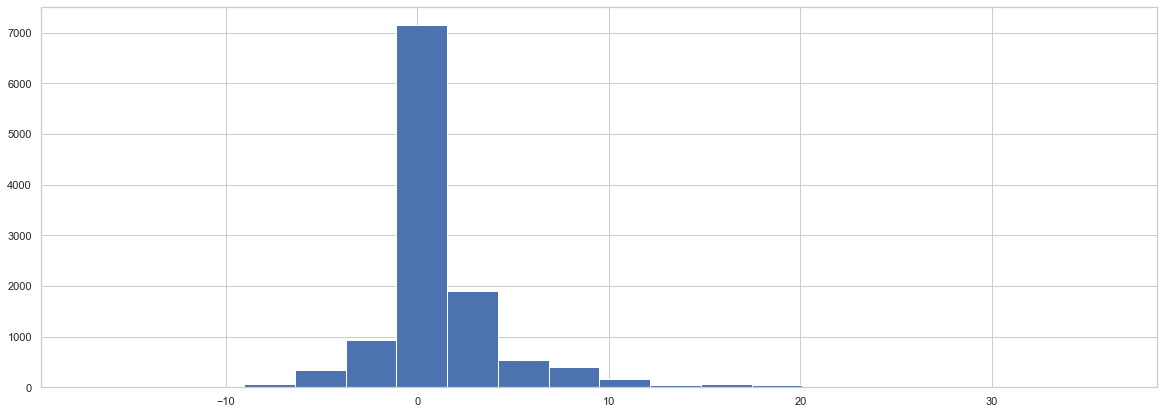

In [245]:
plt.figure(figsize = (20, 7))
plt.hist(x=df_ball_control['diff'], bins=20)